In [1]:
!pip install pytorch-tabnet
!git clone https://github.com/alezakuskin/Stark_ML
!cd /usr/local/lib/python3.7/dist-packages/pytorch_tabnet && patch </content/Stark_ML/float64.patch

Cloning into 'Stark_ML'...
remote: Enumerating objects: 499, done.
remote: Counting objects: 100% (499/499), done.
remote: Compressing objects: 100% (357/357), done.
remote: Total 499 (delta 278), reused 336 (delta 139), pack-reused 0
Receiving objects: 100% (499/499), 22.12 MiB | 5.04 MiB/s, done.
Resolving deltas: 100% (278/278), done.
patching file abstract_model.py
patching file multitask.py
patching file pretraining.py
patching file tab_model.py
patching file tab_network.py
patching file utils.py


In [2]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
!pip install optuna

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
import importlib
import json
import torch
#torch.autograd.set_detect_anomaly(False)
torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.float64)

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

from sklearn import svm
from google.colab import output

from pytorch_tabnet.tab_model import  TabNetRegressor
np.random.seed(777)

output.clear()

In [85]:
if os.path.isdir('Stark_ML'):
    !rm -rf Stark_ML

!git clone https://github.com/alezakuskin/Stark_ML

import Stark_ML.utils.optuning
import Stark_ML.models.base_models
import Stark_ML.utils.metrics
import Stark_ML.utils.terms
import Stark_ML.utils.testset
import Stark_ML.utils.plotting
import Stark_ML.models.tabnet


importlib.reload(Stark_ML.models.base_models)
importlib.reload(Stark_ML.utils.optuning)
importlib.reload(Stark_ML.utils.metrics)
importlib.reload(Stark_ML.utils.plotting)
importlib.reload(Stark_ML.models.tabnet)


from Stark_ML.models.base_models import *
from Stark_ML.utils.optuning import *
from Stark_ML.utils.metrics import *
from Stark_ML.utils.terms import *
from Stark_ML.utils.testset import *
from Stark_ML.utils.plotting import *
from Stark_ML.models.tabnet import *
from Stark_ML.utils import *
output.clear()

# Data preprocessing

In [4]:
data = pd.read_excel('/content/Stark_ML/Source_files/Stark_data.xlsx',
                     sheet_name='Experimental',
                     usecols='A:BC'
                   )
data['Term'] = term_to_number(data['Term'])
data['Term.1'] = term_to_number(data['Term.1'])

In [5]:
#Defining elements to exclude from training set
elements_to_exclude = ['S', 'Mg', 'Mn']

#Separating into data for width and shift prediction
data_width = data[np.isnan(data['w (A)']) == False]
data_width_elements = data_width.loc[data_width['Element'].isin(elements_to_exclude)]
data_width = data_width.drop(data_width_elements.index)
data_width = data_width.sort_values(by=['Z number'])

target_width = data_width['w (A)']
target_width_elements = data_width_elements['w (A)']

label_width = data_width.loc[:, ['Element', 'Wavelength']]
label_width_elements = data_width_elements.loc[:, ['Element', 'Wavelength']]
data_width = data_width.drop(columns = ['d (A)', 'w (A)'])
data_width_elements = data_width_elements.drop(columns = ['d (A)', 'w (A)'])


data_shift = data[np.isnan(data['d (A)']) == False]
data_shift = data_shift.sort_values(by=['Z number'])
target_shift = data_shift['d (A)']
label_shift = data_shift.loc[:, ['Element', 'Wavelength']]
data_shift = data_shift.drop(columns = ['w (A)', 'd (A)'])

#Selecting items for predicting both parameters simultaneously
data_both = data[(np.isnan(data['w (A)']) == False) & (np.isnan(data['d (A)']) == False)]
data_shift = data_shift.sort_values(by=['Z number'])
target_both = data_both.loc[:, ['w (A)', 'd (A)']]
label_both = data_both.loc[:, ['Element', 'Wavelength']]
data_both = data_both.drop(columns = ['w (A)', 'd (A)'])

print(f'Number of items with width: {data_width.shape[0]}')
print(f'Number of items with shift: {data_shift.shape[0]}')
print(f'Number of items with both parameters: {data_both.shape[0]}')
print()
print(f'Size of elements-exclusive test set: {data_width_elements.shape[0]}')

Number of items with width: 897
Number of items with shift: 351
Number of items with both parameters: 299

Size of elements-exclusive test set: 34


## Data visual description

In [6]:
data_width.describe()

,Wavelength,Z number,1s,2s,2p,3s,3p,3d,4s,4p,...,8p,8d,9s,10s,Multiplicity.1,Term.1,Parity.1,J.1,E upper,T
count,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,...,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,8.970000e+02,897.000000
mean,437.237659,14.851728,1.769231,1.612040,3.460424,0.858417,1.943144,2.469342,0.332219,0.749164,...,0.001115,0.002230,0.001115,0.001115,2.899666,1.544036,0.603122,1.827202,2.113072e+05,16462.332219
std,216.218894,15.978406,0.421560,0.737235,2.179154,0.905723,2.720643,3.995171,0.687093,1.679233,...,0.033389,0.047193,0.033389,0.033389,1.247752,1.312079,0.489523,1.432334,3.325359e+06,9439.627870
min,113.416500,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.173231e+04,2950.000000
25%,283.999000,6.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000,5.387426e+04,10970.000000
50%,471.315614,7.000000,2.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,1.500000,8.848342e+04,12500.000000
75%,541.520000,26.000000,2.000000,2.000000,6.000000,2.000000,6.000000,7.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,1.000000,2.000000,1.184278e+05,20800.000000
max,2058.130000,82.000000,2.000000,2.000000,6.000000,2.000000,6.000000,10.000000,2.000000,6.000000,...,1.000000,1.000000,1.000000,1.000000,7.000000,5.000000,1.000000,7.000000,9.968131e+07,50000.000000


In [7]:
data_width_stats = target_width.describe()
print(data_width_stats)

count    897.000000
mean       4.564198
std       12.780995
min        0.001500
25%        0.204444
50%        1.451247
75%        4.016393
max      180.500000
Name: w (A), dtype: float64


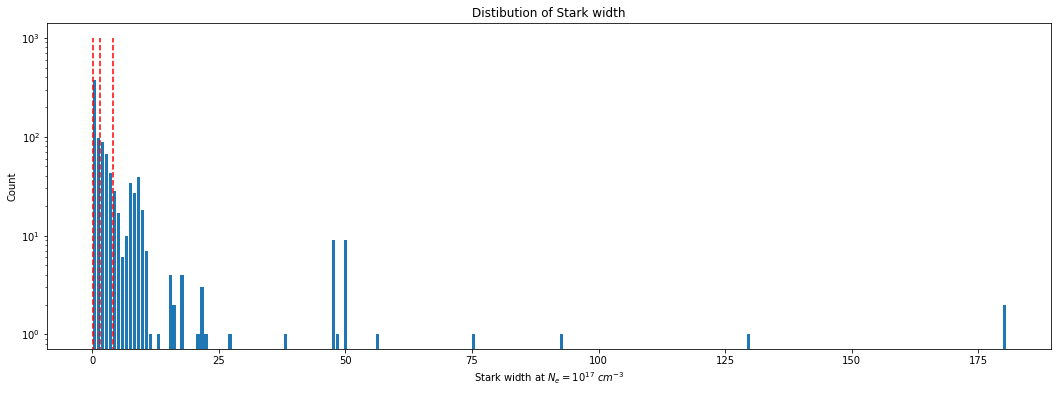

In [8]:
fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_width, bins='auto', log=True, rwidth = 0.8)
ax.vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')

ax.set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

## Train - Test split

In [9]:
#Q1
data_test_q1, target_test_q1 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)

#Q2
data_test_q2, target_test_q2 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)

#Q3
data_test_q3, target_test_q3 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)

#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 150]) < 1 or len(target_test_q4[(target_test_q4 > 70) & (target_test_q4 < 150)]) < 1:
  data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = None)
  
data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = 6)

print(target_test_q4[target_test_q4 > 70])

581    130.0
585    180.5
580     75.5
Name: w (A), dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


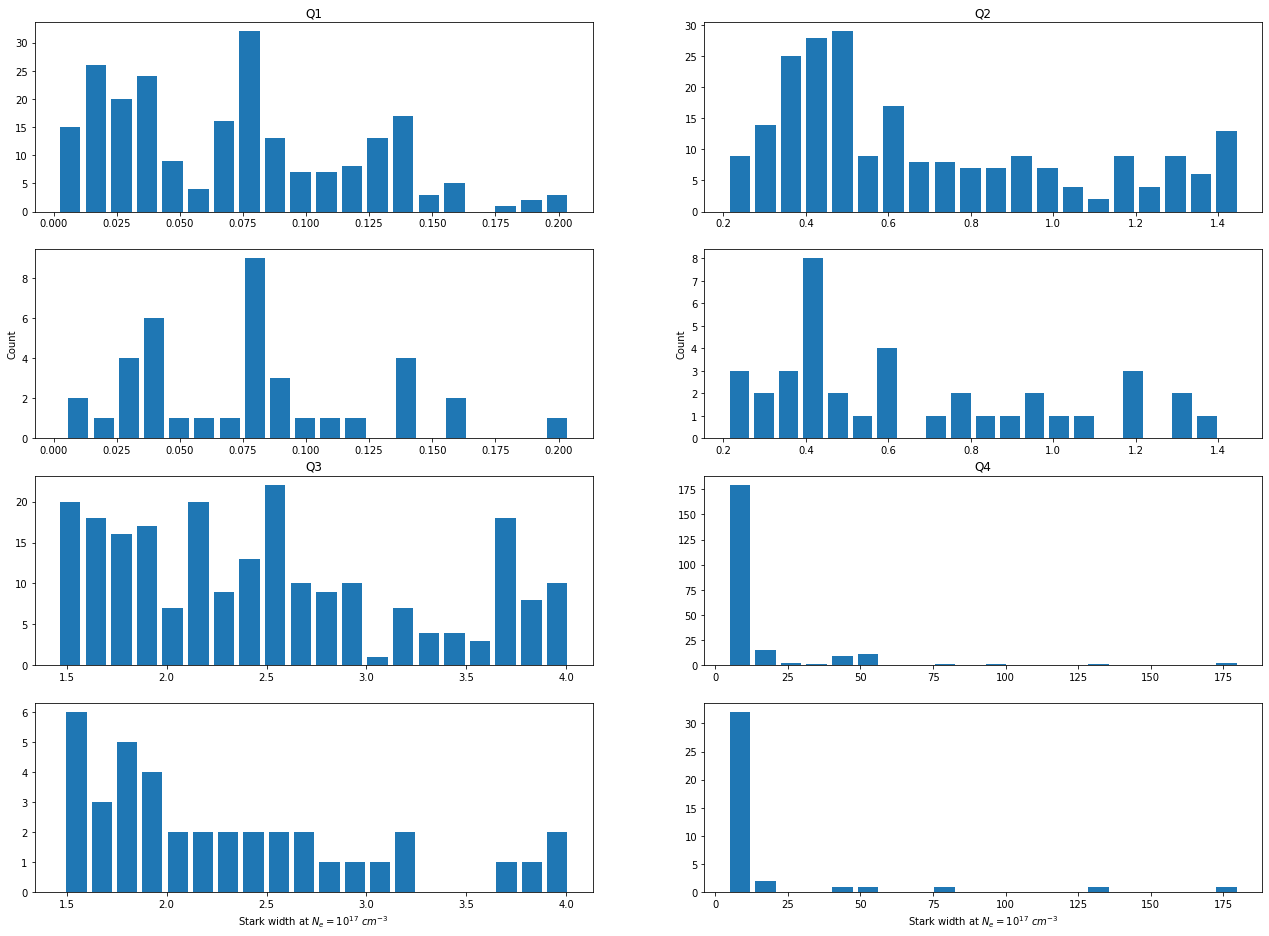

In [10]:
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_width[target_width <= data_width_stats['25%']], bins=20, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 20, rwidth = 0.8)

axs[0, 1].hist(target_width[(target_width > data_width_stats['25%']) & (target_width <= data_width_stats['50%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 20, rwidth = 0.8)

axs[2, 0].hist(target_width[(target_width > data_width_stats['50%']) & (target_width <= data_width_stats['75%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 20, rwidth = 0.8)

axs[2, 1].hist(target_width[target_width > data_width_stats['75%']],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 20, rwidth = 0.8)

axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
axs[3, 1].get_shared_x_axes().join(axs[2, 1], axs[3, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

In [11]:
#Creating full train and test datasets
data_width_test, target_width_test = data_test_q1.append(data_test_q2), target_test_q1.append(target_test_q2)
data_width_test, target_width_test = data_width_test.append(data_test_q3), target_width_test.append(target_test_q3)
data_width_test, target_width_test = data_width_test.append(data_test_q4), target_width_test.append(target_test_q4)

data_width_train, target_width_train = data_width.drop(data_width_test.index), target_width.drop(target_width_test.index)

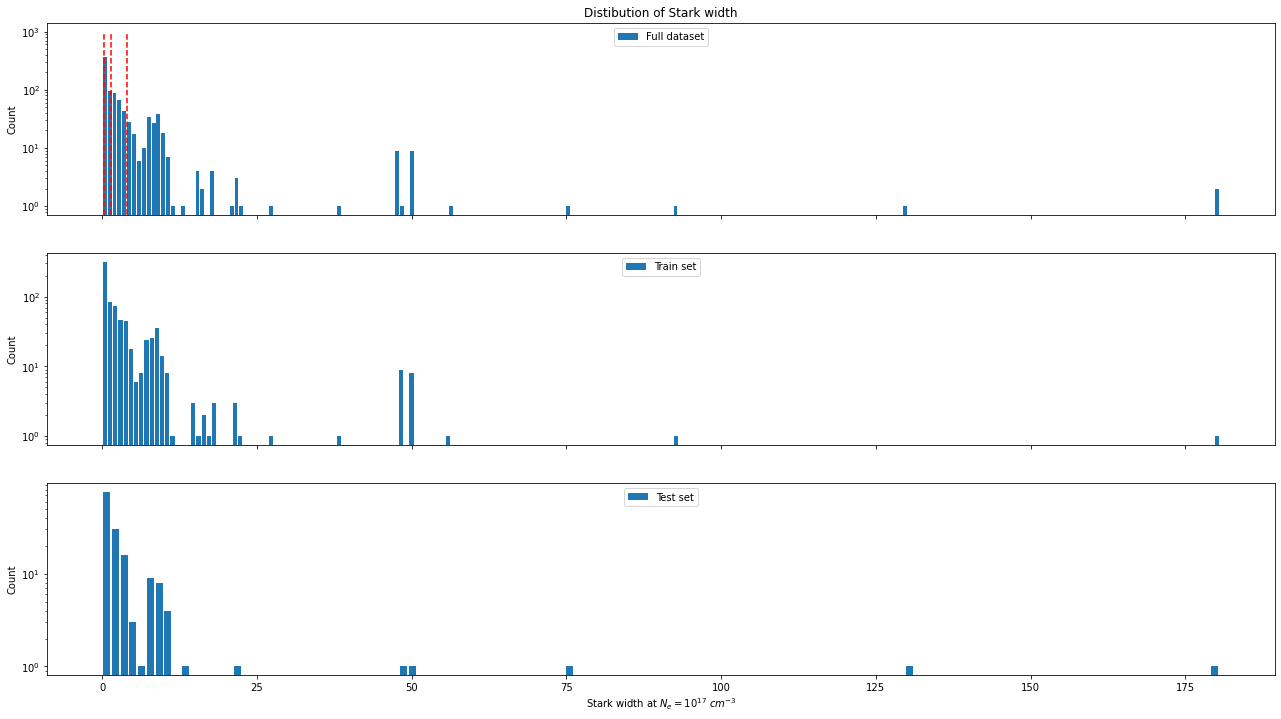

In [12]:
test_width_stats = target_width_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_width, bins='auto', log=True, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_width_train, bins = 'auto', log = True, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_width_test, bins = 'auto', log = True, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')
'''axs[1].vlines(x = test_width_stats['25%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['50%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['75%'], ymin = 0, ymax = 100, ls='--', colors='r')
'''
axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

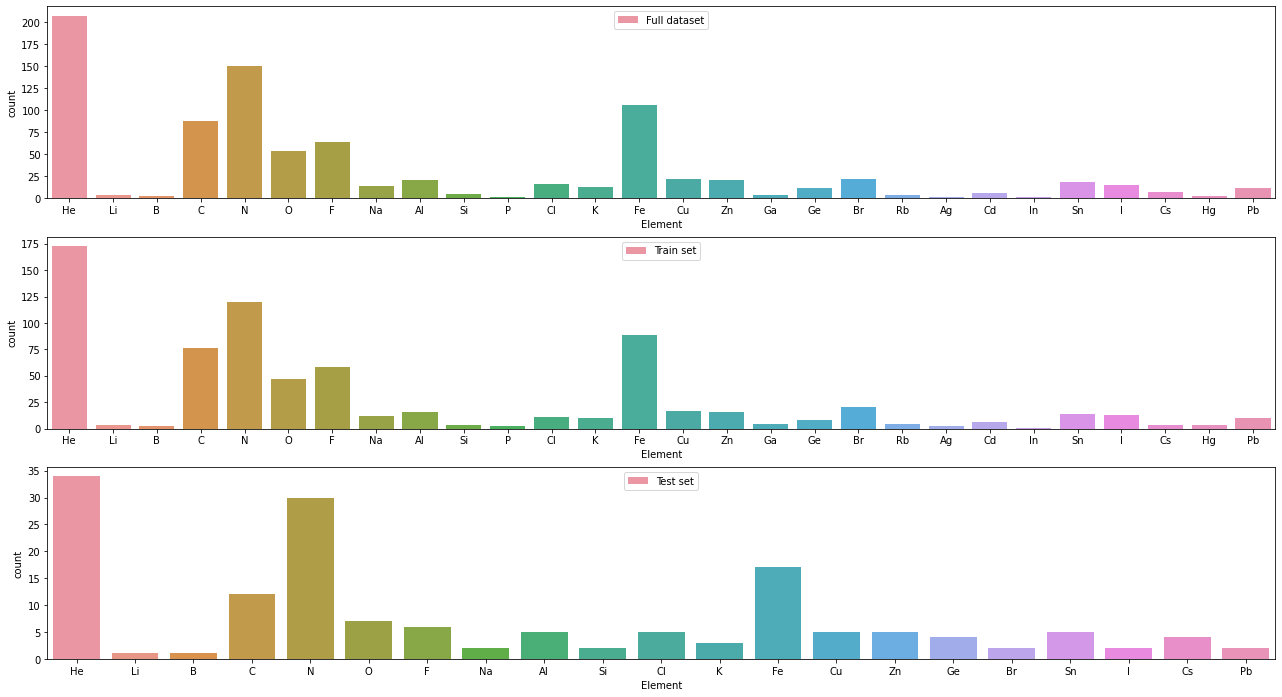

In [13]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_width, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_width_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_width_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

In [14]:
#Assigning proper variables
XW_train, YW_train = data_width_train.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_train
XW_test, YW_test = data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_test

print(XW_train.shape, YW_train.shape)
print(XW_test.shape, YW_test.shape)

XW_train = XW_train.sample(frac = 1, random_state = 777)
YW_train = YW_train.sample(frac = 1, random_state = 777)

print('\n', XW_train.shape, YW_train.shape)
print(XW_test.shape, YW_test.shape)
#XS_train, XS_test, YS_train, YS_test = train_test_split(data_shift, target_shift, test_size = 0.2, random_state = 7)
#XB_train, XB_test, YB_train, YB_test = train_test_split(data_both, target_both, test_size = 0.2, random_state = 7)

(743, 50) (743,)
(154, 50) (154,)

 (743, 50) (743,)
(154, 50) (154,)


#Models optimization

## KNN

In [ ]:
KNN_params = {
    'n_neighbors' : [1, 150],
    'weights' : ['distance', 'uniform'],
    'leaf_size' : [1, 100],
    'p' : [1., 2.],
    'nfold' : 5,
    'squared_metrics' : False
    }

model_name = KNN

KNN_res = main(X = XW_train, y = YW_train, model_name = model_name, params = KNN_params, n_trials = 1000)

with open('KNN_optimal_parameters', 'w') as fp:
    json.dump(KNN_res.best_params, fp)

[I 2022-04-12 13:47:40,093] A new study created in memory with name: no-name-aada8abd-9d29-450d-96c7-04d61b987b62


Start hyperparameter optimization


/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py:80: UserWarning: Progress bar only supports serial execution (`n_jobs=1`).
  warnings.warn("Progress bar only supports serial execution (`n_jobs=1`).")
[I 2022-04-12 13:47:41,768] Trial 1 finished with value: 5.096432971508369 and parameters: {'n_neighbors': 112, 'weights': 'distance', 'leaf_size': 58, 'p': 1.8510463365977305}. Best is trial 1 with value: 5.096432971508369.
[I 2022-04-12 13:47:41,837] Trial 0 finished with value: 10.013989279467872 and parameters: {'n_neighbors': 75, 'weights': 'uniform', 'leaf_size': 14, 'p': 1.7055113843566374}. Best is trial 1 with value: 5.096432971508369.
[I 2022-04-12 13:47:43,358] Trial 2 finished with value: 8.205093042778978 and parameters

Best parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 65, 'p': 1.9319232842057978}


Fitting old
Fitting new
Fitting default
Calculating bootstrap score for old
Calculating bootstrap score for new
Calculating bootstrap score for default


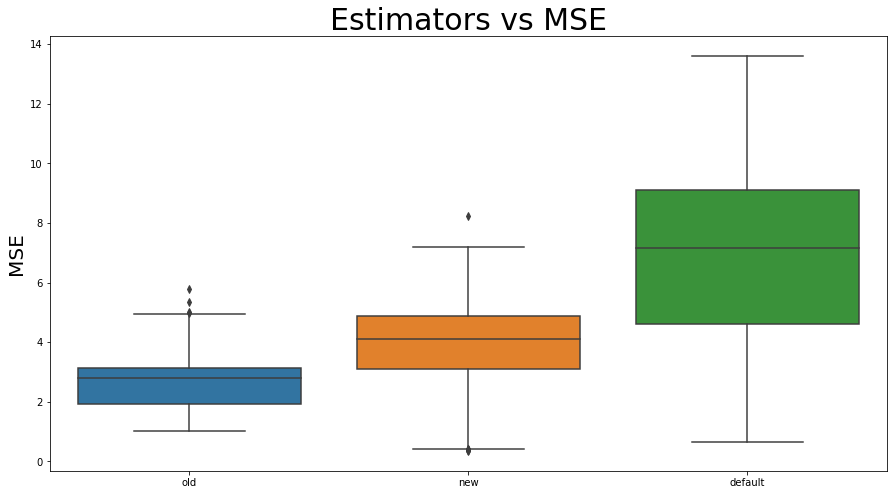

In [ ]:
KNN_params = KNN_res.best_params

models = {}
models['old'] = KNeighborsRegressor(weights='distance',
                                          n_neighbors = 70,
                                          n_jobs = -1)
models['new'] = KNeighborsRegressor(**KNN_params)

models['default'] = KNeighborsRegressor(weights = 'uniform', n_neighbors = 3)

results = train_and_test_regressor(models, XW_train, YW_train, XW_test, YW_test)

plot_model_comparison(results)

In [ ]:
KNN_df = KNN_res.trials_dataframe()
KNN_df

,number,value,datetime_start,datetime_complete,duration,params_leaf_size,params_n_neighbors,params_p,params_weights,state
0,0,10.013989,2022-04-12 13:47:40.106768,2022-04-12 13:47:41.837393,0 days 00:00:01.730625,14,75,1.705511,uniform,COMPLETE
1,1,5.096433,2022-04-12 13:47:40.113631,2022-04-12 13:47:41.767569,0 days 00:00:01.653938,58,112,1.851046,distance,COMPLETE
2,2,8.205093,2022-04-12 13:47:41.772185,2022-04-12 13:47:43.357943,0 days 00:00:01.585758,71,32,1.666567,uniform,COMPLETE
3,3,4.784772,2022-04-12 13:47:41.847137,2022-04-12 13:47:43.569646,0 days 00:00:01.722509,80,36,1.290381,distance,COMPLETE
4,4,10.033234,2022-04-12 13:47:43.370258,2022-04-12 13:47:45.012130,0 days 00:00:01.641872,85,87,1.931431,uniform,COMPLETE
...,...,...,...,...,...,...,...,...,...,...
995,995,5.021652,2022-04-12 13:57:46.637345,2022-04-12 13:57:47.845011,0 days 00:00:01.207666,67,1,1.961200,distance,COMPLETE
996,996,4.021390,2022-04-12 13:57:47.492627,2022-04-12 13:57:48.700113,0 days 00:00:01.207486,75,4,1.959803,distance,COMPLETE
997,997,5.084960,2022-04-12 13:57:47.850455,2022-04-12 13:57:49.112991,0 days 00:00:01.262536,75,96,1.903025,distance,COMPLETE
998,998,4.865306,2022-04-12 13:57:48.706061,2022-04-12 13:57:49.927569,0 days 00:00:01.221508,64,8,1.923475,distance,COMPLETE


In [ ]:
optuna.visualization.plot_param_importances(KNN_res)

In [ ]:
optuna.visualization.plot_slice(KNN_res, params = ['weights', 'n_neighbors'])

## Random Forest

In [ ]:
RF_params = {
    'n_estimators' : 100,
    'max_depth' : [1, 50],
    'min_samples_split' : [2, 10],
    'min_samples_leaf' : [1, 10],
    'criterion' : ['squared_error', 'absolute_error', 'poisson'],
    'nfold' : 5,
    'squared_metrics' : False
    }

model_name = RandomForest

RF_res = main(X = XW_train, y = YW_train, model_name = model_name, params = RF_params, n_trials = 50)

with open('RF_optimal_parameters', 'w') as fp:
    json.dump(RF_res.best_params, fp)

[I 2022-04-12 15:46:28,985] A new study created in memory with name: no-name-61fa4491-119b-4cb5-8a63-fa5beb036313


Start hyperparameter optimization


/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py:80: UserWarning:

Progress bar only supports serial execution (`n_jobs=1`).

[I 2022-04-12 15:46:38,725] Trial 0 finished with value: 4.8511160270819484 and parameters: {'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 0 with value: 4.8511160270819484.
[I 2022-04-12 15:46:42,622] Trial 2 finished with value: 9.711722105795207 and parameters: {'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 0 with value: 4.8511160270819484.
[I 2022-04-12 15:46:46,443] Trial 3 finished with value: 5.953852471592626 and parameters: {'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 6, 'criterion': '

Best parameters: {'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


Fitting old
Fitting new
Fitting default
Calculating bootstrap score for old
Calculating bootstrap score for new
Calculating bootstrap score for default


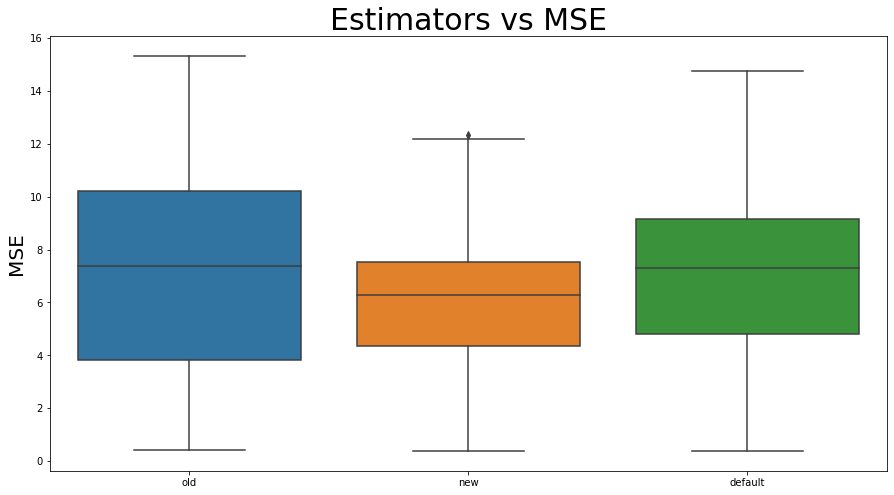

In [ ]:
RF_params = RF_res.best_params

models_RF = {}
models_RF['old'] = RandomForestRegressor(n_estimators = 500,
                                      max_depth = 25,
                                      min_samples_leaf = 2,
                                      min_samples_split = 2,
                                      n_jobs = -1)
models_RF['new'] = RandomForestRegressor(**RF_params, n_estimators = 100)

models_RF['default'] = RandomForestRegressor()

results_RF = train_and_test_regressor(models_RF, XW_train, YW_train, XW_test, YW_test)
plot_model_comparison(results_RF)

Fitting 10
Fitting 11
Fitting 12
Fitting 13
Fitting 14
Fitting 15
Fitting 16
Fitting 17
Fitting 18
Fitting 19
Fitting 20
Fitting 21
Fitting 22
Fitting 23
Fitting 24
Fitting 25
Fitting 26
Fitting 27
Fitting 28
Fitting 29
Fitting 30
Fitting 31
Fitting 32
Fitting 33
Fitting 34
Fitting 35
Fitting 36
Fitting 37
Fitting 38
Fitting 39
Fitting 40
Fitting 41
Fitting 42
Fitting 43
Fitting 44
Fitting 45
Fitting 46
Fitting 47
Fitting 48
Fitting 49
Fitting 50
Fitting 51
Fitting 52
Fitting 53
Fitting 54
Fitting 55
Fitting 56
Fitting 57
Fitting 58
Fitting 59
Fitting 60
Fitting 61
Fitting 62
Fitting 63
Fitting 64
Fitting 65
Fitting 66
Fitting 67
Fitting 68
Fitting 69
Fitting 70
Fitting 71
Fitting 72
Fitting 73
Fitting 74
Fitting 75
Fitting 76
Fitting 77
Fitting 78
Fitting 79
Fitting 80
Fitting 81
Fitting 82
Fitting 83
Fitting 84
Fitting 85
Fitting 86
Fitting 87
Fitting 88
Fitting 89
Fitting 90
Fitting 91
Fitting 92
Fitting 93
Fitting 94
Fitting 95
Fitting 96
Fitting 97
Fitting 98
Fitting 99
Fitting 10

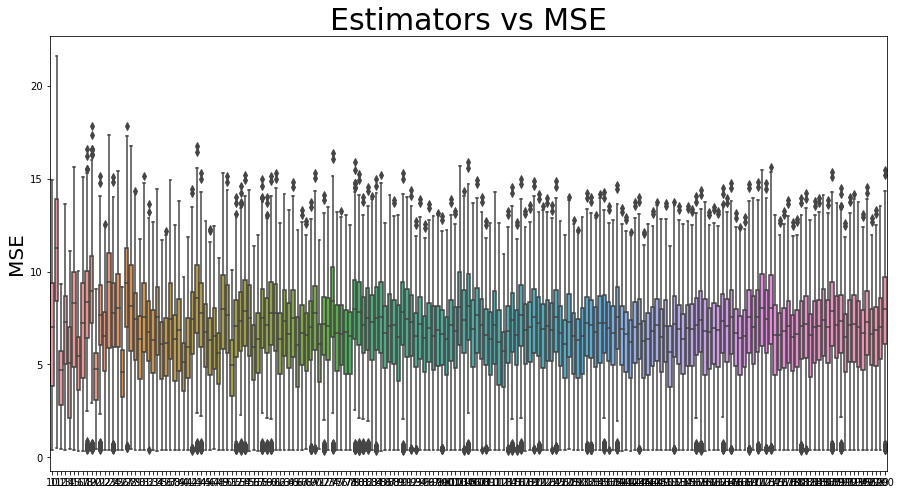

In [ ]:
model = {}
for i in range(10, 201):
    model[f'{i}'] = RandomForestRegressor(**RF_params, n_estimators = i)

path = train_and_test_regressor(model, XW_train, YW_train, XW_test, YW_test)
plot_model_comparison(path)

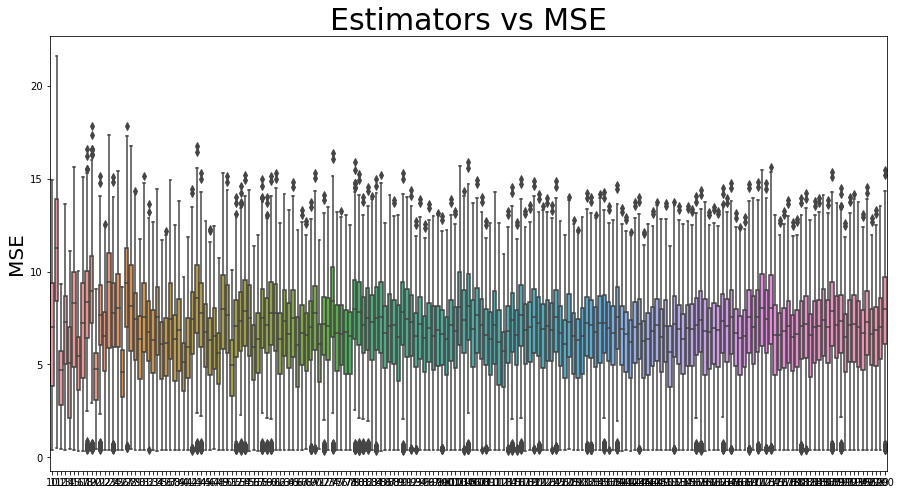

In [ ]:
%matplotlib inline
plot_model_comparison(path)

In [ ]:
optuna.visualization.plot_param_importances(RF_res)

## Gradient Boosting

In [ ]:
GB_params = {
    'n_estimators' : 100,
    'max_depth' : [1, 50],
    'loss' : ['squared_error', 'absolute_error', 'quantile', 'huber'],
    'learning_rate' : [0.01, 0.1],
    'min_samples_leaf' : [1, 10],
    'nfold' : 5,
    'squared_metrics' : False
    }

model_name = Gradient_Boosting

GB_res = main(X = XW_train, y = YW_train, model_name = model_name, params = GB_params, n_trials = 200)

with open('GB_optimal_parameters', 'w') as fp:
    json.dump(GB_res.best_params, fp)

[I 2022-04-18 13:26:25,830] A new study created in memory with name: no-name-00435f30-c294-47f0-8979-0a5247c9f6cb


Start hyperparameter optimization


/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py:80: UserWarning: Progress bar only supports serial execution (`n_jobs=1`).
  warnings.warn("Progress bar only supports serial execution (`n_jobs=1`).")
[I 2022-04-18 13:26:29,481] Trial 1 finished with value: 4.661094088401709 and parameters: {'max_depth': 12, 'max_leaves': 3, 'learning_rate': 0.05153344645843296}. Best is trial 1 with value: 4.661094088401709.
[I 2022-04-18 13:26:30,656] Trial 0 finished with value: 5.113732920717284 and parameters: {'max_depth': 49, 'max_leaves': 14, 'learning_rate': 0.01830728033470861}. Best is trial 1 with value: 4.661094088401709.
[I 2022-04-18 13:26:36,078] Trial 2 finished with value: 4.671585556839222 and parameters: {'max_depth': 37, 'max

Best parameters: {'max_depth': 6, 'max_leaves': 16, 'learning_rate': 0.05809936075942276}


Fitting old
Fitting new
Fitting default
Calculating bootstrap score for old
Calculating bootstrap score for new
Calculating bootstrap score for default


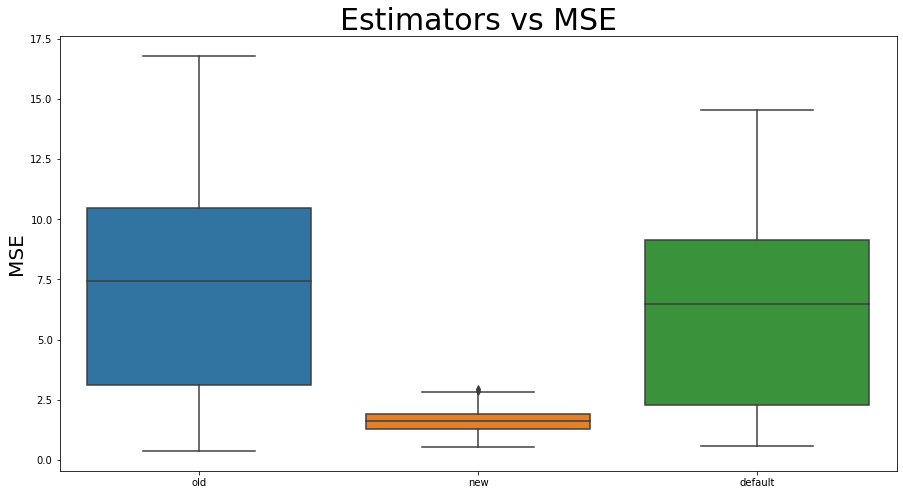

In [ ]:
GB_params = GB_res.best_params

models_GB = {}
models_GB['old'] = GradientBoostingRegressor(n_estimators = 200,
                                      learning_rate = 0.5,
                                      max_depth = 15,
                                      min_samples_leaf = 1,
                                      min_samples_split = 3)
models_GB['new'] = GradientBoostingRegressor(**GB_params, n_estimators = 500)

models_GB['default'] = GradientBoostingRegressor()

results_GB = train_and_test_regressor(models_GB, XW_train, YW_train, XW_test, YW_test)
plot_model_comparison(results_GB)

In [ ]:
optuna.visualization.plot_param_importances(GB_res)

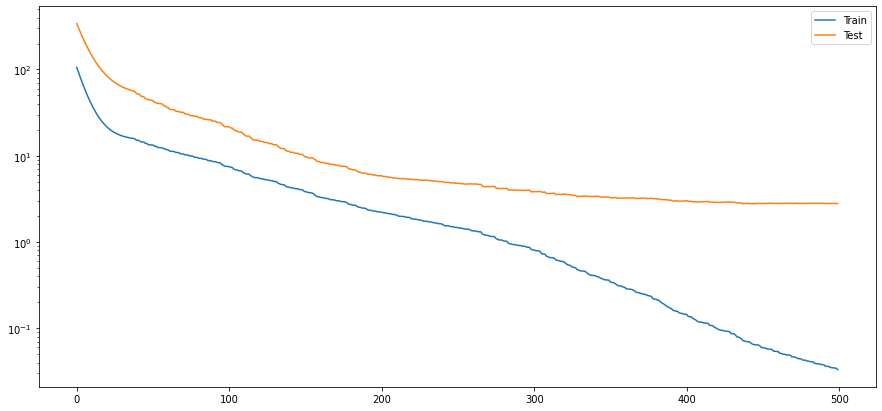

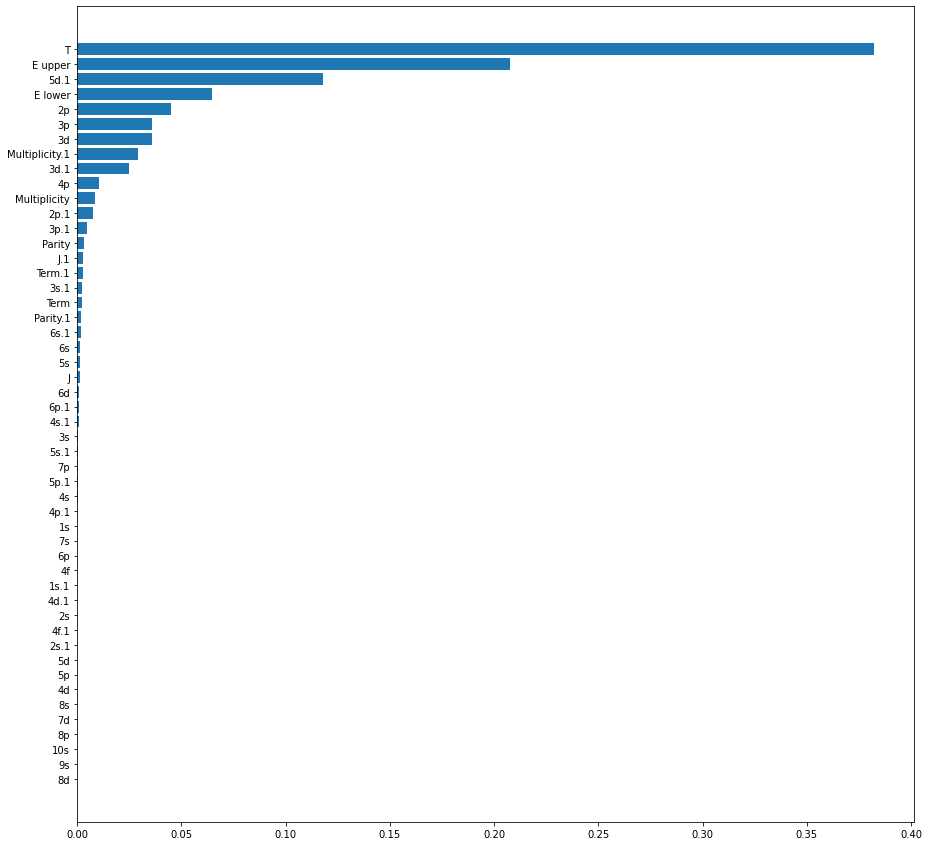

In [ ]:
test_score = np.zeros((500))
for i, y_pred in enumerate(models_GB['new'].staged_predict(XW_test)):
    test_score[i] = models_GB['new'].loss_(YW_test, y_pred)
plt.figure(figsize = (15, 7))
plt.plot(models_GB['new'].train_score_, label = 'Train')
plt.plot(test_score, label = 'Test')
plt.semilogy()
plt.legend()
plt.show()

feature_importance = models_GB['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(XW_train.columns)[sorted])
plt.show()

## XGBoost

In [ ]:
XGB_params = {
    'n_estimators' : 500,
    'learning_rate' : [0.01, 0.5],
    'max_depth' : [1, 15],
    'min_child_weight' : [1, 15],
    'reg_alpha' : [1e-8, 10],
    'reg_lambda' : [1e-8, 10],
    'nfold' : 5,
    'squared_metrics' : False
    }

model_name = XGBoost

XGB_res = main(X = XW_train, y = YW_train, model_name = model_name, params = XGB_params, n_trials = 500)

with open('XGB_optimal_parameters', 'w') as fp:
    json.dump(XGB_res.best_params, fp)

[I 2022-04-18 15:56:52,981] A new study created in memory with name: no-name-d2017175-bd3b-48c4-a5ec-c36121a81127


Start hyperparameter optimization


/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py:80: UserWarning:

Progress bar only supports serial execution (`n_jobs=1`).

[I 2022-04-18 15:56:55,696] Trial 1 finished with value: 4.250850484238304 and parameters: {'max_depth': 4, 'learning_rate': 0.4490213344381497, 'min_child_weight': 3, 'reg_alpha': 1.1985326140736756, 'reg_lambda': 0.006701959128474285}. Best is trial 1 with value: 4.250850484238304.
[I 2022-04-18 15:56:57,266] Trial 0 finished with value: 5.51883671097676 and parameters: {'max_depth': 14, 'learning_rate': 0.3305886521333913, 'min_child_weight': 2, 'reg_alpha': 0.2949842869160751, 'reg_lambda': 1.8853572196705406e-07}. Best is trial 1 with value: 4.250850484238304.
[I 2022-04-18 15:57:06,501] Trial 2 finished with value:

Best parameters: {'max_depth': 4, 'learning_rate': 0.23103425220000523, 'min_child_weight': 4, 'reg_alpha': 4.44043162919541, 'reg_lambda': 2.2381945739403948e-07}


{'old': XGBRegressor(max_depth=5, min_child_weight=3, n_estimators=500, n_jobs=-1), 'new': XGBRegressor(learning_rate=0.23103425220000523, max_depth=4, min_child_weight=4,
             n_estimators=500, reg_alpha=4.44043162919541,
             reg_lambda=2.2381945739403948e-07), 'default': XGBRegressor()}
Fitting old
[16:16:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting new
[16:16:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting default
[16:16:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Calculating bootstrap score for old
Calculating bootstrap score for new
Calculating bootstrap score for default


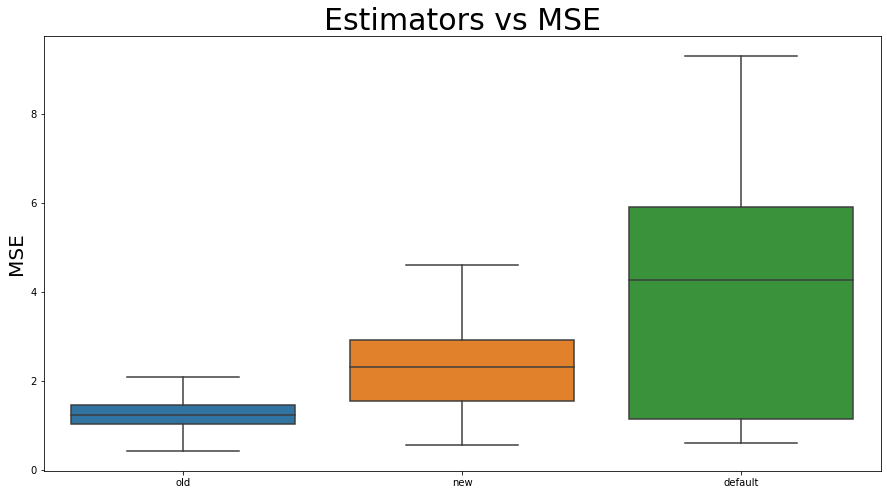

In [ ]:
XGB_params = XGB_res.best_params

models_XGB = {}
models_XGB['old'] = xgboost.XGBRegressor(n_estimators = 500,
                                        learning_rate = 0.1,
                                        max_depth = 5,
                                        min_child_weight = 3,
                                        n_jobs=-1)
models_XGB['new'] = xgboost.XGBRegressor(**XGB_params, n_estimators = 500)

models_XGB['default'] = xgboost.XGBRegressor()

print(models_XGB)
results_XGB = train_and_test_regressor(models_XGB, XW_train, YW_train, XW_test, YW_test)
plot_model_comparison(results_XGB)

In [ ]:
optuna.visualization.plot_param_importances(XGB_res)

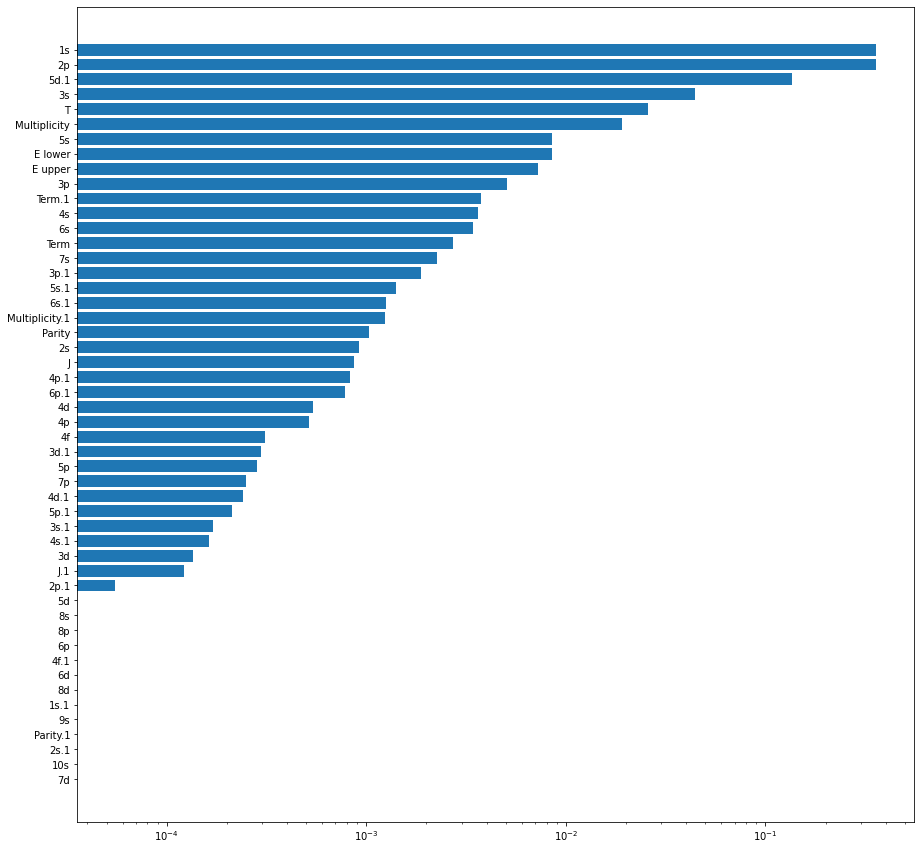

In [ ]:
'''test_score = np.zeros((500))
for i, y_pred in enumerate(models_XGB['new'].staged_predict(XW_test)):
    test_score[i] = models_XGB['new'].loss_(YW_test, y_pred)
plt.figure(figsize = (15, 7))
plt.plot(models_XGB['new'].train_score_, label = 'Train')
plt.plot(test_score, label = 'Test')
plt.semilogy()
plt.legend()
plt.show()
'''
feature_importance = models_XGB['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(XW_train.columns)[sorted])
plt.semilogx()
plt.show()

## TabNet

In [25]:
print(torch.cuda.is_available())

False


In [41]:
TabNet_params = {
    'n_d' : [1, 64],
    'n_steps' : [1, 25],
    'gamma' : [1., 2.],
    'n_independent' : [1, 20],
    'n_shared' : [1, 20],
    'momentum' : [1e-3, 0.4],
    'mask_type' : ['sparsemax', 'entmax'],
    'nfold' : 5,
    'squared_metrics' : False,
    'device_name' : 'cuda',
    'n_jobs' : -1
    }

model_name = TabNet

TabNet_res = main(X = XW_train, y = YW_train, model_name = model_name, params = TabNet_params, n_trials = 500)

with open('TabNet_optimal_parameters', 'w') as fp:
    json.dump(TabNet_res.best_params, fp)

[I 2022-04-20 17:17:52,378] A new study created in memory with name: no-name-cf6981bf-eaab-4f36-8f93-b3f9ea747860


Start hyperparameter optimization
{'device_name': 'cuda', 'n_d': 39, 'n_steps': 16, 'gamma': 1.2926369722406794, 'n_independent': 13, 'n_shared': 16, 'momentum': 0.002300695654605361, 'mask_type': 'sparsemax'}
{'device_name': 'cuda', 'n_d': 26, 'n_steps': 17, 'gamma': 1.747436222079519, 'n_independent': 18, 'n_shared': 11, 'momentum': 0.03525182910379823, 'mask_type': 'sparsemax'}


/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py:80: UserWarning:

Progress bar only supports serial execution (`n_jobs=1`).




Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 82.58315
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 111 with best_epoch = 91 and best_eval_mse = 2304603.63018
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 325.35913
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 167.35968
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 126 with best_epoch = 106 and best_eval_mse = 674725.7462
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 113.8746
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 18829362.29359
Best weights from best epoch are automatically used!



[I 2022-04-20 17:34:45,419] Trial 1 finished with value: 12.550366655754477 and parameters: {'n_d': 26, 'n_steps': 17, 'gamma': 1.747436222079519, 'n_independent': 18, 'n_shared': 11, 'momentum': 0.03525182910379823, 'mask_type': 'sparsemax'}. Best is trial 1 with value: 12.550366655754477.


{'device_name': 'cuda', 'n_d': 39, 'n_steps': 15, 'gamma': 1.0616636556079517, 'n_independent': 1, 'n_shared': 19, 'momentum': 0.01995882053869327, 'mask_type': 'entmax'}

Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 64.7988
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 376.04097
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 134 with best_epoch = 114 and best_eval_mse = 68272.4358
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 462.95448
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 876.09424
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 128.87874
Best weights from best epoch are au

[I 2022-04-20 17:44:19,969] Trial 2 finished with value: 17.981857985527206 and parameters: {'n_d': 39, 'n_steps': 15, 'gamma': 1.0616636556079517, 'n_independent': 1, 'n_shared': 19, 'momentum': 0.01995882053869327, 'mask_type': 'entmax'}. Best is trial 1 with value: 12.550366655754477.


{'device_name': 'cuda', 'n_d': 52, 'n_steps': 13, 'gamma': 1.9681802428163502, 'n_independent': 11, 'n_shared': 18, 'momentum': 0.1929234336700712, 'mask_type': 'entmax'}

Early stopping occurred at epoch 100 with best_epoch = 80 and best_eval_mse = 1127581.04397
Best weights from best epoch are automatically used!


[I 2022-04-20 17:45:13,571] Trial 0 finished with value: 1600.3912925676336 and parameters: {'n_d': 39, 'n_steps': 16, 'gamma': 1.2926369722406794, 'n_independent': 13, 'n_shared': 16, 'momentum': 0.002300695654605361, 'mask_type': 'sparsemax'}. Best is trial 1 with value: 12.550366655754477.


{'device_name': 'cuda', 'n_d': 36, 'n_steps': 2, 'gamma': 1.3568404292733551, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.001869069366809124, 'mask_type': 'entmax'}

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 1359.79172
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 249 with best_epoch = 229 and best_eval_mse = 189.14675
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 68.52667
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 819.72492
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 1180.95967
Best weights from best epoch are automatically used!


[I 2022-04-20 17:46:12,952] Trial 4 finished with value: 24.38048666728388 and parameters: {'n_d': 36, 'n_steps': 2, 'gamma': 1.3568404292733551, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.001869069366809124, 'mask_type': 'entmax'}. Best is trial 1 with value: 12.550366655754477.


{'device_name': 'cuda', 'n_d': 53, 'n_steps': 3, 'gamma': 1.424185790051049, 'n_independent': 12, 'n_shared': 3, 'momentum': 0.161574812407227, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 156.55921
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 59.10351
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 275.72289
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 107.2423
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 77.02811
Best weights from best epoch are automatically used!


[I 2022-04-20 17:47:54,378] Trial 5 finished with value: 10.019508867239098 and parameters: {'n_d': 53, 'n_steps': 3, 'gamma': 1.424185790051049, 'n_independent': 12, 'n_shared': 3, 'momentum': 0.161574812407227, 'mask_type': 'sparsemax'}. Best is trial 5 with value: 10.019508867239098.



Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 44.521
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 8, 'n_steps': 21, 'gamma': 1.2216873834433786, 'n_independent': 15, 'n_shared': 4, 'momentum': 0.060125444127736925, 'mask_type': 'entmax'}

Early stopping occurred at epoch 115 with best_epoch = 95 and best_eval_mse = 265.27462
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 381.02989
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 117 with best_epoch = 97 and best_eval_mse = 125.67671
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 402.61398
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 92 with best_epoch = 72 and best_eval_mse = 156.17529
Best weights from best epoch are auto

[I 2022-04-20 17:57:21,925] Trial 3 finished with value: 14.742489168714457 and parameters: {'n_d': 52, 'n_steps': 13, 'gamma': 1.9681802428163502, 'n_independent': 11, 'n_shared': 18, 'momentum': 0.1929234336700712, 'mask_type': 'entmax'}. Best is trial 5 with value: 10.019508867239098.


{'device_name': 'cuda', 'n_d': 28, 'n_steps': 21, 'gamma': 1.0291362740251842, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.0024375099847558793, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 216.18379
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 110 with best_epoch = 90 and best_eval_mse = 53.58529
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 284.24326
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 158.9228
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 82.5072
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 108.00049
Best weights from best epoch are au

[I 2022-04-20 18:00:46,041] Trial 7 finished with value: 11.25236946801488 and parameters: {'n_d': 28, 'n_steps': 21, 'gamma': 1.0291362740251842, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.0024375099847558793, 'mask_type': 'sparsemax'}. Best is trial 5 with value: 10.019508867239098.


{'device_name': 'cuda', 'n_d': 32, 'n_steps': 18, 'gamma': 1.5722036269946882, 'n_independent': 12, 'n_shared': 4, 'momentum': 0.09985150693703097, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 161.59698
Best weights from best epoch are automatically used!


[I 2022-04-20 18:01:59,927] Trial 6 finished with value: 25.220434164311506 and parameters: {'n_d': 8, 'n_steps': 21, 'gamma': 1.2216873834433786, 'n_independent': 15, 'n_shared': 4, 'momentum': 0.060125444127736925, 'mask_type': 'entmax'}. Best is trial 5 with value: 10.019508867239098.


{'device_name': 'cuda', 'n_d': 48, 'n_steps': 19, 'gamma': 1.8649730490432226, 'n_independent': 20, 'n_shared': 17, 'momentum': 0.0010805995380919833, 'mask_type': 'entmax'}

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 115.95612
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 346.69175
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 145.60242
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 150.95076
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 136.25934
Best weights from best epoch are automatically used!


[I 2022-04-20 18:08:07,563] Trial 8 finished with value: 13.082751071311014 and parameters: {'n_d': 32, 'n_steps': 18, 'gamma': 1.5722036269946882, 'n_independent': 12, 'n_shared': 4, 'momentum': 0.09985150693703097, 'mask_type': 'sparsemax'}. Best is trial 5 with value: 10.019508867239098.


{'device_name': 'cuda', 'n_d': 24, 'n_steps': 11, 'gamma': 1.4826031340793149, 'n_independent': 4, 'n_shared': 10, 'momentum': 0.01568421600923257, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 51.6954
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 312.70706
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 126.92545
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 125 with best_epoch = 105 and best_eval_mse = 19592908788539.016
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 86.29487
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 103 with best_epoch = 83 and best_eval_mse = 98.01271
Best weights from best ep

[I 2022-04-20 18:13:23,508] Trial 10 finished with value: 11.065847344390097 and parameters: {'n_d': 24, 'n_steps': 11, 'gamma': 1.4826031340793149, 'n_independent': 4, 'n_shared': 10, 'momentum': 0.01568421600923257, 'mask_type': 'sparsemax'}. Best is trial 5 with value: 10.019508867239098.


{'device_name': 'cuda', 'n_d': 64, 'n_steps': 1, 'gamma': 1.6809644386871663, 'n_independent': 8, 'n_shared': 9, 'momentum': 0.22822877896226687, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 24.33839
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 246.52409
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 94.0801
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 15.86278
Best weights from best epoch are automatically used!


[I 2022-04-20 18:14:21,953] Trial 11 finished with value: 7.671515566067209 and parameters: {'n_d': 64, 'n_steps': 1, 'gamma': 1.6809644386871663, 'n_independent': 8, 'n_shared': 9, 'momentum': 0.22822877896226687, 'mask_type': 'sparsemax'}. Best is trial 11 with value: 7.671515566067209.



Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 16.32804
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 61, 'n_steps': 1, 'gamma': 1.647739091484032, 'n_independent': 8, 'n_shared': 8, 'momentum': 0.33116442278657826, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 96 with best_epoch = 76 and best_eval_mse = 25.01894
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 263.27865
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 68.31202
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 13.75502
Best weights from best epoch are automatically used!


[I 2022-04-20 18:15:19,320] Trial 12 finished with value: 7.228484143007847 and parameters: {'n_d': 61, 'n_steps': 1, 'gamma': 1.647739091484032, 'n_independent': 8, 'n_shared': 8, 'momentum': 0.33116442278657826, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 7.228484143007847.



Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 8.64818
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 64, 'n_steps': 6, 'gamma': 1.7184618077531915, 'n_independent': 7, 'n_shared': 9, 'momentum': 0.3274839331155087, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 66.50576
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 284.17384
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 115.35528
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 82.5686
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 68.37972
Best weights from best epoch are automatic

[I 2022-04-20 18:18:20,425] Trial 13 finished with value: 10.621770088205956 and parameters: {'n_d': 64, 'n_steps': 6, 'gamma': 1.7184618077531915, 'n_independent': 7, 'n_shared': 9, 'momentum': 0.3274839331155087, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 7.228484143007847.


{'device_name': 'cuda', 'n_d': 64, 'n_steps': 7, 'gamma': 1.70965513351757, 'n_independent': 8, 'n_shared': 7, 'momentum': 0.38523230758356003, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 67.35336
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 281.75028
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 103.46617
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 124 with best_epoch = 104 and best_eval_mse = 16317131367611.672
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 81.27182
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 116.47925
Best weights from best epoch

[I 2022-04-20 18:21:25,923] Trial 14 finished with value: 10.994360714795139 and parameters: {'n_d': 64, 'n_steps': 7, 'gamma': 1.70965513351757, 'n_independent': 8, 'n_shared': 7, 'momentum': 0.38523230758356003, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 7.228484143007847.


{'device_name': 'cuda', 'n_d': 54, 'n_steps': 1, 'gamma': 1.9460682590791722, 'n_independent': 8, 'n_shared': 13, 'momentum': 0.006640920196905352, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 17148.457
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 806644.24725
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 18431.64277
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 51079.04628
Best weights from best epoch are automatically used!


[I 2022-04-20 18:22:19,427] Trial 15 finished with value: 292.51155407688896 and parameters: {'n_d': 54, 'n_steps': 1, 'gamma': 1.9460682590791722, 'n_independent': 8, 'n_shared': 13, 'momentum': 0.006640920196905352, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 7.228484143007847.



Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 5141.17241
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 8, 'gamma': 1.5739359285751664, 'n_independent': 6, 'n_shared': 7, 'momentum': 0.07626035220308268, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 55.98569
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 267.70355
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 89.17102
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 71.20818
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 89.89941
Best weights from best epoch are autom

[I 2022-04-20 18:25:30,115] Trial 16 finished with value: 10.241414462231578 and parameters: {'n_d': 48, 'n_steps': 8, 'gamma': 1.5739359285751664, 'n_independent': 6, 'n_shared': 7, 'momentum': 0.07626035220308268, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 7.228484143007847.


{'device_name': 'cuda', 'n_d': 59, 'n_steps': 25, 'gamma': 1.840841728545325, 'n_independent': 9, 'n_shared': 14, 'momentum': 0.19069288172583884, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 409.12374
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 112 with best_epoch = 92 and best_eval_mse = 7363978097124.261
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 766.07779
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 376.60669
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 329.27496
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 127 with best_epoch = 107 and best_eval_mse = 839371928581.7527
Best weights fr

[I 2022-04-20 18:42:25,875] Trial 17 finished with value: 19.319019431167646 and parameters: {'n_d': 59, 'n_steps': 25, 'gamma': 1.840841728545325, 'n_independent': 9, 'n_shared': 14, 'momentum': 0.19069288172583884, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 7.228484143007847.


{'device_name': 'cuda', 'n_d': 45, 'n_steps': 4, 'gamma': 1.5897471529655285, 'n_independent': 20, 'n_shared': 7, 'momentum': 0.007399325332113664, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 99.00764
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 6469.67681
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 277558477407900.03
Best weights from best epoch are automatically used!


[I 2022-04-20 18:44:04,363] Trial 9 finished with value: 5751151.710464276 and parameters: {'n_d': 48, 'n_steps': 19, 'gamma': 1.8649730490432226, 'n_independent': 20, 'n_shared': 17, 'momentum': 0.0010805995380919833, 'mask_type': 'entmax'}. Best is trial 12 with value: 7.228484143007847.


{'device_name': 'cuda', 'n_d': 12, 'n_steps': 4, 'gamma': 1.6031009878318647, 'n_independent': 5, 'n_shared': 7, 'momentum': 0.04067996956473637, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 50.31922
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 270.55421
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 140.80794
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 847.02682
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 53.09165
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 4081.84161
Best weights from best epoch are auto

[I 2022-04-20 18:45:35,143] Trial 19 finished with value: 10.440213617252189 and parameters: {'n_d': 12, 'n_steps': 4, 'gamma': 1.6031009878318647, 'n_independent': 5, 'n_shared': 7, 'momentum': 0.04067996956473637, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 7.228484143007847.



Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 90.36932
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 18, 'n_steps': 10, 'gamma': 1.6507759568594567, 'n_independent': 15, 'n_shared': 12, 'momentum': 0.011084193833584863, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 10923.78502
Best weights from best epoch are automatically used!


[I 2022-04-20 18:46:23,919] Trial 18 finished with value: 57.57889784141967 and parameters: {'n_d': 45, 'n_steps': 4, 'gamma': 1.5897471529655285, 'n_independent': 20, 'n_shared': 7, 'momentum': 0.007399325332113664, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 7.228484143007847.


{'device_name': 'cuda', 'n_d': 57, 'n_steps': 10, 'gamma': 1.8034398108571112, 'n_independent': 14, 'n_shared': 12, 'momentum': 0.12340941742692951, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 80.66207
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 103 with best_epoch = 83 and best_eval_mse = 73.62925
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 272.81272
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 191.86345
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 336.84685
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 110.25615
Best weights from best epoch are 

[I 2022-04-20 18:54:05,096] Trial 21 finished with value: 12.236043128486994 and parameters: {'n_d': 57, 'n_steps': 10, 'gamma': 1.8034398108571112, 'n_independent': 14, 'n_shared': 12, 'momentum': 0.12340941742692951, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 7.228484143007847.


{'device_name': 'cuda', 'n_d': 60, 'n_steps': 1, 'gamma': 1.4555855659421642, 'n_independent': 10, 'n_shared': 1, 'momentum': 0.21142782628356302, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 25.2375
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 265.44417
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 348.76922
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 15.40481
Best weights from best epoch are automatically used!


[I 2022-04-20 18:54:25,651] Trial 22 finished with value: 9.828388906513831 and parameters: {'n_d': 60, 'n_steps': 1, 'gamma': 1.4555855659421642, 'n_independent': 10, 'n_shared': 1, 'momentum': 0.21142782628356302, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 7.228484143007847.



Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 27.30619
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 60, 'n_steps': 1, 'gamma': 1.680101611635033, 'n_independent': 9, 'n_shared': 1, 'momentum': 0.2766978640064827, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 39.28767
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 271.20045
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 73.88837
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 38.42045
Best weights from best epoch are automatically used!


[I 2022-04-20 18:55:00,082] Trial 23 finished with value: 7.9607620988554215 and parameters: {'n_d': 60, 'n_steps': 1, 'gamma': 1.680101611635033, 'n_independent': 9, 'n_shared': 1, 'momentum': 0.2766978640064827, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 7.228484143007847.



Early stopping occurred at epoch 117 with best_epoch = 97 and best_eval_mse = 5.16835
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 64, 'n_steps': 5, 'gamma': 1.6544026214480871, 'n_independent': 10, 'n_shared': 9, 'momentum': 0.3572156305396297, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 92 with best_epoch = 72 and best_eval_mse = 193.88104
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 57.21488
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 276.31762
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 90.50097
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 96.23123
Best weights from best epoch are automa

[I 2022-04-20 18:57:40,410] Trial 20 finished with value: 13.254749128409154 and parameters: {'n_d': 18, 'n_steps': 10, 'gamma': 1.6507759568594567, 'n_independent': 15, 'n_shared': 12, 'momentum': 0.011084193833584863, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 7.228484143007847.


{'device_name': 'cuda', 'n_d': 64, 'n_steps': 5, 'gamma': 1.682391288547127, 'n_independent': 10, 'n_shared': 5, 'momentum': 0.30848930042686384, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 85.06812
Best weights from best epoch are automatically used!


[I 2022-04-20 18:58:02,690] Trial 24 finished with value: 10.546609078961733 and parameters: {'n_d': 64, 'n_steps': 5, 'gamma': 1.6544026214480871, 'n_independent': 10, 'n_shared': 9, 'momentum': 0.3572156305396297, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 7.228484143007847.


{'device_name': 'cuda', 'n_d': 2, 'n_steps': 1, 'gamma': 1.7791211206297188, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.2731084575235406, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 68.74483
Best weights from best epoch are automatically used!


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:706: RuntimeWarning:

invalid value encountered in true_divide




Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 304.6875
Best weights from best epoch are automatically used!


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:706: RuntimeWarning:

invalid value encountered in true_divide




Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 112.32223
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 80.05948
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 59.96744
Best weights from best epoch are automatically used!


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:706: RuntimeWarning:

invalid value encountered in true_divide

[I 2022-04-20 18:58:19,159] Trial 26 finished with value: 11.270501485417865 and parameters: {'n_d': 2, 'n_steps': 1, 'gamma': 1.7791211206297188, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.2731084575235406, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 7.228484143007847.



Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 122.32674
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 7, 'gamma': 1.9041164335140244, 'n_independent': 7, 'n_shared': 15, 'momentum': 0.12000765107968324, 'mask_type': 'entmax'}

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 251.45443
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 66.76709
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 98.8574
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 297.86133
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 69.73637
Best weights from best epoch are automati

[I 2022-04-20 19:00:28,544] Trial 25 finished with value: 10.355167393380652 and parameters: {'n_d': 64, 'n_steps': 5, 'gamma': 1.682391288547127, 'n_independent': 10, 'n_shared': 5, 'momentum': 0.30848930042686384, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 7.228484143007847.


{'device_name': 'cuda', 'n_d': 44, 'n_steps': 3, 'gamma': 1.8931972144952733, 'n_independent': 7, 'n_shared': 14, 'momentum': 0.11217428065627912, 'mask_type': 'entmax'}

Early stopping occurred at epoch 92 with best_epoch = 72 and best_eval_mse = 102.74546
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 54.41426
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 277.30449
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 62.02049
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 91.64558
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 20.00018
Best weights from best epoch are automati

[I 2022-04-20 19:02:28,482] Trial 27 finished with value: 10.691172053537958 and parameters: {'n_d': 44, 'n_steps': 7, 'gamma': 1.9041164335140244, 'n_independent': 7, 'n_shared': 15, 'momentum': 0.12000765107968324, 'mask_type': 'entmax'}. Best is trial 12 with value: 7.228484143007847.


{'device_name': 'cuda', 'n_d': 58, 'n_steps': 3, 'gamma': 1.522950510282, 'n_independent': 7, 'n_shared': 9, 'momentum': 0.043003033661705575, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 62.56834
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 281.3526
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 71.6379
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 112 with best_epoch = 92 and best_eval_mse = 15.06529
Best weights from best epoch are automatically used!


[I 2022-04-20 19:03:17,216] Trial 28 finished with value: 8.391158816564607 and parameters: {'n_d': 44, 'n_steps': 3, 'gamma': 1.8931972144952733, 'n_independent': 7, 'n_shared': 14, 'momentum': 0.11217428065627912, 'mask_type': 'entmax'}. Best is trial 12 with value: 7.228484143007847.


{'device_name': 'cuda', 'n_d': 57, 'n_steps': 3, 'gamma': 1.2658010571228102, 'n_independent': 13, 'n_shared': 9, 'momentum': 0.047669108477319755, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 64.6463
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 58.9396
Best weights from best epoch are automatically used!


[I 2022-04-20 19:04:00,387] Trial 29 finished with value: 9.17081256112401 and parameters: {'n_d': 58, 'n_steps': 3, 'gamma': 1.522950510282, 'n_independent': 7, 'n_shared': 9, 'momentum': 0.043003033661705575, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 7.228484143007847.



Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 21.77407
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 56, 'n_steps': 8, 'gamma': 1.2457829553320499, 'n_independent': 13, 'n_shared': 6, 'momentum': 0.0765239799069755, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 276.70122
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 100.52776
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 63.07828
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 60.33443
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 102.84851
Best weights from best epoch are autom

[I 2022-04-20 19:05:42,647] Trial 30 finished with value: 10.484302765462427 and parameters: {'n_d': 57, 'n_steps': 3, 'gamma': 1.2658010571228102, 'n_independent': 13, 'n_shared': 9, 'momentum': 0.047669108477319755, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 7.228484143007847.


{'device_name': 'cuda', 'n_d': 50, 'n_steps': 3, 'gamma': 1.813421963858323, 'n_independent': 8, 'n_shared': 16, 'momentum': 0.1446439219622427, 'mask_type': 'entmax'}

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 303.54583
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 54.7987
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 116.07135
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 279.71056
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 66.91524
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 75.94467
Best weights from best epoch are automatica

[I 2022-04-20 19:08:46,704] Trial 31 finished with value: 10.990707015901497 and parameters: {'n_d': 56, 'n_steps': 8, 'gamma': 1.2457829553320499, 'n_independent': 13, 'n_shared': 6, 'momentum': 0.0765239799069755, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 7.228484143007847.


{'device_name': 'cuda', 'n_d': 49, 'n_steps': 1, 'gamma': 1.7861214884297936, 'n_independent': 9, 'n_shared': 11, 'momentum': 0.21215594301312407, 'mask_type': 'entmax'}

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 22.22735
Best weights from best epoch are automatically used!


[I 2022-04-20 19:09:00,673] Trial 32 finished with value: 8.859659158651004 and parameters: {'n_d': 50, 'n_steps': 3, 'gamma': 1.813421963858323, 'n_independent': 8, 'n_shared': 16, 'momentum': 0.1446439219622427, 'mask_type': 'entmax'}. Best is trial 12 with value: 7.228484143007847.


{'device_name': 'cuda', 'n_d': 42, 'n_steps': 1, 'gamma': 1.7369074151509958, 'n_independent': 6, 'n_shared': 20, 'momentum': 0.23959362795978265, 'mask_type': 'entmax'}

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 29.08734
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 245.75153
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 24.40262
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 80.76457
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 276.44782
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 5.87391
Best weights from best epoch are automatic

[I 2022-04-20 19:10:02,300] Trial 33 finished with value: 7.108188318232267 and parameters: {'n_d': 49, 'n_steps': 1, 'gamma': 1.7861214884297936, 'n_independent': 9, 'n_shared': 11, 'momentum': 0.21215594301312407, 'mask_type': 'entmax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 9.36778
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 60, 'n_steps': 1, 'gamma': 1.7441955222518588, 'n_independent': 9, 'n_shared': 11, 'momentum': 0.2626636746164075, 'mask_type': 'entmax'}

Early stopping occurred at epoch 92 with best_epoch = 72 and best_eval_mse = 59.91166
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 56.54795
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 265.92449
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 67.73816
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 8.49157
Best weights from best epoch are automatically

[I 2022-04-20 19:10:45,350] Trial 34 finished with value: 8.406128274244962 and parameters: {'n_d': 42, 'n_steps': 1, 'gamma': 1.7369074151509958, 'n_independent': 6, 'n_shared': 20, 'momentum': 0.23959362795978265, 'mask_type': 'entmax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 96.23076
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 1, 'gamma': 1.640012201549153, 'n_independent': 11, 'n_shared': 11, 'momentum': 0.22263148828736487, 'mask_type': 'entmax'}

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 25.06958
Best weights from best epoch are automatically used!


[I 2022-04-20 19:11:02,952] Trial 35 finished with value: 8.741465337308556 and parameters: {'n_d': 60, 'n_steps': 1, 'gamma': 1.7441955222518588, 'n_independent': 9, 'n_shared': 11, 'momentum': 0.2626636746164075, 'mask_type': 'entmax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 102 with best_epoch = 82 and best_eval_mse = 11.414
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 14, 'gamma': 1.3894713198895237, 'n_independent': 11, 'n_shared': 10, 'momentum': 0.39257375498652725, 'mask_type': 'entmax'}

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 258.47444
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 142 with best_epoch = 122 and best_eval_mse = 59.30709
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 163.30941
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 17.24843
Best weights from best epoch are automatically used!


[I 2022-04-20 19:12:36,442] Trial 36 finished with value: 7.455309216542507 and parameters: {'n_d': 51, 'n_steps': 1, 'gamma': 1.640012201549153, 'n_independent': 11, 'n_shared': 11, 'momentum': 0.22263148828736487, 'mask_type': 'entmax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 18.82015
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 40, 'n_steps': 14, 'gamma': 1.530804112458924, 'n_independent': 11, 'n_shared': 10, 'momentum': 0.023040907699442056, 'mask_type': 'entmax'}

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 151.37705
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 341.31189
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 305.95235
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 188.67969
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 127.34227
Best weights from best epoch are aut

[I 2022-04-20 19:20:30,097] Trial 37 finished with value: 13.435657271694643 and parameters: {'n_d': 53, 'n_steps': 14, 'gamma': 1.3894713198895237, 'n_independent': 11, 'n_shared': 10, 'momentum': 0.39257375498652725, 'mask_type': 'entmax'}. Best is trial 33 with value: 7.108188318232267.


{'device_name': 'cuda', 'n_d': 40, 'n_steps': 5, 'gamma': 1.5211388588515802, 'n_independent': 17, 'n_shared': 11, 'momentum': 0.030506770094125373, 'mask_type': 'entmax'}

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 72.98324
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 136.21222
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 310.20023
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 120.40229
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 88.35287
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 148.60922
Best weights from best epoch are auto

[I 2022-04-20 19:23:12,479] Trial 38 finished with value: 12.988234459986955 and parameters: {'n_d': 40, 'n_steps': 14, 'gamma': 1.530804112458924, 'n_independent': 11, 'n_shared': 10, 'momentum': 0.023040907699442056, 'mask_type': 'entmax'}. Best is trial 33 with value: 7.108188318232267.


{'device_name': 'cuda', 'n_d': 37, 'n_steps': 5, 'gamma': 1.6233549132889495, 'n_independent': 17, 'n_shared': 12, 'momentum': 0.16684814066778345, 'mask_type': 'entmax'}

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 125.47687
Best weights from best epoch are automatically used!


[I 2022-04-20 19:23:45,320] Trial 39 finished with value: 11.545917857810409 and parameters: {'n_d': 40, 'n_steps': 5, 'gamma': 1.5211388588515802, 'n_independent': 17, 'n_shared': 11, 'momentum': 0.030506770094125373, 'mask_type': 'entmax'}. Best is trial 33 with value: 7.108188318232267.


{'device_name': 'cuda', 'n_d': 50, 'n_steps': 2, 'gamma': 1.9950034838094086, 'n_independent': 12, 'n_shared': 8, 'momentum': 0.18156114374117518, 'mask_type': 'entmax'}

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 65.91972
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 29.01423
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 274.93434
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 120.23118
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 297.90399
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 156 with best_epoch = 136 and best_eval_mse = 4.30939
Best weights from best epoch are automat

[I 2022-04-20 19:25:38,241] Trial 41 finished with value: 8.096914505498123 and parameters: {'n_d': 50, 'n_steps': 2, 'gamma': 1.9950034838094086, 'n_independent': 12, 'n_shared': 8, 'momentum': 0.18156114374117518, 'mask_type': 'entmax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 29.98699
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 61, 'n_steps': 2, 'gamma': 1.6229256558302105, 'n_independent': 9, 'n_shared': 12, 'momentum': 0.16983794434359012, 'mask_type': 'entmax'}

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 41.36454
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 271.38755
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 78.98455
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 64.60246
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 7.40615
Best weights from best epoch are automatica

[I 2022-04-20 19:27:19,357] Trial 42 finished with value: 8.754838330882219 and parameters: {'n_d': 61, 'n_steps': 2, 'gamma': 1.6229256558302105, 'n_independent': 9, 'n_shared': 12, 'momentum': 0.16983794434359012, 'mask_type': 'entmax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 102.20869
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 34, 'n_steps': 4, 'gamma': 1.6706742768786544, 'n_independent': 9, 'n_shared': 1, 'momentum': 0.07989345132529226, 'mask_type': 'entmax'}

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 39.7425
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 311.76482
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 161.35385
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 57.38765
Best weights from best epoch are automatically used!


[I 2022-04-20 19:28:21,741] Trial 43 finished with value: 10.917844108128104 and parameters: {'n_d': 34, 'n_steps': 4, 'gamma': 1.6706742768786544, 'n_independent': 9, 'n_shared': 1, 'momentum': 0.07989345132529226, 'mask_type': 'entmax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 107.12694
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 2, 'gamma': 1.7581318696349115, 'n_independent': 5, 'n_shared': 2, 'momentum': 0.2350365850080012, 'mask_type': 'entmax'}

Early stopping occurred at epoch 116 with best_epoch = 96 and best_eval_mse = 94.22601
Best weights from best epoch are automatically used!


[I 2022-04-20 19:28:22,872] Trial 40 finished with value: 10.981870534219865 and parameters: {'n_d': 37, 'n_steps': 5, 'gamma': 1.6233549132889495, 'n_independent': 17, 'n_shared': 12, 'momentum': 0.16684814066778345, 'mask_type': 'entmax'}. Best is trial 33 with value: 7.108188318232267.


{'device_name': 'cuda', 'n_d': 55, 'n_steps': 2, 'gamma': 1.7759820817320862, 'n_independent': 5, 'n_shared': 3, 'momentum': 0.2666894604857564, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 44.88693
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 53.59217
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 256.71301
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 209.28693
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 91.46262
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 50.38734
Best weights from best epoch are automati

[I 2022-04-20 19:29:10,686] Trial 44 finished with value: 8.072544605142406 and parameters: {'n_d': 52, 'n_steps': 2, 'gamma': 1.7581318696349115, 'n_independent': 5, 'n_shared': 2, 'momentum': 0.2350365850080012, 'mask_type': 'entmax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 64.68326
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 61, 'n_steps': 2, 'gamma': 1.702208216458819, 'n_independent': 12, 'n_shared': 13, 'momentum': 0.0938894152572637, 'mask_type': 'sparsemax'}


[I 2022-04-20 19:29:10,930] Trial 45 finished with value: 7.652961970610948 and parameters: {'n_d': 55, 'n_steps': 2, 'gamma': 1.7759820817320862, 'n_independent': 5, 'n_shared': 3, 'momentum': 0.2666894604857564, 'mask_type': 'sparsemax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 17.28429
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 6, 'gamma': 1.844055984371025, 'n_independent': 1, 'n_shared': 8, 'momentum': 0.14327478817177217, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 45.90185
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 266.56249
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 45.66592
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 278.24747
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 94.14271
Best weights from best epoch are automat

[I 2022-04-20 19:30:45,179] Trial 47 finished with value: 9.561583650341818 and parameters: {'n_d': 48, 'n_steps': 6, 'gamma': 1.844055984371025, 'n_independent': 1, 'n_shared': 8, 'momentum': 0.14327478817177217, 'mask_type': 'sparsemax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 38.61419
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 2, 'gamma': 1.7107949824862139, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.06069221909766205, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 40.23645
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 52.40599
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 274.38253
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 200.17781
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 81.46405
Best weights from best epoch are automati

[I 2022-04-20 19:31:13,281] Trial 48 finished with value: 10.377846956618864 and parameters: {'n_d': 55, 'n_steps': 2, 'gamma': 1.7107949824862139, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.06069221909766205, 'mask_type': 'sparsemax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 24.12162
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 4, 'gamma': 1.1471231292145567, 'n_independent': 6, 'n_shared': 13, 'momentum': 0.0032700722323923044, 'mask_type': 'entmax'}

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 94.84753
Best weights from best epoch are automatically used!


[I 2022-04-20 19:31:14,749] Trial 46 finished with value: 9.927580115639914 and parameters: {'n_d': 61, 'n_steps': 2, 'gamma': 1.702208216458819, 'n_independent': 12, 'n_shared': 13, 'momentum': 0.0938894152572637, 'mask_type': 'sparsemax'}. Best is trial 33 with value: 7.108188318232267.


{'device_name': 'cuda', 'n_d': 28, 'n_steps': 16, 'gamma': 1.9198448572159834, 'n_independent': 6, 'n_shared': 8, 'momentum': 0.00334705842539174, 'mask_type': 'entmax'}

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 33512.32956
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 15264.35035
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 352.6716
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 38270.22208
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 774.87142
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 935.50754
Best weights from best epoch are

[I 2022-04-20 19:35:06,970] Trial 49 finished with value: 123.62568196250177 and parameters: {'n_d': 51, 'n_steps': 4, 'gamma': 1.1471231292145567, 'n_independent': 6, 'n_shared': 13, 'momentum': 0.0032700722323923044, 'mask_type': 'entmax'}. Best is trial 33 with value: 7.108188318232267.


{'device_name': 'cuda', 'n_d': 47, 'n_steps': 6, 'gamma': 1.7934285844083153, 'n_independent': 3, 'n_shared': 6, 'momentum': 0.22233405139985943, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 40.44069
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 267.246
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 107.25375
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 84.98464
Best weights from best epoch are automatically used!


[I 2022-04-20 19:36:52,146] Trial 51 finished with value: 10.457224444714942 and parameters: {'n_d': 47, 'n_steps': 6, 'gamma': 1.7934285844083153, 'n_independent': 3, 'n_shared': 6, 'momentum': 0.22233405139985943, 'mask_type': 'sparsemax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 100.08227
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 62, 'n_steps': 1, 'gamma': 1.5602010774344721, 'n_independent': 8, 'n_shared': 2, 'momentum': 0.391173840001609, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 30.61955
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 280.07809
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 82.66909
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 123 with best_epoch = 103 and best_eval_mse = 567.31648
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 79.92292
Best weights from best epoch are automat

[I 2022-04-20 19:37:24,314] Trial 52 finished with value: 9.579030963135946 and parameters: {'n_d': 62, 'n_steps': 1, 'gamma': 1.5602010774344721, 'n_independent': 8, 'n_shared': 2, 'momentum': 0.391173840001609, 'mask_type': 'sparsemax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 57.66749
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 1, 'gamma': 1.6432831701904693, 'n_independent': 11, 'n_shared': 4, 'momentum': 0.24936959900695954, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 32.69675
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 244.58334
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 68.5303
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 10.17581
Best weights from best epoch are automatically used!


[I 2022-04-20 19:38:27,024] Trial 53 finished with value: 7.542926748639649 and parameters: {'n_d': 55, 'n_steps': 1, 'gamma': 1.6432831701904693, 'n_independent': 11, 'n_shared': 4, 'momentum': 0.24936959900695954, 'mask_type': 'sparsemax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 23.90338
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 56, 'n_steps': 3, 'gamma': 1.6352653485335569, 'n_independent': 11, 'n_shared': 4, 'momentum': 0.2990315973926602, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 69.92871
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 105 with best_epoch = 85 and best_eval_mse = 396.01789
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 113 with best_epoch = 93 and best_eval_mse = 202.71362
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 133.49771
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 45.31436
Best weights from best epoch are auto

[I 2022-04-20 19:40:15,691] Trial 54 finished with value: 10.235556144400949 and parameters: {'n_d': 56, 'n_steps': 3, 'gamma': 1.6352653485335569, 'n_independent': 11, 'n_shared': 4, 'momentum': 0.2990315973926602, 'mask_type': 'sparsemax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 105.92473
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 54, 'n_steps': 25, 'gamma': 1.7581035619370093, 'n_independent': 13, 'n_shared': 8, 'momentum': 0.13559605491179708, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 494.44584
Best weights from best epoch are automatically used!


[I 2022-04-20 19:41:18,514] Trial 50 finished with value: 23.064072704120875 and parameters: {'n_d': 28, 'n_steps': 16, 'gamma': 1.9198448572159834, 'n_independent': 6, 'n_shared': 8, 'momentum': 0.00334705842539174, 'mask_type': 'entmax'}. Best is trial 33 with value: 7.108188318232267.


{'device_name': 'cuda', 'n_d': 53, 'n_steps': 2, 'gamma': 1.4784117481167554, 'n_independent': 13, 'n_shared': 5, 'momentum': 0.20441516687990646, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 53.89806
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 243.27586
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 77.59649
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 71.53703
Best weights from best epoch are automatically used!


[I 2022-04-20 19:43:15,318] Trial 56 finished with value: 8.591069936819178 and parameters: {'n_d': 53, 'n_steps': 2, 'gamma': 1.4784117481167554, 'n_independent': 13, 'n_shared': 5, 'momentum': 0.20441516687990646, 'mask_type': 'sparsemax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 137 with best_epoch = 117 and best_eval_mse = 7.5607
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 54, 'n_steps': 24, 'gamma': 1.76506235916016, 'n_independent': 10, 'n_shared': 10, 'momentum': 0.15285727958664694, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 220.34705
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 139 with best_epoch = 119 and best_eval_mse = 44.9748
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 668.45565
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 115 with best_epoch = 95 and best_eval_mse = 279.99258
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 814.11703
Best weights from best epoch are a

[I 2022-04-20 19:58:17,687] Trial 57 finished with value: 16.538043876253234 and parameters: {'n_d': 54, 'n_steps': 24, 'gamma': 1.76506235916016, 'n_independent': 10, 'n_shared': 10, 'momentum': 0.15285727958664694, 'mask_type': 'sparsemax'}. Best is trial 33 with value: 7.108188318232267.


{'device_name': 'cuda', 'n_d': 22, 'n_steps': 4, 'gamma': 1.8605033902189232, 'n_independent': 8, 'n_shared': 6, 'momentum': 0.33049327393831573, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 60.03411
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 262.20704
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 86.81013
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 121 with best_epoch = 101 and best_eval_mse = 57.02183
Best weights from best epoch are automatically used!


[I 2022-04-20 20:00:12,959] Trial 58 finished with value: 10.14251974687782 and parameters: {'n_d': 22, 'n_steps': 4, 'gamma': 1.8605033902189232, 'n_independent': 8, 'n_shared': 6, 'momentum': 0.33049327393831573, 'mask_type': 'sparsemax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 98.07232
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 58, 'n_steps': 1, 'gamma': 1.5630306574864536, 'n_independent': 5, 'n_shared': 11, 'momentum': 0.09542828310367314, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 28.20913
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 281.5609
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 71.73615
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 74.10852
Best weights from best epoch are automatically used!


[I 2022-04-20 20:01:08,532] Trial 59 finished with value: 8.475442220726785 and parameters: {'n_d': 58, 'n_steps': 1, 'gamma': 1.5630306574864536, 'n_independent': 5, 'n_shared': 11, 'momentum': 0.09542828310367314, 'mask_type': 'sparsemax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 103 with best_epoch = 83 and best_eval_mse = 10.29035
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 63, 'n_steps': 11, 'gamma': 1.8208720733051869, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.1968362376298053, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 66.84233
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 287.50821
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 107.11167
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 103 with best_epoch = 83 and best_eval_mse = 30.95594
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 225 with best_epoch = 205 and best_eval_mse = 4.39557
Best weights from best epoch are aut

[I 2022-04-20 20:05:16,215] Trial 60 finished with value: 8.628325372664166 and parameters: {'n_d': 63, 'n_steps': 11, 'gamma': 1.8208720733051869, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.1968362376298053, 'mask_type': 'sparsemax'}. Best is trial 33 with value: 7.108188318232267.


{'device_name': 'cuda', 'n_d': 48, 'n_steps': 3, 'gamma': 1.3350745436193778, 'n_independent': 10, 'n_shared': 2, 'momentum': 0.29154127094224613, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 57.40289
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 152 with best_epoch = 132 and best_eval_mse = 47.30568
Best weights from best epoch are automatically used!


[I 2022-04-20 20:05:39,632] Trial 55 finished with value: 16.580879519192504 and parameters: {'n_d': 54, 'n_steps': 25, 'gamma': 1.7581035619370093, 'n_independent': 13, 'n_shared': 8, 'momentum': 0.13559605491179708, 'mask_type': 'sparsemax'}. Best is trial 33 with value: 7.108188318232267.


{'device_name': 'cuda', 'n_d': 59, 'n_steps': 1, 'gamma': 1.67885645184321, 'n_independent': 9, 'n_shared': 2, 'momentum': 0.24154560771575995, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 42.23879
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 258.85557
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 82.77637
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 39.59256
Best weights from best epoch are automatically used!


[I 2022-04-20 20:06:19,334] Trial 62 finished with value: 8.353934229274182 and parameters: {'n_d': 59, 'n_steps': 1, 'gamma': 1.67885645184321, 'n_independent': 9, 'n_shared': 2, 'momentum': 0.24154560771575995, 'mask_type': 'sparsemax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 14.37267
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 62, 'n_steps': 3, 'gamma': 1.5883022330176622, 'n_independent': 10, 'n_shared': 4, 'momentum': 0.2937344304731801, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 192 with best_epoch = 172 and best_eval_mse = 94.9741
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 68.71924
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 106.21881
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 287.73271
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 47.79415
Best weights from best epoch are autom

[I 2022-04-20 20:07:12,417] Trial 61 finished with value: 8.784100175428057 and parameters: {'n_d': 48, 'n_steps': 3, 'gamma': 1.3350745436193778, 'n_independent': 10, 'n_shared': 2, 'momentum': 0.29154127094224613, 'mask_type': 'sparsemax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 87.96534
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 62, 'n_steps': 2, 'gamma': 1.7221226581204934, 'n_independent': 8, 'n_shared': 4, 'momentum': 0.2874467042574654, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 49.33362
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 257.94803
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 67.68063
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 109 with best_epoch = 89 and best_eval_mse = 7.56176
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 78.15484
Best weights from best epoch are automati

[I 2022-04-20 20:08:06,623] Trial 64 finished with value: 9.165057532437856 and parameters: {'n_d': 62, 'n_steps': 2, 'gamma': 1.7221226581204934, 'n_independent': 8, 'n_shared': 4, 'momentum': 0.2874467042574654, 'mask_type': 'sparsemax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 32.18737
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 59, 'n_steps': 1, 'gamma': 1.5987194018293296, 'n_independent': 7, 'n_shared': 1, 'momentum': 0.3523144301496884, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 43.78843
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 268.17011
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 95.60845
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 11.94335
Best weights from best epoch are automatically used!


[I 2022-04-20 20:08:33,333] Trial 65 finished with value: 8.631026783876285 and parameters: {'n_d': 59, 'n_steps': 1, 'gamma': 1.5987194018293296, 'n_independent': 7, 'n_shared': 1, 'momentum': 0.3523144301496884, 'mask_type': 'sparsemax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 47.99827
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 3, 'gamma': 1.69180912285723, 'n_independent': 12, 'n_shared': 3, 'momentum': 0.19579309095061767, 'mask_type': 'sparsemax'}


[I 2022-04-20 20:08:40,486] Trial 63 finished with value: 8.466065560837396 and parameters: {'n_d': 62, 'n_steps': 3, 'gamma': 1.5883022330176622, 'n_independent': 10, 'n_shared': 4, 'momentum': 0.2937344304731801, 'mask_type': 'sparsemax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 141 with best_epoch = 121 and best_eval_mse = 14.5778
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 56, 'n_steps': 4, 'gamma': 1.6594020269458027, 'n_independent': 12, 'n_shared': 9, 'momentum': 0.10992311875428219, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 59.32836
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 273.09841
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 70.6702
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 50.85783
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 73.84643
Best weights from best epoch are automa

[I 2022-04-20 20:09:50,914] Trial 66 finished with value: 10.209616306571826 and parameters: {'n_d': 46, 'n_steps': 3, 'gamma': 1.69180912285723, 'n_independent': 12, 'n_shared': 3, 'momentum': 0.19579309095061767, 'mask_type': 'sparsemax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 96.43144
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 56, 'n_steps': 2, 'gamma': 1.6541459474644618, 'n_independent': 9, 'n_shared': 9, 'momentum': 0.11727558818539432, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 279.47671
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 29.36303
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 279.03191
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 96.30826
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 152 with best_epoch = 132 and best_eval_mse = 37.75236
Best weights from best epoch are auto

[I 2022-04-20 20:11:57,998] Trial 68 finished with value: 8.137942659189733 and parameters: {'n_d': 56, 'n_steps': 2, 'gamma': 1.6541459474644618, 'n_independent': 9, 'n_shared': 9, 'momentum': 0.11727558818539432, 'mask_type': 'sparsemax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 77.0888
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 19, 'gamma': 1.4354543366918804, 'n_independent': 11, 'n_shared': 1, 'momentum': 0.2458260752382029, 'mask_type': 'entmax'}

Early stopping occurred at epoch 135 with best_epoch = 115 and best_eval_mse = 12.31403
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 105 with best_epoch = 85 and best_eval_mse = 102.06602
Best weights from best epoch are automatically used!


[I 2022-04-20 20:13:19,330] Trial 67 finished with value: 9.454922113104024 and parameters: {'n_d': 56, 'n_steps': 4, 'gamma': 1.6594020269458027, 'n_independent': 12, 'n_shared': 9, 'momentum': 0.10992311875428219, 'mask_type': 'sparsemax'}. Best is trial 33 with value: 7.108188318232267.


{'device_name': 'cuda', 'n_d': 51, 'n_steps': 1, 'gamma': 1.8788547030742402, 'n_independent': 14, 'n_shared': 14, 'momentum': 0.24566374133716165, 'mask_type': 'entmax'}

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 99.59765
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 55.52691
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 276.5229
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 70.79462
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 309.04307
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 101 with best_epoch = 81 and best_eval_mse = 4.84314
Best weights from best epoch are automati

[I 2022-04-20 20:15:03,523] Trial 70 finished with value: 8.924239170966427 and parameters: {'n_d': 51, 'n_steps': 1, 'gamma': 1.8788547030742402, 'n_independent': 14, 'n_shared': 14, 'momentum': 0.24566374133716165, 'mask_type': 'entmax'}. Best is trial 33 with value: 7.108188318232267.


{'device_name': 'cuda', 'n_d': 64, 'n_steps': 7, 'gamma': 1.7939201315696385, 'n_independent': 11, 'n_shared': 10, 'momentum': 0.0615080101567738, 'mask_type': 'entmax'}

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 126.58453
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 68.76803
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 89.89545
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 295.98851
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 184.48332
Best weights from best epoch are automatically used!


[I 2022-04-20 20:19:12,578] Trial 69 finished with value: 12.37484937588759 and parameters: {'n_d': 50, 'n_steps': 19, 'gamma': 1.4354543366918804, 'n_independent': 11, 'n_shared': 1, 'momentum': 0.2458260752382029, 'mask_type': 'entmax'}. Best is trial 33 with value: 7.108188318232267.


{'device_name': 'cuda', 'n_d': 52, 'n_steps': 2, 'gamma': 1.7827786040195293, 'n_independent': 5, 'n_shared': 2, 'momentum': 0.17314729187112587, 'mask_type': 'entmax'}

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 95.62056
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 20.25327
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 265.9354
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 76.35124
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 53.04415
Best weights from best epoch are automatically used!


[I 2022-04-20 20:19:53,246] Trial 72 finished with value: 8.26431425466284 and parameters: {'n_d': 52, 'n_steps': 2, 'gamma': 1.7827786040195293, 'n_independent': 5, 'n_shared': 2, 'momentum': 0.17314729187112587, 'mask_type': 'entmax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 20.18365
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 59, 'n_steps': 1, 'gamma': 1.7318971551321722, 'n_independent': 5, 'n_shared': 3, 'momentum': 0.33587469271314807, 'mask_type': 'entmax'}

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 37.30774
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 277.30504
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 125.37755
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 130 with best_epoch = 110 and best_eval_mse = 34.29017
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 129 with best_epoch = 109 and best_eval_mse = 2.75236
Best weights from best epoch are automa

[I 2022-04-20 20:20:35,889] Trial 73 finished with value: 7.667430891786358 and parameters: {'n_d': 59, 'n_steps': 1, 'gamma': 1.7318971551321722, 'n_independent': 5, 'n_shared': 3, 'momentum': 0.33587469271314807, 'mask_type': 'entmax'}. Best is trial 33 with value: 7.108188318232267.



Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 64.99368
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 64, 'n_steps': 1, 'gamma': 1.7311853144587954, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.34113298623193594, 'mask_type': 'entmax'}

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 30.34405
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 242.82577
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 186 with best_epoch = 166 and best_eval_mse = 29.5966
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 129.88923
Best weights from best epoch are automatically used!


[I 2022-04-20 20:21:06,762] Trial 71 finished with value: 11.573929944176761 and parameters: {'n_d': 64, 'n_steps': 7, 'gamma': 1.7939201315696385, 'n_independent': 11, 'n_shared': 10, 'momentum': 0.0615080101567738, 'mask_type': 'entmax'}. Best is trial 33 with value: 7.108188318232267.


{'device_name': 'cuda', 'n_d': 58, 'n_steps': 1, 'gamma': 1.7196383726566522, 'n_independent': 4, 'n_shared': 5, 'momentum': 0.3960038269440351, 'mask_type': 'entmax'}

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 36.15794
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 153 with best_epoch = 133 and best_eval_mse = 3.13317
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 141.10149
Best weights from best epoch are automatically used!


[I 2022-04-20 20:21:22,614] Trial 74 finished with value: 6.278970969704746 and parameters: {'n_d': 64, 'n_steps': 1, 'gamma': 1.7311853144587954, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.34113298623193594, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 119 with best_epoch = 99 and best_eval_mse = 9.56722
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 58, 'n_steps': 1, 'gamma': 1.8223765927790405, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.3423848024243295, 'mask_type': 'entmax'}

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 87.17258
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 24.7068
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 126.78408
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 287.15858
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 56.26563
Best weights from best epoch are automatically

[I 2022-04-20 20:21:37,433] Trial 75 finished with value: 8.512466219320618 and parameters: {'n_d': 58, 'n_steps': 1, 'gamma': 1.7196383726566522, 'n_independent': 4, 'n_shared': 5, 'momentum': 0.3960038269440351, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 16.59829
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 60, 'n_steps': 3, 'gamma': 1.820982503953889, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.3242536021184377, 'mask_type': 'entmax'}

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 38.92593
Best weights from best epoch are automatically used!


[I 2022-04-20 20:21:41,604] Trial 76 finished with value: 8.175412899653853 and parameters: {'n_d': 58, 'n_steps': 1, 'gamma': 1.8223765927790405, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.3423848024243295, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 27.25476
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 61, 'n_steps': 5, 'gamma': 1.73956009484004, 'n_independent': 2, 'n_shared': 11, 'momentum': 0.20875732205261868, 'mask_type': 'entmax'}

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 49.08274
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 105 with best_epoch = 85 and best_eval_mse = 177.46146
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 54.9113
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 121.39373
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 327.43485
Best weights from best epoch are automatica

[I 2022-04-20 20:23:01,261] Trial 77 finished with value: 7.6011062841658035 and parameters: {'n_d': 60, 'n_steps': 3, 'gamma': 1.820982503953889, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.3242536021184377, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 28.622
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 60, 'n_steps': 5, 'gamma': 1.9514844453570244, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.33444756929359126, 'mask_type': 'entmax'}

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 60.3441
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 101.15752
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 278.2566
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 124.24076
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 67.655
Best weights from best epoch are automatically u

[I 2022-04-20 20:23:45,862] Trial 79 finished with value: 10.882548631649925 and parameters: {'n_d': 60, 'n_steps': 5, 'gamma': 1.9514844453570244, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.33444756929359126, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 112.18987
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 61, 'n_steps': 4, 'gamma': 1.7386150942727054, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.20911988478949198, 'mask_type': 'entmax'}

Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 25.36962
Best weights from best epoch are automatically used!


[I 2022-04-20 20:23:49,793] Trial 78 finished with value: 9.939315361871875 and parameters: {'n_d': 61, 'n_steps': 5, 'gamma': 1.73956009484004, 'n_independent': 2, 'n_shared': 11, 'momentum': 0.20875732205261868, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.


{'device_name': 'cuda', 'n_d': 55, 'n_steps': 4, 'gamma': 1.6226300617309553, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.0010559205131331934, 'mask_type': 'entmax'}

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 72.69991
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 291.43454
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 28812.76502
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 80.71916
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 2159.29503
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 119 with best_epoch = 99 and best_eval_mse = 6.7014
Best weights from best epoch are automa

[I 2022-04-20 20:24:49,355] Trial 80 finished with value: 8.746176636119447 and parameters: {'n_d': 61, 'n_steps': 4, 'gamma': 1.7386150942727054, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.20911988478949198, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 43.03249
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 63, 'n_steps': 3, 'gamma': 1.622869352741257, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.2632701400545571, 'mask_type': 'entmax'}

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 8638.14837
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 28.69741
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 273.46738
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 131.43377
Best weights from best epoch are automatically used!


[I 2022-04-20 20:25:14,526] Trial 81 finished with value: 71.41266542525146 and parameters: {'n_d': 55, 'n_steps': 4, 'gamma': 1.6226300617309553, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.0010559205131331934, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 1133.58024
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 64, 'n_steps': 2, 'gamma': 1.6943067655016384, 'n_independent': 6, 'n_shared': 6, 'momentum': 0.26407446628401965, 'mask_type': 'entmax'}

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 37.08629
Best weights from best epoch are automatically used!


[I 2022-04-20 20:25:25,213] Trial 82 finished with value: 9.090980727255072 and parameters: {'n_d': 63, 'n_steps': 3, 'gamma': 1.622869352741257, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.2632701400545571, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 36.08105
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 64, 'n_steps': 2, 'gamma': 1.8408196993508468, 'n_independent': 7, 'n_shared': 6, 'momentum': 0.3242065609662369, 'mask_type': 'entmax'}

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 29.03998
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 52.44035
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 295.15329
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 295.62019
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 73.94342
Best weights from best epoch are automatically

[I 2022-04-20 20:26:08,697] Trial 83 finished with value: 8.86271145604903 and parameters: {'n_d': 64, 'n_steps': 2, 'gamma': 1.6943067655016384, 'n_independent': 6, 'n_shared': 6, 'momentum': 0.26407446628401965, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 88.30095
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 57, 'n_steps': 1, 'gamma': 1.837283922319962, 'n_independent': 4, 'n_shared': 7, 'momentum': 0.011253140811354576, 'mask_type': 'entmax'}

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 70.91876
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 58.31166
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 354.23782
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 65.22435
Best weights from best epoch are automatically used!


[I 2022-04-20 20:26:42,037] Trial 84 finished with value: 8.822137813499802 and parameters: {'n_d': 64, 'n_steps': 2, 'gamma': 1.8408196993508468, 'n_independent': 7, 'n_shared': 6, 'momentum': 0.3242065609662369, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 106 with best_epoch = 86 and best_eval_mse = 8.20718
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 57, 'n_steps': 1, 'gamma': 1.5435553705069973, 'n_independent': 4, 'n_shared': 7, 'momentum': 0.16134250315211315, 'mask_type': 'entmax'}

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 28.22148
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 45.85719
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 262.92154
Best weights from best epoch are automatically used!


[I 2022-04-20 20:26:57,049] Trial 85 finished with value: 8.59154992068628 and parameters: {'n_d': 57, 'n_steps': 1, 'gamma': 1.837283922319962, 'n_independent': 4, 'n_shared': 7, 'momentum': 0.011253140811354576, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 9.68322
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 60, 'n_steps': 2, 'gamma': 1.779992433471949, 'n_independent': 5, 'n_shared': 12, 'momentum': 0.1613219879933321, 'mask_type': 'entmax'}

Early stopping occurred at epoch 103 with best_epoch = 83 and best_eval_mse = 49.06643
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 41.77554
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 89.40089
Best weights from best epoch are automatically used!


[I 2022-04-20 20:27:18,003] Trial 86 finished with value: 9.224216984164716 and parameters: {'n_d': 57, 'n_steps': 1, 'gamma': 1.5435553705069973, 'n_independent': 4, 'n_shared': 7, 'momentum': 0.16134250315211315, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 44.54878
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 59, 'n_steps': 3, 'gamma': 1.9235391918285638, 'n_independent': 5, 'n_shared': 12, 'momentum': 0.3982502235071252, 'mask_type': 'entmax'}

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 283.06679
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 78.30941
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 64.75924
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 26.08061
Best weights from best epoch are automatically used!


[I 2022-04-20 20:28:11,390] Trial 87 finished with value: 8.805072062355752 and parameters: {'n_d': 60, 'n_steps': 2, 'gamma': 1.779992433471949, 'n_independent': 5, 'n_shared': 12, 'momentum': 0.1613219879933321, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 14.75173
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 54, 'n_steps': 3, 'gamma': 1.9203093616718714, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.3999222493788609, 'mask_type': 'entmax'}

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 288.83059
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 57.59052
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 120 with best_epoch = 100 and best_eval_mse = 195.86013
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 106.04253
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 127 with best_epoch = 107 and best_eval_mse = 45.60064
Best weights from best epoch are autom

[I 2022-04-20 20:29:23,948] Trial 89 finished with value: 7.8289567078326785 and parameters: {'n_d': 54, 'n_steps': 3, 'gamma': 1.9203093616718714, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.3999222493788609, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 31.81205
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 3, 'gamma': 1.6439182082248456, 'n_independent': 8, 'n_shared': 11, 'momentum': 0.2225867098770202, 'mask_type': 'entmax'}

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 74.81696
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 40.34455
Best weights from best epoch are automatically used!


[I 2022-04-20 20:30:04,171] Trial 88 finished with value: 8.376397748490811 and parameters: {'n_d': 59, 'n_steps': 3, 'gamma': 1.9235391918285638, 'n_independent': 5, 'n_shared': 12, 'momentum': 0.3982502235071252, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 19.16294
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 12, 'n_steps': 2, 'gamma': 1.766061780555092, 'n_independent': 1, 'n_shared': 11, 'momentum': 0.13722350856501464, 'mask_type': 'entmax'}

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 270.83752
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 33.46959
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 102.45594
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 260.23154
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 106.10911
Best weights from best epoch are automati

[I 2022-04-20 20:31:29,611] Trial 91 finished with value: 8.911816337190775 and parameters: {'n_d': 12, 'n_steps': 2, 'gamma': 1.766061780555092, 'n_independent': 1, 'n_shared': 11, 'momentum': 0.13722350856501464, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 127 with best_epoch = 107 and best_eval_mse = 17.25293
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 54, 'n_steps': 3, 'gamma': 1.990873876964283, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.3136644668793204, 'mask_type': 'entmax'}

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 33.12233
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 286.36087
Best weights from best epoch are automatically used!


[I 2022-04-20 20:32:01,959] Trial 90 finished with value: 8.682496929427279 and parameters: {'n_d': 49, 'n_steps': 3, 'gamma': 1.6439182082248456, 'n_independent': 8, 'n_shared': 11, 'momentum': 0.2225867098770202, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 161 with best_epoch = 141 and best_eval_mse = 6.14323
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 54, 'n_steps': 1, 'gamma': 1.8717465313025703, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.3088566174328483, 'mask_type': 'entmax'}

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 25.69768
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 65.41183
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 201.26731
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 32.09209
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 120 with best_epoch = 100 and best_eval_mse = 46.6899
Best weights from best epoch are automatic

[I 2022-04-20 20:32:24,900] Trial 92 finished with value: 8.045138174382888 and parameters: {'n_d': 54, 'n_steps': 3, 'gamma': 1.990873876964283, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.3136644668793204, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 14.40616
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.8092696245913515, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.34118169462172987, 'mask_type': 'entmax'}

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 30.93731
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 158.10801
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 107.15461
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 229 with best_epoch = 209 and best_eval_mse = 2.25718
Best weights from best epoch are automatically used!


[I 2022-04-20 20:32:49,851] Trial 93 finished with value: 7.795427604644689 and parameters: {'n_d': 54, 'n_steps': 1, 'gamma': 1.8717465313025703, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.3088566174328483, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 129.63157
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 62, 'n_steps': 1, 'gamma': 1.8757895911539264, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.18496706237136015, 'mask_type': 'entmax'}

Early stopping occurred at epoch 149 with best_epoch = 129 and best_eval_mse = 2.56943
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 48.90337
Best weights from best epoch are automatically used!


[I 2022-04-20 20:33:00,344] Trial 94 finished with value: 6.79817881203431 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.8092696245913515, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.34118169462172987, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 15.21128
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 2, 'gamma': 1.8051733750840369, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.2637911946050183, 'mask_type': 'entmax'}

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 33.80683
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 152 with best_epoch = 132 and best_eval_mse = 190.82516
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 100.21138
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 156.07065
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 65.77938
Best weights from best epoch are automatic

[I 2022-04-20 20:33:23,342] Trial 95 finished with value: 8.13893909382433 and parameters: {'n_d': 62, 'n_steps': 1, 'gamma': 1.8757895911539264, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.18496706237136015, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 154 with best_epoch = 134 and best_eval_mse = 3.12102
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 42, 'n_steps': 2, 'gamma': 1.8140682445373244, 'n_independent': 10, 'n_shared': 4, 'momentum': 0.2759820145252751, 'mask_type': 'entmax'}

Early stopping occurred at epoch 103 with best_epoch = 83 and best_eval_mse = 8.36034
Best weights from best epoch are automatically used!


[I 2022-04-20 20:33:32,769] Trial 96 finished with value: 7.273900927893315 and parameters: {'n_d': 43, 'n_steps': 2, 'gamma': 1.8051733750840369, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.2637911946050183, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 34.30253
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 42, 'n_steps': 2, 'gamma': 1.8058026181680928, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.2694382029102616, 'mask_type': 'entmax'}

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 32.17446
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 268.04864
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 32.44622
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 87.54947
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 189.90807
Best weights from best epoch are automatical

[I 2022-04-20 20:34:18,672] Trial 97 finished with value: 8.736571594902875 and parameters: {'n_d': 42, 'n_steps': 2, 'gamma': 1.8140682445373244, 'n_independent': 10, 'n_shared': 4, 'momentum': 0.2759820145252751, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 46.58
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 2, 'gamma': 1.802330382226505, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.23127110788144636, 'mask_type': 'entmax'}

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 60.03921
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 6.8217
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 243.92827
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 109.64193
Best weights from best epoch are automatically used!


[I 2022-04-20 20:34:33,642] Trial 98 finished with value: 6.913424092720793 and parameters: {'n_d': 42, 'n_steps': 2, 'gamma': 1.8058026181680928, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.2694382029102616, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 17.06654
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 2, 'gamma': 1.7992104561691513, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.22718268072207942, 'mask_type': 'entmax'}

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 26.52595
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 256.86772
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 189 with best_epoch = 169 and best_eval_mse = 2.5388
Best weights from best epoch are automatically used!


[I 2022-04-20 20:34:51,455] Trial 99 finished with value: 8.896242710187314 and parameters: {'n_d': 52, 'n_steps': 2, 'gamma': 1.802330382226505, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.23127110788144636, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 81.90516
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 42, 'n_steps': 12, 'gamma': 1.8535743527977298, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.2652185395376991, 'mask_type': 'entmax'}

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 59.40635
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 10.63753
Best weights from best epoch are automatically used!


[I 2022-04-20 20:35:12,486] Trial 100 finished with value: 7.879994296123185 and parameters: {'n_d': 43, 'n_steps': 2, 'gamma': 1.7992104561691513, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.22718268072207942, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 52.6128
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 1, 'gamma': 1.7250820207537063, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.33260707348691726, 'mask_type': 'entmax'}

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 70.84064
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 251.78089
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 60.09876
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 169 with best_epoch = 149 and best_eval_mse = 32.52282
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 161 with best_epoch = 141 and best_eval_mse = 2.42148
Best weights from best epoch are automatic

[I 2022-04-20 20:35:53,044] Trial 102 finished with value: 8.036752479664095 and parameters: {'n_d': 46, 'n_steps': 1, 'gamma': 1.7250820207537063, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.33260707348691726, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 74.6579
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 40, 'n_steps': 4, 'gamma': 1.8558010036611432, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.35469361582751385, 'mask_type': 'entmax'}

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 278.24647
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 45.40777
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 285.94746
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 158.2021
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 114.82152
Best weights from best epoch are automatical

[I 2022-04-20 20:37:08,770] Trial 103 finished with value: 9.306586674653499 and parameters: {'n_d': 40, 'n_steps': 4, 'gamma': 1.8558010036611432, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.35469361582751385, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 83.02683
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 45, 'n_steps': 1, 'gamma': 1.7517420318426846, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.001327108261280256, 'mask_type': 'entmax'}

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 57023.06543
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 68474.32575
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 997.13905
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 82.68875
Best weights from best epoch are automatically used!


[I 2022-04-20 20:37:24,994] Trial 101 finished with value: 10.55022859246704 and parameters: {'n_d': 42, 'n_steps': 12, 'gamma': 1.8535743527977298, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.2652185395376991, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 11540.50106
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 37, 'n_steps': 1, 'gamma': 1.770885212616214, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.18101000687146857, 'mask_type': 'entmax'}


[I 2022-04-20 20:37:27,575] Trial 104 finished with value: 163.99550300371757 and parameters: {'n_d': 45, 'n_steps': 1, 'gamma': 1.7517420318426846, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.001327108261280256, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 32581.066
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 34, 'n_steps': 2, 'gamma': 1.7761168414668147, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.2869161552373751, 'mask_type': 'entmax'}

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 59.76922
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 271.64919
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 124.34226
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 62.0291
Best weights from best epoch are automatically used!


[I 2022-04-20 20:37:47,616] Trial 106 finished with value: 10.60019065907222 and parameters: {'n_d': 34, 'n_steps': 2, 'gamma': 1.7761168414668147, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.2869161552373751, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 95.2844
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 38, 'n_steps': 9, 'gamma': 1.8260832035769958, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.1860044672344081, 'mask_type': 'entmax'}

Early stopping occurred at epoch 248 with best_epoch = 228 and best_eval_mse = 19.46462
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 274.24651
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 56.2036
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 79.56131
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 50.27691
Best weights from best epoch are automaticall

[I 2022-04-20 20:38:15,423] Trial 105 finished with value: 7.772872474150432 and parameters: {'n_d': 37, 'n_steps': 1, 'gamma': 1.770885212616214, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.18101000687146857, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 132 with best_epoch = 112 and best_eval_mse = 2.17704
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 9, 'gamma': 1.8213809477859222, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.2584173163058507, 'mask_type': 'entmax'}

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 271.91744
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 60.07456
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 80.15509
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 267.5079
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 163.807
Best weights from best epoch are automaticall

[I 2022-04-20 20:40:18,336] Trial 107 finished with value: 9.836947188088434 and parameters: {'n_d': 38, 'n_steps': 9, 'gamma': 1.8260832035769958, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.1860044672344081, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.


{'device_name': 'cuda', 'n_d': 50, 'n_steps': 3, 'gamma': 1.8912660643204748, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.36606589263402345, 'mask_type': 'entmax'}

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 78.49035
Best weights from best epoch are automatically used!


[I 2022-04-20 20:40:18,616] Trial 108 finished with value: 10.939708254579989 and parameters: {'n_d': 49, 'n_steps': 9, 'gamma': 1.8213809477859222, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.2584173163058507, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.


{'device_name': 'cuda', 'n_d': 47, 'n_steps': 3, 'gamma': 1.6758501542531552, 'n_independent': 11, 'n_shared': 2, 'momentum': 0.35962327410198885, 'mask_type': 'entmax'}

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 29.18798
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 62.58602
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 297.98397
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 185 with best_epoch = 165 and best_eval_mse = 193.37171
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 98.83629
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 75.93724
Best weights from best epoch are automati

[I 2022-04-20 20:41:04,155] Trial 109 finished with value: 8.692131158599187 and parameters: {'n_d': 50, 'n_steps': 3, 'gamma': 1.8912660643204748, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.36606589263402345, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 77.47244
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 3, 'gamma': 1.668418910701105, 'n_independent': 11, 'n_shared': 2, 'momentum': 0.2076350240479787, 'mask_type': 'entmax'}

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 69.15475
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 111 with best_epoch = 91 and best_eval_mse = 32.65838
Best weights from best epoch are automatically used!


[I 2022-04-20 20:41:42,460] Trial 110 finished with value: 9.041598075267489 and parameters: {'n_d': 47, 'n_steps': 3, 'gamma': 1.6758501542531552, 'n_independent': 11, 'n_shared': 2, 'momentum': 0.35962327410198885, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 110 with best_epoch = 90 and best_eval_mse = 9.02711
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 1, 'gamma': 1.7037469742837434, 'n_independent': 6, 'n_shared': 10, 'momentum': 0.2979588887715639, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 255.45419
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 29.30113
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 283.82316
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 61.79076
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 70.01198
Best weights from best epoch are automat

[I 2022-04-20 20:42:30,761] Trial 112 finished with value: 7.553818695331597 and parameters: {'n_d': 55, 'n_steps': 1, 'gamma': 1.7037469742837434, 'n_independent': 6, 'n_shared': 10, 'momentum': 0.2979588887715639, 'mask_type': 'sparsemax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 27.17554
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 1, 'gamma': 1.716840998860374, 'n_independent': 6, 'n_shared': 10, 'momentum': 0.30737160100283767, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 58.90664
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 15.85804
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 301.85763
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 410.29088
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 107 with best_epoch = 87 and best_eval_mse = 7.85964
Best weights from best epoch are automat

[I 2022-04-20 20:43:12,534] Trial 111 finished with value: 7.9131347185662575 and parameters: {'n_d': 55, 'n_steps': 3, 'gamma': 1.668418910701105, 'n_independent': 11, 'n_shared': 2, 'momentum': 0.2076350240479787, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 30.45337
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 57, 'n_steps': 2, 'gamma': 1.711290950392238, 'n_independent': 7, 'n_shared': 10, 'momentum': 0.3239005345689344, 'mask_type': 'sparsemax'}


[I 2022-04-20 20:43:22,825] Trial 113 finished with value: 10.443944855442737 and parameters: {'n_d': 55, 'n_steps': 1, 'gamma': 1.716840998860374, 'n_independent': 6, 'n_shared': 10, 'momentum': 0.30737160100283767, 'mask_type': 'sparsemax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 16.90415
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 2, 'gamma': 1.7494110127140392, 'n_independent': 7, 'n_shared': 13, 'momentum': 0.24428454775914998, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 74.15632
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 274.56387
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 52.60924
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 92.3063
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 259.5228
Best weights from best epoch are automat

[I 2022-04-20 20:44:25,526] Trial 114 finished with value: 10.577027457390693 and parameters: {'n_d': 57, 'n_steps': 2, 'gamma': 1.711290950392238, 'n_independent': 7, 'n_shared': 10, 'momentum': 0.3239005345689344, 'mask_type': 'sparsemax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 93.4264
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.743391936774378, 'n_independent': 6, 'n_shared': 13, 'momentum': 0.2418426254250206, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 65.08847
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 98 with best_epoch = 78 and best_eval_mse = 26.534
Best weights from best epoch are automatically used!


[I 2022-04-20 20:44:56,947] Trial 115 finished with value: 9.537193499073663 and parameters: {'n_d': 52, 'n_steps': 2, 'gamma': 1.7494110127140392, 'n_independent': 7, 'n_shared': 13, 'momentum': 0.24428454775914998, 'mask_type': 'sparsemax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 36.02956
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 1, 'gamma': 1.6925732698405174, 'n_independent': 9, 'n_shared': 3, 'momentum': 0.03058058230848509, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 71.6727
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 267.16457
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 275.03123
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 94.31448
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 81.18435
Best weights from best epoch are automati

[I 2022-04-20 20:45:34,435] Trial 117 finished with value: 9.449299393737267 and parameters: {'n_d': 51, 'n_steps': 1, 'gamma': 1.6925732698405174, 'n_independent': 9, 'n_shared': 3, 'momentum': 0.03058058230848509, 'mask_type': 'sparsemax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 102.66038
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 59, 'n_steps': 2, 'gamma': 1.7358265762029317, 'n_independent': 5, 'n_shared': 4, 'momentum': 0.2669485466717032, 'mask_type': 'sparsemax'}


[I 2022-04-20 20:45:35,461] Trial 116 finished with value: 8.70599937356263 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.743391936774378, 'n_independent': 6, 'n_shared': 13, 'momentum': 0.2418426254250206, 'mask_type': 'sparsemax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 100.94173
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 1, 'n_steps': 4, 'gamma': 1.6029529805750984, 'n_independent': 5, 'n_shared': 4, 'momentum': 0.005888923655988039, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 36.5714
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 266.16494
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 49.61584
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 116 with best_epoch = 96 and best_eval_mse = 23.75354
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 269.77474
Best weights from best epoch are autom

[I 2022-04-20 20:46:42,981] Trial 118 finished with value: 6.97306416500529 and parameters: {'n_d': 59, 'n_steps': 2, 'gamma': 1.7358265762029317, 'n_independent': 5, 'n_shared': 4, 'momentum': 0.2669485466717032, 'mask_type': 'sparsemax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 19.12576
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 29, 'n_steps': 4, 'gamma': 1.7811068937606065, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.2832322933407821, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 55.60977
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 59.65857
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 275.19653
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 76.41952
Best weights from best epoch are automatically used!


[I 2022-04-20 20:47:23,154] Trial 119 finished with value: 9.2678368517835 and parameters: {'n_d': 1, 'n_steps': 4, 'gamma': 1.6029529805750984, 'n_independent': 5, 'n_shared': 4, 'momentum': 0.005888923655988039, 'mask_type': 'sparsemax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 99 with best_epoch = 79 and best_eval_mse = 30.25642
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 56, 'n_steps': 2, 'gamma': 1.801850243119488, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.20966615678600434, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 55.22693
Best weights from best epoch are automatically used!


[I 2022-04-20 20:47:35,610] Trial 120 finished with value: 10.000387570674729 and parameters: {'n_d': 29, 'n_steps': 4, 'gamma': 1.7811068937606065, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.2832322933407821, 'mask_type': 'sparsemax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 95.69506
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 58, 'n_steps': 2, 'gamma': 1.7324438471566255, 'n_independent': 6, 'n_shared': 5, 'momentum': 0.2139256585034377, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 23.29466
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 58.95869
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 256.25081
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 284.57993
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 83.18908
Best weights from best epoch are automat

[I 2022-04-20 20:48:09,485] Trial 121 finished with value: 9.377459293280824 and parameters: {'n_d': 56, 'n_steps': 2, 'gamma': 1.801850243119488, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.20966615678600434, 'mask_type': 'sparsemax'}. Best is trial 74 with value: 6.278970969704746.


{'device_name': 'cuda', 'n_d': 59, 'n_steps': 2, 'gamma': 1.697455141850532, 'n_independent': 5, 'n_shared': 3, 'momentum': 0.2956435369703508, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 56.48018
Best weights from best epoch are automatically used!


[I 2022-04-20 20:48:17,127] Trial 122 finished with value: 9.971646830629384 and parameters: {'n_d': 58, 'n_steps': 2, 'gamma': 1.7324438471566255, 'n_independent': 6, 'n_shared': 5, 'momentum': 0.2139256585034377, 'mask_type': 'sparsemax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 106.38669
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 60, 'n_steps': 1, 'gamma': 1.75535498999394, 'n_independent': 4, 'n_shared': 18, 'momentum': 0.2866447025866634, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 41.52563
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 112 with best_epoch = 92 and best_eval_mse = 218.14224
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 277.9304
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 93.01534
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 72.85685
Best weights from best epoch are automati

[I 2022-04-20 20:49:01,780] Trial 123 finished with value: 9.103256043200991 and parameters: {'n_d': 59, 'n_steps': 2, 'gamma': 1.697455141850532, 'n_independent': 5, 'n_shared': 3, 'momentum': 0.2956435369703508, 'mask_type': 'sparsemax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 25.51506
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 62, 'n_steps': 1, 'gamma': 1.761646931252848, 'n_independent': 4, 'n_shared': 11, 'momentum': 0.3523536892402184, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 91.67318
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 7.58474
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 245.22329
Best weights from best epoch are automatically used!


[I 2022-04-20 20:49:38,592] Trial 124 finished with value: 7.526625628248565 and parameters: {'n_d': 60, 'n_steps': 1, 'gamma': 1.75535498999394, 'n_independent': 4, 'n_shared': 18, 'momentum': 0.2866447025866634, 'mask_type': 'sparsemax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 13.64382
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 1, 'gamma': 1.7598123875049858, 'n_independent': 4, 'n_shared': 19, 'momentum': 0.26502329896438964, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 68.25202
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 68.20444
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 31.21562
Best weights from best epoch are automatically used!


[I 2022-04-20 20:49:56,936] Trial 125 finished with value: 10.294436667820248 and parameters: {'n_d': 62, 'n_steps': 1, 'gamma': 1.761646931252848, 'n_independent': 4, 'n_shared': 11, 'momentum': 0.3523536892402184, 'mask_type': 'sparsemax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 94.43737
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 2, 'gamma': 1.6443365222867838, 'n_independent': 2, 'n_shared': 16, 'momentum': 0.2698299504529412, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 275.46679
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 88.03183
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 50.2472
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 275.53757
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 101 with best_epoch = 81 and best_eval_mse = 9.77415
Best weights from best epoch are automat

[I 2022-04-20 20:50:59,124] Trial 126 finished with value: 8.40875559682973 and parameters: {'n_d': 53, 'n_steps': 1, 'gamma': 1.7598123875049858, 'n_independent': 4, 'n_shared': 19, 'momentum': 0.26502329896438964, 'mask_type': 'sparsemax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 54.03132
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 61, 'n_steps': 3, 'gamma': 1.1567558274775618, 'n_independent': 2, 'n_shared': 16, 'momentum': 0.14466373488782863, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 70.16978
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 56.82376
Best weights from best epoch are automatically used!


[I 2022-04-20 20:51:27,187] Trial 127 finished with value: 9.94637049167252 and parameters: {'n_d': 53, 'n_steps': 2, 'gamma': 1.6443365222867838, 'n_independent': 2, 'n_shared': 16, 'momentum': 0.2698299504529412, 'mask_type': 'sparsemax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 76.37652
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 60, 'n_steps': 22, 'gamma': 1.790328570174388, 'n_independent': 10, 'n_shared': 17, 'momentum': 0.15299234999162156, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 275.06955
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 97.40172
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 62.81032
Best weights from best epoch are automatically used!


[I 2022-04-20 20:52:33,130] Trial 128 finished with value: 10.331529556306887 and parameters: {'n_d': 61, 'n_steps': 3, 'gamma': 1.1567558274775618, 'n_independent': 2, 'n_shared': 16, 'momentum': 0.14466373488782863, 'mask_type': 'sparsemax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 94.86265
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 1, 'gamma': 1.578518293432509, 'n_independent': 10, 'n_shared': 17, 'momentum': 0.1717432311585403, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 117 with best_epoch = 97 and best_eval_mse = 23.96737
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 263.73354
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 67.68642
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 43.31742
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 811.29224
Best weights from best epoch are autom

[I 2022-04-20 20:54:22,328] Trial 130 finished with value: 8.247170025065744 and parameters: {'n_d': 49, 'n_steps': 1, 'gamma': 1.578518293432509, 'n_independent': 10, 'n_shared': 17, 'momentum': 0.1717432311585403, 'mask_type': 'sparsemax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 28.00055
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 60, 'n_steps': 3, 'gamma': 1.0126581166438424, 'n_independent': 19, 'n_shared': 15, 'momentum': 0.39760341826761786, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 55.7194
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 101 with best_epoch = 81 and best_eval_mse = 258.6299
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 94.77295
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 111 with best_epoch = 91 and best_eval_mse = 60.43507
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 116.497
Best weights from best epoch are automa

[I 2022-04-20 20:59:07,617] Trial 131 finished with value: 10.369806887283369 and parameters: {'n_d': 60, 'n_steps': 3, 'gamma': 1.0126581166438424, 'n_independent': 19, 'n_shared': 15, 'momentum': 0.39760341826761786, 'mask_type': 'sparsemax'}. Best is trial 74 with value: 6.278970969704746.


{'device_name': 'cuda', 'n_d': 58, 'n_steps': 1, 'gamma': 1.7901457445827544, 'n_independent': 5, 'n_shared': 3, 'momentum': 0.318233839593185, 'mask_type': 'entmax'}

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 29.7953
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 344.15055
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 101.78899
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 9.37409
Best weights from best epoch are automatically used!


[I 2022-04-20 20:59:29,144] Trial 132 finished with value: 9.611707133788531 and parameters: {'n_d': 58, 'n_steps': 1, 'gamma': 1.7901457445827544, 'n_independent': 5, 'n_shared': 3, 'momentum': 0.318233839593185, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 118.76567
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 56, 'n_steps': 2, 'gamma': 1.8312923899745386, 'n_independent': 5, 'n_shared': 19, 'momentum': 0.23256520148956988, 'mask_type': 'entmax'}

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 34.32338
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 179.12967
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 92.71224
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 10.64928
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 100.40586
Best weights from best epoch are automati

[I 2022-04-20 21:01:39,918] Trial 133 finished with value: 8.430973121872373 and parameters: {'n_d': 56, 'n_steps': 2, 'gamma': 1.8312923899745386, 'n_independent': 5, 'n_shared': 19, 'momentum': 0.23256520148956988, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.


{'device_name': 'cuda', 'n_d': 59, 'n_steps': 1, 'gamma': 1.7142528335177012, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.2998620298879496, 'mask_type': 'entmax'}

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 46.70756
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 132.30873
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 130.21324
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 10.05048
Best weights from best epoch are automatically used!


[I 2022-04-20 21:02:06,238] Trial 134 finished with value: 7.416620688728505 and parameters: {'n_d': 59, 'n_steps': 1, 'gamma': 1.7142528335177012, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.2998620298879496, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 17.34645
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 63, 'n_steps': 22, 'gamma': 1.6616579355450398, 'n_independent': 4, 'n_shared': 8, 'momentum': 0.29347204926237913, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 133 with best_epoch = 113 and best_eval_mse = 285.18391
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 100.21152
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 111 with best_epoch = 91 and best_eval_mse = 265.58464
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 166.70963
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 284.24608
Best weights from best epoch are

[I 2022-04-20 21:11:11,692] Trial 135 finished with value: 12.85345480284623 and parameters: {'n_d': 63, 'n_steps': 22, 'gamma': 1.6616579355450398, 'n_independent': 4, 'n_shared': 8, 'momentum': 0.29347204926237913, 'mask_type': 'sparsemax'}. Best is trial 74 with value: 6.278970969704746.


{'device_name': 'cuda', 'n_d': 60, 'n_steps': 1, 'gamma': 1.7053466343448092, 'n_independent': 3, 'n_shared': 9, 'momentum': 0.19854391313156547, 'mask_type': 'entmax'}

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 34.08059
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 196.50324
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 65.20123
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 61.34781
Best weights from best epoch are automatically used!


[I 2022-04-20 21:11:56,775] Trial 136 finished with value: 7.874785447353449 and parameters: {'n_d': 60, 'n_steps': 1, 'gamma': 1.7053466343448092, 'n_independent': 3, 'n_shared': 9, 'momentum': 0.19854391313156547, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 13.03857
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 2, 'gamma': 1.8115064949041202, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.248298711085641, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 76.61468
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 284.47612
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 83.94462
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 15.16673
Best weights from best epoch are automatically used!


[I 2022-04-20 21:12:25,441] Trial 137 finished with value: 9.740132465780869 and parameters: {'n_d': 55, 'n_steps': 2, 'gamma': 1.8115064949041202, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.248298711085641, 'mask_type': 'sparsemax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 100.49427
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 57, 'n_steps': 1, 'gamma': 1.6251598192733994, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.022200310819401478, 'mask_type': 'entmax'}

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 27.62004
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 299.43135
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 89.74639
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 361.48102
Best weights from best epoch are automatically used!


[I 2022-04-20 21:12:45,901] Trial 129 finished with value: 21.85935723442705 and parameters: {'n_d': 60, 'n_steps': 22, 'gamma': 1.790328570174388, 'n_independent': 10, 'n_shared': 17, 'momentum': 0.15299234999162156, 'mask_type': 'sparsemax'}. Best is trial 74 with value: 6.278970969704746.


{'device_name': 'cuda', 'n_d': 63, 'n_steps': 1, 'gamma': 1.686426474282851, 'n_independent': 12, 'n_shared': 18, 'momentum': 0.3432450724556792, 'mask_type': 'entmax'}

Early stopping occurred at epoch 238 with best_epoch = 218 and best_eval_mse = 2.87935
Best weights from best epoch are automatically used!


[I 2022-04-20 21:13:06,346] Trial 138 finished with value: 8.472798502301625 and parameters: {'n_d': 57, 'n_steps': 1, 'gamma': 1.6251598192733994, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.022200310819401478, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 74.54781
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 63, 'n_steps': 16, 'gamma': 1.6837337262646563, 'n_independent': 12, 'n_shared': 2, 'momentum': 0.3655475422124057, 'mask_type': 'entmax'}

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 37.05869
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 247.78351
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 111.62021
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 73.34949
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 50.48926
Best weights from best epoch are automati

[I 2022-04-20 21:15:04,236] Trial 139 finished with value: 8.191770287397777 and parameters: {'n_d': 63, 'n_steps': 1, 'gamma': 1.686426474282851, 'n_independent': 12, 'n_shared': 18, 'momentum': 0.3432450724556792, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.


{'device_name': 'cuda', 'n_d': 47, 'n_steps': 2, 'gamma': 1.725568289401744, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.28570561577653886, 'mask_type': 'entmax'}

Early stopping occurred at epoch 98 with best_epoch = 78 and best_eval_mse = 27.90601
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 251.98767
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 112.1547
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 315.01331
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 225 with best_epoch = 205 and best_eval_mse = 2.09277
Best weights from best epoch are automatically used!


[I 2022-04-20 21:16:10,849] Trial 141 finished with value: 7.4205876282706935 and parameters: {'n_d': 47, 'n_steps': 2, 'gamma': 1.725568289401744, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.28570561577653886, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 15.28226
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 2, 'gamma': 1.7383655415465353, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.2916588099724181, 'mask_type': 'entmax'}

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 66.68881
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 218.49705
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 90.9649
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 29.84258
Best weights from best epoch are automatically used!


[I 2022-04-20 21:16:35,290] Trial 142 finished with value: 8.967292773295252 and parameters: {'n_d': 44, 'n_steps': 2, 'gamma': 1.7383655415465353, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.2916588099724181, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 47.44603
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 17, 'gamma': 1.7141786561859806, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.3539250170829569, 'mask_type': 'entmax'}

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 96.06272
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 136.74091
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 271.06413
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 106.56619
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 137.31858
Best weights from best epoch are automat

[I 2022-04-20 21:18:46,787] Trial 140 finished with value: 13.911607879829294 and parameters: {'n_d': 63, 'n_steps': 16, 'gamma': 1.6837337262646563, 'n_independent': 12, 'n_shared': 2, 'momentum': 0.3655475422124057, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.


{'device_name': 'cuda', 'n_d': 47, 'n_steps': 2, 'gamma': 1.7188517111085766, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.2291603558041682, 'mask_type': 'entmax'}

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 36.63403
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 283.94188
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 208.44067
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 96 with best_epoch = 76 and best_eval_mse = 6.96625
Best weights from best epoch are automatically used!


[I 2022-04-20 21:19:19,433] Trial 144 finished with value: 8.969773828293295 and parameters: {'n_d': 47, 'n_steps': 2, 'gamma': 1.7188517111085766, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.2291603558041682, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 23.7057
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 3, 'gamma': 1.7701008832450706, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.2641241156301833, 'mask_type': 'entmax'}

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 56.08377
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 387.08185
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 115.54964
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 98 with best_epoch = 78 and best_eval_mse = 37.8193
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 9.31114
Best weights from best epoch are automatically 

[I 2022-04-20 21:19:46,895] Trial 145 finished with value: 10.025351349283676 and parameters: {'n_d': 50, 'n_steps': 3, 'gamma': 1.7701008832450706, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.2641241156301833, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 83.95384
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 45, 'n_steps': 2, 'gamma': 1.8501366952695122, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.3072378223208626, 'mask_type': 'entmax'}

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 27.17731
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 281.65244
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 49.4396
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 19.92344
Best weights from best epoch are automatically used!


[I 2022-04-20 21:20:29,516] Trial 146 finished with value: 8.504093420442736 and parameters: {'n_d': 45, 'n_steps': 2, 'gamma': 1.8501366952695122, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.3072378223208626, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 81.53872
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 1, 'gamma': 1.706572743587487, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.1966096430473466, 'mask_type': 'entmax'}

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 95.29907
Best weights from best epoch are automatically used!


[I 2022-04-20 21:20:30,936] Trial 143 finished with value: 10.500027638405713 and parameters: {'n_d': 47, 'n_steps': 17, 'gamma': 1.7141786561859806, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.3539250170829569, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.


{'device_name': 'cuda', 'n_d': 48, 'n_steps': 3, 'gamma': 1.750234279858486, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.1910850195572657, 'mask_type': 'entmax'}

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 24.41728
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 164.40392
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 41.49957
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 57.94106
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 291.76401
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 9.48876
Best weights from best epoch are automatically

[I 2022-04-20 21:20:51,370] Trial 147 finished with value: 6.415420207417365 and parameters: {'n_d': 48, 'n_steps': 1, 'gamma': 1.706572743587487, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.1966096430473466, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 13.1147
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 1, 'gamma': 1.6513473237326366, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.23498173569293976, 'mask_type': 'entmax'}

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 69.38195
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 50.48729
Best weights from best epoch are automatically used!


[I 2022-04-20 21:21:04,450] Trial 148 finished with value: 9.03516351992254 and parameters: {'n_d': 48, 'n_steps': 3, 'gamma': 1.750234279858486, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.1910850195572657, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 38.65951
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 41, 'n_steps': 1, 'gamma': 1.6551878973523193, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.22106295449903623, 'mask_type': 'entmax'}

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 35.67533
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 239 with best_epoch = 219 and best_eval_mse = 19.98893
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 285.75698
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 290.47101
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 82.59618
Best weights from best epoch are automatic

[I 2022-04-20 21:21:34,341] Trial 149 finished with value: 7.294013210894785 and parameters: {'n_d': 48, 'n_steps': 1, 'gamma': 1.6513473237326366, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.23498173569293976, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 236 with best_epoch = 216 and best_eval_mse = 2.04334
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 45, 'n_steps': 1, 'gamma': 1.6343983022280468, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.21396274749447736, 'mask_type': 'entmax'}

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 27.84045
Best weights from best epoch are automatically used!


[I 2022-04-20 21:21:43,679] Trial 150 finished with value: 7.443946106211916 and parameters: {'n_d': 41, 'n_steps': 1, 'gamma': 1.6551878973523193, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.22106295449903623, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 92 with best_epoch = 72 and best_eval_mse = 13.23168
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 1, 'gamma': 1.6484181294935432, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.2247918397004305, 'mask_type': 'entmax'}

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 216.74263
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 34.02444
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 67.01689
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 34.27746
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 169.39724
Best weights from best epoch are automatical

[I 2022-04-20 21:21:59,571] Trial 151 finished with value: 7.715401760531154 and parameters: {'n_d': 45, 'n_steps': 1, 'gamma': 1.6343983022280468, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.21396274749447736, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 20.58748
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 41, 'n_steps': 1, 'gamma': 1.6609332080214603, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.24717496392361507, 'mask_type': 'entmax'}

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 24.53034
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 39.84481
Best weights from best epoch are automatically used!


[I 2022-04-20 21:22:15,700] Trial 152 finished with value: 7.018946148094668 and parameters: {'n_d': 43, 'n_steps': 1, 'gamma': 1.6484181294935432, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.2247918397004305, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 24.81363
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 41, 'n_steps': 1, 'gamma': 1.6653184733081736, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.17513742546710526, 'mask_type': 'entmax'}

Early stopping occurred at epoch 182 with best_epoch = 162 and best_eval_mse = 20.29597
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 277.33675
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 26.07053
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 257.1376
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 41.15904
Best weights from best epoch are automati

[I 2022-04-20 21:22:36,664] Trial 153 finished with value: 9.120738832625019 and parameters: {'n_d': 41, 'n_steps': 1, 'gamma': 1.6609332080214603, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.24717496392361507, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 86.87255
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 1, 'gamma': 1.674542367863434, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.17086693671141992, 'mask_type': 'entmax'}

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 49.9782
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 180.21338
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 62.32146
Best weights from best epoch are automatically used!


[I 2022-04-20 21:22:55,361] Trial 154 finished with value: 7.976871529231839 and parameters: {'n_d': 41, 'n_steps': 1, 'gamma': 1.6653184733081736, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.17513742546710526, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 219 with best_epoch = 199 and best_eval_mse = 2.2638
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 2, 'gamma': 1.59388900058425, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.1922032329781373, 'mask_type': 'entmax'}

Early stopping occurred at epoch 198 with best_epoch = 178 and best_eval_mse = 3.0789
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 101 with best_epoch = 81 and best_eval_mse = 20.27718
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 118.77759
Best weights from best epoch are automatically used!


[I 2022-04-20 21:23:20,248] Trial 155 finished with value: 6.389184188748372 and parameters: {'n_d': 43, 'n_steps': 1, 'gamma': 1.674542367863434, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.17086693671141992, 'mask_type': 'entmax'}. Best is trial 74 with value: 6.278970969704746.



Early stopping occurred at epoch 156 with best_epoch = 136 and best_eval_mse = 3.25067
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 2, 'gamma': 1.6179284989634262, 'n_independent': 1, 'n_shared': 7, 'momentum': 0.13251175912787924, 'mask_type': 'entmax'}

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 29.39698
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 136 with best_epoch = 116 and best_eval_mse = 41.81896
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 172.82143
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 12.90371
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 85.80877
Best weights from best epoch are automat

[I 2022-04-20 21:23:59,199] Trial 156 finished with value: 5.658478904792051 and parameters: {'n_d': 43, 'n_steps': 2, 'gamma': 1.59388900058425, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.1922032329781373, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 102 with best_epoch = 82 and best_eval_mse = 8.01983
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 2, 'gamma': 1.6077090493664288, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.13734868634370415, 'mask_type': 'entmax'}

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 76.63749
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 287.51603
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 67.12001
Best weights from best epoch are automatically used!


[I 2022-04-20 21:24:18,800] Trial 157 finished with value: 6.8954905805463085 and parameters: {'n_d': 44, 'n_steps': 2, 'gamma': 1.6179284989634262, 'n_independent': 1, 'n_shared': 7, 'momentum': 0.13251175912787924, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 164 with best_epoch = 144 and best_eval_mse = 3.30671
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 2, 'gamma': 1.6095484150079369, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.1331623913882956, 'mask_type': 'entmax'}

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 37.20636
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 51.68662
Best weights from best epoch are automatically used!


[I 2022-04-20 21:24:32,361] Trial 158 finished with value: 9.024297076386288 and parameters: {'n_d': 43, 'n_steps': 2, 'gamma': 1.6077090493664288, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.13734868634370415, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 26.19927
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 2, 'gamma': 1.5505314884067993, 'n_independent': 1, 'n_shared': 7, 'momentum': 0.18360181465358452, 'mask_type': 'entmax'}

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 178.42553
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 27.00694
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 310.12965
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 67.48727
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 76.23364
Best weights from best epoch are automatical

[I 2022-04-20 21:24:59,042] Trial 159 finished with value: 8.386786259979814 and parameters: {'n_d': 43, 'n_steps': 2, 'gamma': 1.6095484150079369, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.1331623913882956, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 19.72015
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 2, 'gamma': 1.5562048436259297, 'n_independent': 1, 'n_shared': 7, 'momentum': 0.188458720489634, 'mask_type': 'entmax'}

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 86.79025
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 37.98305
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 286.31353
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 83.2168
Best weights from best epoch are automatically used!


[I 2022-04-20 21:25:22,413] Trial 160 finished with value: 8.407525564828962 and parameters: {'n_d': 43, 'n_steps': 2, 'gamma': 1.5505314884067993, 'n_independent': 1, 'n_shared': 7, 'momentum': 0.18360181465358452, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 129 with best_epoch = 109 and best_eval_mse = 8.45289
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 1, 'gamma': 1.6484183854147652, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.16004182089105456, 'mask_type': 'entmax'}

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 39.49861
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 44.05134
Best weights from best epoch are automatically used!


[I 2022-04-20 21:25:28,841] Trial 161 finished with value: 9.294905642462425 and parameters: {'n_d': 44, 'n_steps': 2, 'gamma': 1.5562048436259297, 'n_independent': 1, 'n_shared': 7, 'momentum': 0.188458720489634, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 63.73741
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 39, 'n_steps': 1, 'gamma': 1.6439124596351593, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.1590232330455445, 'mask_type': 'entmax'}

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 255.20759
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 30.82094
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 60.10073
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 243.08491
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 96.40928
Best weights from best epoch are automatical

[I 2022-04-20 21:25:55,305] Trial 163 finished with value: 8.388924630427603 and parameters: {'n_d': 39, 'n_steps': 1, 'gamma': 1.6439124596351593, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.1590232330455445, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 42.08112
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 1, 'gamma': 1.4965251990154853, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.21648040798365478, 'mask_type': 'entmax'}

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 45.50574
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 242 with best_epoch = 222 and best_eval_mse = 2.06529
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 212.57135
Best weights from best epoch are automatically used!


[I 2022-04-20 21:26:04,066] Trial 162 finished with value: 8.356402657955892 and parameters: {'n_d': 46, 'n_steps': 1, 'gamma': 1.6484183854147652, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.16004182089105456, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 99.60237
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 41, 'n_steps': 1, 'gamma': 1.589378046608487, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.22291382976819582, 'mask_type': 'entmax'}

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 45.04777
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 31.10073
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 79.22269
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 272.34679
Best weights from best epoch are automatically used!


[I 2022-04-20 21:26:12,246] Trial 164 finished with value: 8.822123467138036 and parameters: {'n_d': 46, 'n_steps': 1, 'gamma': 1.4965251990154853, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.21648040798365478, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 69.01422
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 41, 'n_steps': 2, 'gamma': 1.6768648040219334, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.22022195073119913, 'mask_type': 'entmax'}

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 94.13534
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 55.99246
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 263.85833
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 14.24376
Best weights from best epoch are automatically used!


[I 2022-04-20 21:26:24,666] Trial 165 finished with value: 8.33669065512273 and parameters: {'n_d': 41, 'n_steps': 1, 'gamma': 1.589378046608487, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.22291382976819582, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 24.92336
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 45, 'n_steps': 2, 'gamma': 1.6773486034827514, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.1270136380310983, 'mask_type': 'entmax'}

Early stopping occurred at epoch 114 with best_epoch = 94 and best_eval_mse = 24.3002
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 152 with best_epoch = 132 and best_eval_mse = 44.37205
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 33.89399
Best weights from best epoch are automatically used!


[I 2022-04-20 21:26:48,055] Trial 166 finished with value: 9.226390143562183 and parameters: {'n_d': 41, 'n_steps': 2, 'gamma': 1.6768648040219334, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.22022195073119913, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 98.45271
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 39, 'n_steps': 2, 'gamma': 1.6256439607787079, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.1265781056411908, 'mask_type': 'entmax'}

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 259.52638
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 65.7875
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 81.27614
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 251.76843
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 83.04944
Best weights from best epoch are automatically u

[I 2022-04-20 21:27:09,667] Trial 168 finished with value: 9.263643304905903 and parameters: {'n_d': 39, 'n_steps': 2, 'gamma': 1.6256439607787079, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.1265781056411908, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 27.34239
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 3, 'gamma': 1.6819408966419154, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.19112636155659038, 'mask_type': 'entmax'}


[I 2022-04-20 21:27:28,064] Trial 167 finished with value: 8.182005669429424 and parameters: {'n_d': 45, 'n_steps': 2, 'gamma': 1.6773486034827514, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.1270136380310983, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 255 with best_epoch = 235 and best_eval_mse = 3.03529
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 3, 'gamma': 1.6965516577194162, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.01642052042986587, 'mask_type': 'entmax'}

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 47.96917
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 301.74209
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 160 with best_epoch = 140 and best_eval_mse = 19.78819
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 120.71276
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 279.10747
Best weights from best epoch are automat

[I 2022-04-20 21:28:06,745] Trial 170 finished with value: 9.498702284708772 and parameters: {'n_d': 49, 'n_steps': 3, 'gamma': 1.6965516577194162, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.01642052042986587, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 14.43977
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 3, 'gamma': 1.5744224891713898, 'n_independent': 1, 'n_shared': 12, 'momentum': 0.10656926593394803, 'mask_type': 'entmax'}

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 101.08549
Best weights from best epoch are automatically used!


[I 2022-04-20 21:28:06,967] Trial 169 finished with value: 9.991119522782048 and parameters: {'n_d': 48, 'n_steps': 3, 'gamma': 1.6819408966419154, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.19112636155659038, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.


{'device_name': 'cuda', 'n_d': 42, 'n_steps': 1, 'gamma': 1.732501343243198, 'n_independent': 1, 'n_shared': 8, 'momentum': 0.2650996872071356, 'mask_type': 'entmax'}

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 40.32222
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 274.70569
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 35.38323
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 76.40217
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 43.21965
Best weights from best epoch are automatically used!


[I 2022-04-20 21:28:37,592] Trial 172 finished with value: 8.215296109532119 and parameters: {'n_d': 42, 'n_steps': 1, 'gamma': 1.732501343243198, 'n_independent': 1, 'n_shared': 8, 'momentum': 0.2650996872071356, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 11.99265
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 1, 'gamma': 1.60822459111281, 'n_independent': 1, 'n_shared': 7, 'momentum': 0.10700851933933302, 'mask_type': 'entmax'}

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 24.32073
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 267.82628
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 273.35174
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 105.13657
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 102 with best_epoch = 82 and best_eval_mse = 6.23268
Best weights from best epoch are automaticall

[I 2022-04-20 21:29:02,984] Trial 173 finished with value: 8.915022317871045 and parameters: {'n_d': 44, 'n_steps': 1, 'gamma': 1.60822459111281, 'n_independent': 1, 'n_shared': 7, 'momentum': 0.10700851933933302, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 110.83799
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 1, 'gamma': 1.6551921157378766, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.24384306039409387, 'mask_type': 'entmax'}

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 37.71829
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 170.36476
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 28.99854
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 89.79549
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 193 with best_epoch = 173 and best_eval_mse = 2.07272
Best weights from best epoch are automatic

[I 2022-04-20 21:29:43,942] Trial 171 finished with value: 9.235284032904858 and parameters: {'n_d': 48, 'n_steps': 3, 'gamma': 1.5744224891713898, 'n_independent': 1, 'n_shared': 12, 'momentum': 0.10656926593394803, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 43.78669
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 1, 'gamma': 1.6551056926740288, 'n_independent': 2, 'n_shared': 20, 'momentum': 0.24628199362069575, 'mask_type': 'entmax'}


[I 2022-04-20 21:29:48,614] Trial 174 finished with value: 6.648430320992182 and parameters: {'n_d': 46, 'n_steps': 1, 'gamma': 1.6551921157378766, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.24384306039409387, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 9.81257
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 1, 'gamma': 1.6529882401691878, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.23630872909876094, 'mask_type': 'entmax'}

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 34.87079
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 226 with best_epoch = 206 and best_eval_mse = 20.53351
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 225.47102
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 105.69401
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 25.44321
Best weights from best epoch are automatic

[I 2022-04-20 21:30:31,624] Trial 176 finished with value: 8.145572099149 and parameters: {'n_d': 46, 'n_steps': 1, 'gamma': 1.6529882401691878, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.23630872909876094, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 34.29146
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 2, 'gamma': 1.622849869727386, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.2065562454823104, 'mask_type': 'entmax'}

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 32.45602
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 262.91966
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 137.61261
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 81.86919
Best weights from best epoch are automatically used!


[I 2022-04-20 21:31:01,662] Trial 177 finished with value: 9.046839194573764 and parameters: {'n_d': 44, 'n_steps': 2, 'gamma': 1.622849869727386, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.2065562454823104, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 106 with best_epoch = 86 and best_eval_mse = 6.46878
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 40, 'n_steps': 1, 'gamma': 1.640672305130428, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.16793492763440565, 'mask_type': 'entmax'}

Early stopping occurred at epoch 122 with best_epoch = 102 and best_eval_mse = 64.26647
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 33.00786
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 205.48219
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 13.13599
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 137 with best_epoch = 117 and best_eval_mse = 31.94847
Best weights from best epoch are automat

[I 2022-04-20 21:31:38,780] Trial 178 finished with value: 7.482974744386591 and parameters: {'n_d': 40, 'n_steps': 1, 'gamma': 1.640672305130428, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.16793492763440565, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 33.14507
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 2, 'gamma': 1.657012441068375, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.24658979194550698, 'mask_type': 'entmax'}

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 39.94403
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 139.3067
Best weights from best epoch are automatically used!


[I 2022-04-20 21:31:56,917] Trial 175 finished with value: 6.818056484431291 and parameters: {'n_d': 46, 'n_steps': 1, 'gamma': 1.6551056926740288, 'n_independent': 2, 'n_shared': 20, 'momentum': 0.24628199362069575, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 115 with best_epoch = 95 and best_eval_mse = 10.11693
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 2, 'gamma': 1.705583872566066, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.26002929102187883, 'mask_type': 'entmax'}

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 108.77839
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 23.19344
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 229.53801
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 157 with best_epoch = 137 and best_eval_mse = 4.57509
Best weights from best epoch are automatically used!


[I 2022-04-20 21:32:21,748] Trial 179 finished with value: 7.647082727354288 and parameters: {'n_d': 47, 'n_steps': 2, 'gamma': 1.657012441068375, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.24658979194550698, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 56.90931
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 2, 'gamma': 1.672104474338064, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.26450618546256555, 'mask_type': 'entmax'}

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 32.9911
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 29.50503
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 37.61304
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 211.80424
Best weights from best epoch are automatically used!


[I 2022-04-20 21:32:40,121] Trial 180 finished with value: 7.6914525402567735 and parameters: {'n_d': 47, 'n_steps': 2, 'gamma': 1.705583872566066, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.26002929102187883, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 43.74576
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 45, 'n_steps': 1, 'gamma': 1.6722245359393175, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.1991782260632154, 'mask_type': 'entmax'}

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 54.64561
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 88.83293
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 263.12091
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 27.2388
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 101.08518
Best weights from best epoch are automaticall

[I 2022-04-20 21:32:56,283] Trial 181 finished with value: 7.618432838198919 and parameters: {'n_d': 43, 'n_steps': 2, 'gamma': 1.672104474338064, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.26450618546256555, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 11.98968
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.590170095746771, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.31279964531261356, 'mask_type': 'entmax'}


[I 2022-04-20 21:32:58,577] Trial 182 finished with value: 9.47544464586807 and parameters: {'n_d': 45, 'n_steps': 1, 'gamma': 1.6722245359393175, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.1991782260632154, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 75.34818
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.5960241253056482, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.3078749195769168, 'mask_type': 'entmax'}

Early stopping occurred at epoch 219 with best_epoch = 199 and best_eval_mse = 19.57245
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 163 with best_epoch = 143 and best_eval_mse = 22.07894
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 211.91842
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 115.88277
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 251.6204
Best weights from best epoch are automat

[I 2022-04-20 21:33:40,084] Trial 183 finished with value: 6.76975978306005 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.590170095746771, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.31279964531261356, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 240 with best_epoch = 220 and best_eval_mse = 1.47617
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.604897009554111, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.3145346883518471, 'mask_type': 'entmax'}

Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 60.11996
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 277.64987
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 233 with best_epoch = 213 and best_eval_mse = 32.96125
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 60.63185
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 40.06266
Best weights from best epoch are automatical

[I 2022-04-20 21:33:54,403] Trial 185 finished with value: 8.552171195148208 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.604897009554111, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.3145346883518471, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 17.87741
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 42, 'n_steps': 1, 'gamma': 1.5933940374757187, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.2908006566716564, 'mask_type': 'entmax'}

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 38.62057
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 263.72113
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 161 with best_epoch = 141 and best_eval_mse = 4.73168
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 103.30152
Best weights from best epoch are automatically used!


[I 2022-04-20 21:34:13,078] Trial 184 finished with value: 7.087184795739937 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.5960241253056482, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.3078749195769168, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 48.41546
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 1, 'gamma': 1.513745159862729, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.33580766725146016, 'mask_type': 'entmax'}

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 22.98764
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 223.708
Best weights from best epoch are automatically used!


[I 2022-04-20 21:34:16,405] Trial 186 finished with value: 9.570360248250648 and parameters: {'n_d': 42, 'n_steps': 1, 'gamma': 1.5933940374757187, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.2908006566716564, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 108.98286
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 2, 'gamma': 1.5731876673429919, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.34687026450531877, 'mask_type': 'entmax'}

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 49.55762
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 170.35141
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 275.89377
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 87.26458
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 109.81003
Best weights from best epoch are automatical

[I 2022-04-20 21:34:40,146] Trial 187 finished with value: 9.961156605375248 and parameters: {'n_d': 49, 'n_steps': 1, 'gamma': 1.513745159862729, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.33580766725146016, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 71.59847
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 2, 'gamma': 1.5737687564200615, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.36842852037636886, 'mask_type': 'entmax'}

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 9.85332
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 35.3666
Best weights from best epoch are automatically used!


[I 2022-04-20 21:34:48,462] Trial 188 finished with value: 9.417370834887377 and parameters: {'n_d': 49, 'n_steps': 2, 'gamma': 1.5731876673429919, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.34687026450531877, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 96.41393
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 2, 'gamma': 1.6233684088338207, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.28158076583295394, 'mask_type': 'entmax'}

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 255.8756
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 79.30802
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 31.17706
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 41.62373
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 261.50622
Best weights from best epoch are automaticall

[I 2022-04-20 21:35:07,220] Trial 189 finished with value: 8.249853581204528 and parameters: {'n_d': 51, 'n_steps': 2, 'gamma': 1.5737687564200615, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.36842852037636886, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 15.59478
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 1, 'gamma': 1.7256448235359156, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.3971255271354923, 'mask_type': 'entmax'}

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 63.33417
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 105 with best_epoch = 85 and best_eval_mse = 51.19477
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 170.69611
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 88.40685
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 152 with best_epoch = 132 and best_eval_mse = 2.57273
Best weights from best epoch are automatical

[I 2022-04-20 21:35:32,305] Trial 190 finished with value: 8.328082588309465 and parameters: {'n_d': 46, 'n_steps': 2, 'gamma': 1.6233684088338207, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.28158076583295394, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 123.80103
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 45, 'n_steps': 1, 'gamma': 1.6420267514166136, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.23530278410862202, 'mask_type': 'entmax'}

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 63.97426
Best weights from best epoch are automatically used!


[I 2022-04-20 21:35:36,476] Trial 191 finished with value: 7.250456579988052 and parameters: {'n_d': 46, 'n_steps': 1, 'gamma': 1.7256448235359156, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.3971255271354923, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 18.16294
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 1, 'gamma': 1.7228182154808125, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.39252531859180395, 'mask_type': 'entmax'}

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 27.21563
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 172.48992
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 159 with best_epoch = 139 and best_eval_mse = 177.53205
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 50.61012
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 88.2418
Best weights from best epoch are automatic

[I 2022-04-20 21:36:09,051] Trial 193 finished with value: 6.4860160676708745 and parameters: {'n_d': 48, 'n_steps': 1, 'gamma': 1.7228182154808125, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.39252531859180395, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 188 with best_epoch = 168 and best_eval_mse = 3.83442
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 1, 'gamma': 1.6992495469598148, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.37444465342451566, 'mask_type': 'entmax'}


[I 2022-04-20 21:36:09,713] Trial 192 finished with value: 8.398284039370655 and parameters: {'n_d': 45, 'n_steps': 1, 'gamma': 1.6420267514166136, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.23530278410862202, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 87.64542
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 1, 'gamma': 1.6969456080062109, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.3293345938733848, 'mask_type': 'entmax'}

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 19.34552
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 133 with best_epoch = 113 and best_eval_mse = 21.64116
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 141 with best_epoch = 121 and best_eval_mse = 182.44856
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 92 with best_epoch = 72 and best_eval_mse = 78.13103
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 84.18891
Best weights from best epoch are automati

[I 2022-04-20 21:36:41,977] Trial 195 finished with value: 7.4849988661190565 and parameters: {'n_d': 51, 'n_steps': 1, 'gamma': 1.6969456080062109, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.3293345938733848, 'mask_type': 'entmax'}. Best is trial 156 with value: 5.658478904792051.



Early stopping occurred at epoch 148 with best_epoch = 128 and best_eval_mse = 6.80542
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 1, 'gamma': 1.5387427060798948, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.39354139151758266, 'mask_type': 'entmax'}

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 28.33613
Best weights from best epoch are automatically used!


[I 2022-04-20 21:36:52,751] Trial 194 finished with value: 5.011989480002031 and parameters: {'n_d': 51, 'n_steps': 1, 'gamma': 1.6992495469598148, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.37444465342451566, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 197 with best_epoch = 177 and best_eval_mse = 1.40033
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 1, 'gamma': 1.7347273149046323, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.38549326552407015, 'mask_type': 'entmax'}

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 161.78014
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 30.09946
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 103.20745
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 107.66065
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 7.91211
Best weights from best epoch are automatica

[I 2022-04-20 21:37:08,381] Trial 196 finished with value: 6.758690900367436 and parameters: {'n_d': 48, 'n_steps': 1, 'gamma': 1.5387427060798948, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.39354139151758266, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 109 with best_epoch = 89 and best_eval_mse = 7.72312
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.5923679550307885, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.39225388114434306, 'mask_type': 'entmax'}

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 27.52251
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 24.34886
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 248.70697
Best weights from best epoch are automatically used!


[I 2022-04-20 21:37:16,428] Trial 197 finished with value: 6.260596848376055 and parameters: {'n_d': 49, 'n_steps': 1, 'gamma': 1.7347273149046323, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.38549326552407015, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 102 with best_epoch = 82 and best_eval_mse = 15.13915
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.7421466882731678, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3955948304534325, 'mask_type': 'entmax'}

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 86.58475
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 28.36389
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 7.87468
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 205.52938
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 62.42626
Best weights from best epoch are automatically

[I 2022-04-20 21:37:33,811] Trial 199 finished with value: 6.623827176674526 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.7421466882731678, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3955948304534325, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 9.12792
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.5422869509606343, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.39855807428091705, 'mask_type': 'entmax'}

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 64.97368
Best weights from best epoch are automatically used!


[I 2022-04-20 21:37:36,113] Trial 198 finished with value: 6.7470780692339885 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.5923679550307885, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.39225388114434306, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 255 with best_epoch = 235 and best_eval_mse = 0.84495
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.553311299665327, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.36341583635547836, 'mask_type': 'entmax'}

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 41.44919
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 115.0761
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 249.7017
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 46.50832
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 10.76357
Best weights from best epoch are automatical

[I 2022-04-20 21:37:55,395] Trial 201 finished with value: 7.582414653037041 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.553311299665327, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.36341583635547836, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 31.04191
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 1, 'gamma': 1.5857857591355593, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.395777630195982, 'mask_type': 'entmax'}

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 89.10918
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 26.99245
Best weights from best epoch are automatically used!


[I 2022-04-20 21:38:00,522] Trial 200 finished with value: 7.443288068011192 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.5422869509606343, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.39855807428091705, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 11.59723
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.588834294686637, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3890942612241796, 'mask_type': 'entmax'}

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 256.51527
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 30.20563
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 84.13769
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 270.74547
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 43.01023
Best weights from best epoch are automatical

[I 2022-04-20 21:38:14,490] Trial 202 finished with value: 7.95198889835766 and parameters: {'n_d': 51, 'n_steps': 1, 'gamma': 1.5857857591355593, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.395777630195982, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 101 with best_epoch = 81 and best_eval_mse = 7.93856
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 13, 'gamma': 1.5981590220914874, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.34786679741998977, 'mask_type': 'entmax'}


[I 2022-04-20 21:38:25,080] Trial 203 finished with value: 6.876808986766532 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.588834294686637, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3890942612241796, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 175 with best_epoch = 155 and best_eval_mse = 3.01872
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.515420084212818, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.355176348194968, 'mask_type': 'entmax'}

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 71.37312
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 25.26577
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 229.24729
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 31.61988
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 5.66702
Best weights from best epoch are automatically

[I 2022-04-20 21:38:47,361] Trial 205 finished with value: 6.3924630924615045 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.515420084212818, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.355176348194968, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 14.37311
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 2, 'gamma': 1.527306181245522, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3965263074408509, 'mask_type': 'entmax'}

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 32.9849
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 271.95173
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 519.70516
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 18.01666
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 97.26301
Best weights from best epoch are automatically 

[I 2022-04-20 21:39:07,272] Trial 206 finished with value: 11.08966430692438 and parameters: {'n_d': 52, 'n_steps': 2, 'gamma': 1.527306181245522, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3965263074408509, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 38.09936
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 1, 'gamma': 1.4790938784783452, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.34905745592582466, 'mask_type': 'entmax'}

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 40.99132
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 285.19509
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 23.04928
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 58.4155
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 20.44942
Best weights from best epoch are automaticall

[I 2022-04-20 21:39:23,197] Trial 207 finished with value: 7.86173746789058 and parameters: {'n_d': 53, 'n_steps': 1, 'gamma': 1.4790938784783452, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.34905745592582466, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 44.82906
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.5130205389634435, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.33058350147388565, 'mask_type': 'entmax'}

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 26.58821
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 101.34555
Best weights from best epoch are automatically used!


[I 2022-04-20 21:39:32,422] Trial 204 finished with value: 10.60295826257397 and parameters: {'n_d': 48, 'n_steps': 13, 'gamma': 1.5981590220914874, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.34786679741998977, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.


{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.555986131128689, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.3110870929757846, 'mask_type': 'entmax'}

Early stopping occurred at epoch 115 with best_epoch = 95 and best_eval_mse = 177.53574
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 97.48797
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 23.07194
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 27.02338
Best weights from best epoch are automatically used!


[I 2022-04-20 21:39:40,966] Trial 208 finished with value: 7.227457397396742 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.5130205389634435, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.33058350147388565, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 8.87881
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.4636433656063699, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.36956053010422096, 'mask_type': 'entmax'}

Early stopping occurred at epoch 148 with best_epoch = 128 and best_eval_mse = 187.81709
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 33.14729
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 22.53753
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 180 with best_epoch = 160 and best_eval_mse = 19.37747
Best weights from best epoch are automatically used!


[I 2022-04-20 21:39:58,582] Trial 209 finished with value: 6.212089741637955 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.555986131128689, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.3110870929757846, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 149 with best_epoch = 129 and best_eval_mse = 2.73132
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 2, 'gamma': 1.5091098526868332, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.37089846236942026, 'mask_type': 'entmax'}

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 219.28514
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 31.42364
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 78.7739
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 16.0574
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 125.00759
Best weights from best epoch are automatica

[I 2022-04-20 21:40:10,074] Trial 210 finished with value: 8.179853183727625 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.4636433656063699, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.36956053010422096, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 77.55209
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 1, 'gamma': 1.5710994834959828, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.31956803299795145, 'mask_type': 'entmax'}

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 42.55992
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 258.27712
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 53.75953
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 27.29256
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 190 with best_epoch = 170 and best_eval_mse = 35.37817
Best weights from best epoch are automatic

[I 2022-04-20 21:40:32,214] Trial 211 finished with value: 6.234380029475344 and parameters: {'n_d': 53, 'n_steps': 2, 'gamma': 1.5091098526868332, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.37089846236942026, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 97 with best_epoch = 77 and best_eval_mse = 3.34606
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 2, 'gamma': 1.497032576003654, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.39104966011117387, 'mask_type': 'entmax'}

Early stopping occurred at epoch 166 with best_epoch = 146 and best_eval_mse = 2.95728
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 50.54574
Best weights from best epoch are automatically used!


[I 2022-04-20 21:40:38,795] Trial 212 finished with value: 6.628971987873226 and parameters: {'n_d': 53, 'n_steps': 1, 'gamma': 1.5710994834959828, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.31956803299795145, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 8.3084
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 2, 'gamma': 1.5305785105152832, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.39790800459420955, 'mask_type': 'entmax'}

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 199.5407
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 99.42737
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 17.99174
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 106 with best_epoch = 86 and best_eval_mse = 19.001
Best weights from best epoch are automatically used!


[I 2022-04-20 21:40:49,065] Trial 213 finished with value: 9.303795134155036 and parameters: {'n_d': 53, 'n_steps': 2, 'gamma': 1.497032576003654, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.39104966011117387, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 122.55686
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 2, 'gamma': 1.5379965797064548, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.32839491291203804, 'mask_type': 'entmax'}

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 292.51228
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 36.95665
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 101.92883
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 236.8403
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 9.09768
Best weights from best epoch are automatical

[I 2022-04-20 21:41:05,152] Trial 214 finished with value: 7.6137280612678016 and parameters: {'n_d': 53, 'n_steps': 2, 'gamma': 1.5305785105152832, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.39790800459420955, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 12.21097
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 2, 'gamma': 1.5405528969033648, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.32137742817782505, 'mask_type': 'entmax'}

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 36.44688
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 274.7196
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 102.68202
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 134.61538
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 218 with best_epoch = 198 and best_eval_mse = 1.64416
Best weights from best epoch are automatica

[I 2022-04-20 21:41:28,663] Trial 215 finished with value: 8.013543291934427 and parameters: {'n_d': 53, 'n_steps': 2, 'gamma': 1.5379965797064548, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.32839491291203804, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 102.44855
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 1, 'gamma': 1.561878665238722, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.3233650115814026, 'mask_type': 'entmax'}

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 53.51199
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 222.95057
Best weights from best epoch are automatically used!


[I 2022-04-20 21:41:37,682] Trial 216 finished with value: 9.169663525329488 and parameters: {'n_d': 51, 'n_steps': 2, 'gamma': 1.5405528969033648, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.32137742817782505, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 157 with best_epoch = 137 and best_eval_mse = 2.25277
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 1, 'gamma': 1.565216804013051, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.35780196487930926, 'mask_type': 'entmax'}

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 33.02762
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 110 with best_epoch = 90 and best_eval_mse = 41.85876
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 104.26858
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 4.7918
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 83.54199
Best weights from best epoch are automaticall

[I 2022-04-20 21:41:51,630] Trial 217 finished with value: 7.002454229043709 and parameters: {'n_d': 51, 'n_steps': 1, 'gamma': 1.561878665238722, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.3233650115814026, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 16.86499
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 1, 'gamma': 1.5682123771711685, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.3549231686729817, 'mask_type': 'entmax'}

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 19.49707
Best weights from best epoch are automatically used!


[I 2022-04-20 21:41:55,366] Trial 218 finished with value: 6.91265003404669 and parameters: {'n_d': 49, 'n_steps': 1, 'gamma': 1.565216804013051, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.35780196487930926, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 25.4965
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 1, 'gamma': 1.5653034564420223, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.3610209565957314, 'mask_type': 'entmax'}

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 25.14754
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 297.90092
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 75.79183
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 215 with best_epoch = 195 and best_eval_mse = 16.99983
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 59.08445
Best weights from best epoch are automaticall

[I 2022-04-20 21:42:10,363] Trial 220 finished with value: 8.913971619492552 and parameters: {'n_d': 49, 'n_steps': 1, 'gamma': 1.5653034564420223, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.3610209565957314, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 34.84338
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.5694314101281697, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.35807939949083173, 'mask_type': 'entmax'}

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 114.09225
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 51.99012
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 68.15295
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 218.56119
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 31.62838
Best weights from best epoch are automatica

[I 2022-04-20 21:42:31,915] Trial 219 finished with value: 5.730955607225823 and parameters: {'n_d': 49, 'n_steps': 1, 'gamma': 1.5682123771711685, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.3549231686729817, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 18.85937
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 1, 'gamma': 1.5826749518438403, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.35757331450330126, 'mask_type': 'entmax'}


[I 2022-04-20 21:42:34,686] Trial 221 finished with value: 7.649323005757239 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.5694314101281697, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.35807939949083173, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 161 with best_epoch = 141 and best_eval_mse = 6.01372
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 1, 'gamma': 1.5094164398265817, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.3989773597179663, 'mask_type': 'entmax'}

Early stopping occurred at epoch 127 with best_epoch = 107 and best_eval_mse = 21.20836
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 251.2598
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 176 with best_epoch = 156 and best_eval_mse = 21.06937
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 55.53833
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 11.27064
Best weights from best epoch are automat

[I 2022-04-20 21:42:55,667] Trial 222 finished with value: 7.070571569484704 and parameters: {'n_d': 48, 'n_steps': 1, 'gamma': 1.5826749518438403, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.35757331450330126, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 16.70231
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 1, 'gamma': 1.5064148735081633, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.307460528024125, 'mask_type': 'entmax'}

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 95.96228
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 51.7336
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 289.17354
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 85.60446
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 66.47326
Best weights from best epoch are automatically u

[I 2022-04-20 21:43:10,396] Trial 223 finished with value: 6.644086294325026 and parameters: {'n_d': 48, 'n_steps': 1, 'gamma': 1.5094164398265817, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.3989773597179663, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 11.71443
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 1, 'gamma': 1.5098414427305307, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.3929305661768284, 'mask_type': 'entmax'}


[I 2022-04-20 21:43:11,707] Trial 224 finished with value: 9.021529579540815 and parameters: {'n_d': 49, 'n_steps': 1, 'gamma': 1.5064148735081633, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.307460528024125, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 111 with best_epoch = 91 and best_eval_mse = 12.28191
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.5190220267429577, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.39111666078779334, 'mask_type': 'entmax'}

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 38.35308
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 33.65427
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 261.53031
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 271.97606
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 60.07918
Best weights from best epoch are automati

[I 2022-04-20 21:43:33,496] Trial 225 finished with value: 7.141819187148902 and parameters: {'n_d': 49, 'n_steps': 1, 'gamma': 1.5098414427305307, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.3929305661768284, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 16.23406
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 1, 'gamma': 1.5241248871716602, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.34755672790045494, 'mask_type': 'entmax'}


[I 2022-04-20 21:43:33,905] Trial 226 finished with value: 7.605672299328719 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.5190220267429577, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.39111666078779334, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 38.78254
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 1, 'gamma': 1.4570690910921151, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.3356680339174803, 'mask_type': 'entmax'}

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 31.47419
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 30.16167
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 204.579
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 294.12033
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 56.26312
Best weights from best epoch are automatically

[I 2022-04-20 21:43:49,213] Trial 228 finished with value: 8.117889585200702 and parameters: {'n_d': 47, 'n_steps': 1, 'gamma': 1.4570690910921151, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.3356680339174803, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 22.007
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 1, 'gamma': 1.5538929192032, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3978584525268506, 'mask_type': 'entmax'}

Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 21.3418
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 179 with best_epoch = 159 and best_eval_mse = 35.4555
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 211.78477
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 77.98244
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 16.6839
Best weights from best epoch are automatically used

[I 2022-04-20 21:44:15,904] Trial 229 finished with value: 7.067545419833593 and parameters: {'n_d': 51, 'n_steps': 1, 'gamma': 1.5538929192032, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3978584525268506, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 215 with best_epoch = 195 and best_eval_mse = 3.20062
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 2, 'gamma': 1.484665163740484, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.31270666900919913, 'mask_type': 'entmax'}


[I 2022-04-20 21:44:19,301] Trial 227 finished with value: 6.937192692381673 and parameters: {'n_d': 51, 'n_steps': 1, 'gamma': 1.5241248871716602, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.34755672790045494, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 196 with best_epoch = 176 and best_eval_mse = 4.02009
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 2, 'gamma': 1.544748616405186, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.3090685514051819, 'mask_type': 'entmax'}

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 48.24867
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 143 with best_epoch = 123 and best_eval_mse = 21.76313
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 261.66123
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 204 with best_epoch = 184 and best_eval_mse = 199.31743
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 42.51125
Best weights from best epoch are automa

[I 2022-04-20 21:44:48,592] Trial 231 finished with value: 7.397759989823906 and parameters: {'n_d': 48, 'n_steps': 2, 'gamma': 1.544748616405186, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.3090685514051819, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 26.72971
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 2, 'gamma': 1.4913621806575383, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.2962103071365712, 'mask_type': 'entmax'}


[I 2022-04-20 21:44:51,769] Trial 230 finished with value: 7.101700320991256 and parameters: {'n_d': 48, 'n_steps': 2, 'gamma': 1.484665163740484, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.31270666900919913, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 17.67756
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 1, 'gamma': 1.6113680407848765, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.3596448057232584, 'mask_type': 'entmax'}

Early stopping occurred at epoch 205 with best_epoch = 185 and best_eval_mse = 8.64394
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 229 with best_epoch = 209 and best_eval_mse = 18.88684
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 268.33163
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 225.18934
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 93.1245
Best weights from best epoch are automatic

[I 2022-04-20 21:45:21,193] Trial 233 finished with value: 7.739377308824605 and parameters: {'n_d': 47, 'n_steps': 1, 'gamma': 1.6113680407848765, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.3596448057232584, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 23.67592
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 28.79206
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 54, 'n_steps': 2, 'gamma': 1.5834694508349911, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3141754719105795, 'mask_type': 'entmax'}

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 59.66001
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 244.89604
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 61.86546
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 61.38011
Best weights from best epoch are automaticall

[I 2022-04-20 21:45:42,767] Trial 234 finished with value: 8.493087698493687 and parameters: {'n_d': 54, 'n_steps': 2, 'gamma': 1.5834694508349911, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3141754719105795, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 11.50762
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.5569342783596352, 'n_independent': 16, 'n_shared': 2, 'momentum': 0.2897712117065545, 'mask_type': 'entmax'}


[I 2022-04-20 21:45:46,677] Trial 232 finished with value: 6.79198237023507 and parameters: {'n_d': 47, 'n_steps': 2, 'gamma': 1.4913621806575383, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.2962103071365712, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 277 with best_epoch = 257 and best_eval_mse = 0.99524
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.4988377413252545, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.36228384007847686, 'mask_type': 'entmax'}

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 53.84921
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 30.99732
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 170.13574
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 89.46083
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 9.92744
Best weights from best epoch are automatical

[I 2022-04-20 21:46:04,871] Trial 236 finished with value: 8.391532089564134 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.4988377413252545, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.36228384007847686, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 80.40154
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 1, 'gamma': 1.4269086444029335, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.2929964243440424, 'mask_type': 'entmax'}

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 44.6191
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 155.75865
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 91.67529
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 99 with best_epoch = 79 and best_eval_mse = 134.57518
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 25.76196
Best weights from best epoch are automatically

[I 2022-04-20 21:46:20,238] Trial 237 finished with value: 7.743706679730385 and parameters: {'n_d': 49, 'n_steps': 1, 'gamma': 1.4269086444029335, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.2929964243440424, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 24.08949
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 2, 'gamma': 1.5316361365437934, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.39686828089088966, 'mask_type': 'entmax'}

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 36.98789
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 67.84248
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 266.26837
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 63.27476
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 11.81709
Best weights from best epoch are automatica

[I 2022-04-20 21:46:48,725] Trial 235 finished with value: 7.088636572323526 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.5569342783596352, 'n_independent': 16, 'n_shared': 2, 'momentum': 0.2897712117065545, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 43.5699
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 2, 'gamma': 1.466092671594124, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3504398617019868, 'mask_type': 'entmax'}

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 36.67955
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 204 with best_epoch = 184 and best_eval_mse = 4.07694
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 265.66754
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 96.86817
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 3.6786
Best weights from best epoch are automatically us

[I 2022-04-20 21:47:13,937] Trial 239 finished with value: 8.009663413511833 and parameters: {'n_d': 46, 'n_steps': 2, 'gamma': 1.466092671594124, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3504398617019868, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 35.1947
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 2, 'gamma': 1.5720084960530314, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.33176998153454534, 'mask_type': 'entmax'}

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 59.37245
Best weights from best epoch are automatically used!


[I 2022-04-20 21:47:20,529] Trial 238 finished with value: 6.709148631183135 and parameters: {'n_d': 46, 'n_steps': 2, 'gamma': 1.5316361365437934, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.39686828089088966, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 299 with best_epoch = 279 and best_eval_mse = 1.37489
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 2, 'gamma': 1.539467057124071, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.048370721903786065, 'mask_type': 'entmax'}

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 287.78966
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 58.1232
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 64.4012
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 74.22184
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 129 with best_epoch = 109 and best_eval_mse = 195.13492
Best weights from best epoch are automatical

[I 2022-04-20 21:47:34,520] Trial 240 finished with value: 10.055800732817088 and parameters: {'n_d': 48, 'n_steps': 2, 'gamma': 1.5720084960530314, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.33176998153454534, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 80.44371
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 1, 'gamma': 1.5296614805754467, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.39609412559599677, 'mask_type': 'entmax'}

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 95.66867
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 18.91055
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 119 with best_epoch = 99 and best_eval_mse = 162.72645
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 92 with best_epoch = 72 and best_eval_mse = 61.51834
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 9.34042
Best weights from best epoch are automatica

[I 2022-04-20 21:48:09,282] Trial 242 finished with value: 5.811062825141919 and parameters: {'n_d': 47, 'n_steps': 1, 'gamma': 1.5296614805754467, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.39609412559599677, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 218 with best_epoch = 198 and best_eval_mse = 1.10394
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 45, 'n_steps': 1, 'gamma': 1.4843283523552175, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.3948957603083284, 'mask_type': 'entmax'}

Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 58.49173
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 254.72201
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 45.20664
Best weights from best epoch are automatically used!


[I 2022-04-20 21:48:18,107] Trial 241 finished with value: 6.7055369480967 and parameters: {'n_d': 47, 'n_steps': 2, 'gamma': 1.539467057124071, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.048370721903786065, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 276 with best_epoch = 256 and best_eval_mse = 0.91838
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 1, 'gamma': 1.525612028257182, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.3902747911465897, 'mask_type': 'entmax'}

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 76.54153
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 34.90751
Best weights from best epoch are automatically used!


[I 2022-04-20 21:48:22,537] Trial 243 finished with value: 8.524810169148074 and parameters: {'n_d': 45, 'n_steps': 1, 'gamma': 1.4843283523552175, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.3948957603083284, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 12.55752
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 256.90688
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 1, 'gamma': 1.5233892603052308, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.03922969726190383, 'mask_type': 'entmax'}

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 68.6925
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 57.49372
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 209.15018
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 98 with best_epoch = 78 and best_eval_mse = 8.07634
Best weights from best epoch are automaticall

[I 2022-04-20 21:48:32,163] Trial 244 finished with value: 7.746985199636017 and parameters: {'n_d': 47, 'n_steps': 1, 'gamma': 1.525612028257182, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.3902747911465897, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 32.13041
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 2, 'gamma': 1.53210332972543, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.323487161761339, 'mask_type': 'entmax'}

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 65.34522
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 49.03808
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 281.52933
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 96 with best_epoch = 76 and best_eval_mse = 5.54961
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 53.2514
Best weights from best epoch are automatically used

[I 2022-04-20 21:48:44,828] Trial 245 finished with value: 7.064602059375308 and parameters: {'n_d': 47, 'n_steps': 1, 'gamma': 1.5233892603052308, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.03922969726190383, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 109 with best_epoch = 89 and best_eval_mse = 8.06062
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 2, 'gamma': 1.5399373323988303, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3996748040238339, 'mask_type': 'entmax'}

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 57.53297
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 215.9505
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 3485.11964
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 56.16206
Best weights from best epoch are automatically used!


[I 2022-04-20 21:48:56,543] Trial 247 finished with value: 19.924725606354492 and parameters: {'n_d': 50, 'n_steps': 2, 'gamma': 1.5399373323988303, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3996748040238339, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 116.94882
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 23, 'n_steps': 2, 'gamma': 1.5093731267148045, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.3328972700098869, 'mask_type': 'entmax'}

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 26.60952
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 224 with best_epoch = 204 and best_eval_mse = 1.61504
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 214.87932
Best weights from best epoch are automatically used!


[I 2022-04-20 21:49:06,661] Trial 246 finished with value: 7.32849632325338 and parameters: {'n_d': 50, 'n_steps': 2, 'gamma': 1.53210332972543, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.323487161761339, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 18.4275
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 31, 'n_steps': 1, 'gamma': 1.4950664880021127, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.08620683998846204, 'mask_type': 'entmax'}

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 35.8799
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 290.96812
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 108.44697
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 109 with best_epoch = 89 and best_eval_mse = 8.03974
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 32.5746
Best weights from best epoch are automatically

[I 2022-04-20 21:49:21,573] Trial 248 finished with value: 7.461812845683971 and parameters: {'n_d': 23, 'n_steps': 2, 'gamma': 1.5093731267148045, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.3328972700098869, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 80.08462
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 1, 'gamma': 1.5502271258375004, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.28925206536870185, 'mask_type': 'entmax'}

Early stopping occurred at epoch 109 with best_epoch = 89 and best_eval_mse = 30.4592
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 227.25352
Best weights from best epoch are automatically used!


[I 2022-04-20 21:49:37,491] Trial 249 finished with value: 7.579231418229415 and parameters: {'n_d': 31, 'n_steps': 1, 'gamma': 1.4950664880021127, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.08620683998846204, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 240 with best_epoch = 220 and best_eval_mse = 0.93313
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 3, 'gamma': 1.5506650222649898, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.39985737364013346, 'mask_type': 'entmax'}

Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 34.47536
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 38.47306
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 264.12783
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 30.42079
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 217 with best_epoch = 197 and best_eval_mse = 1.98487
Best weights from best epoch are automatica

[I 2022-04-20 21:49:59,055] Trial 250 finished with value: 6.784988095603754 and parameters: {'n_d': 46, 'n_steps': 1, 'gamma': 1.5502271258375004, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.28925206536870185, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 36.60974
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 3, 'gamma': 1.5434030642121477, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.008729278875551683, 'mask_type': 'entmax'}


[I 2022-04-20 21:50:01,044] Trial 251 finished with value: 7.283892190185791 and parameters: {'n_d': 46, 'n_steps': 3, 'gamma': 1.5506650222649898, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.39985737364013346, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 21.30105
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 1, 'gamma': 1.4419135184844696, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.2852327570400656, 'mask_type': 'entmax'}

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 57.44423
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 221 with best_epoch = 201 and best_eval_mse = 191.40322
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 170 with best_epoch = 150 and best_eval_mse = 18.30905
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 271.21027
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 96 with best_epoch = 76 and best_eval_mse = 32.31906
Best weights from best epoch are automat

[I 2022-04-20 21:50:58,203] Trial 252 finished with value: 9.280727319287653 and parameters: {'n_d': 46, 'n_steps': 3, 'gamma': 1.5434030642121477, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.008729278875551683, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 49.18974
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 1, 'gamma': 1.443702488853929, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.29180808274970993, 'mask_type': 'entmax'}

Early stopping occurred at epoch 343 with best_epoch = 323 and best_eval_mse = 1.09257
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 60.61312
Best weights from best epoch are automatically used!


[I 2022-04-20 21:51:02,248] Trial 253 finished with value: 7.463652254139578 and parameters: {'n_d': 47, 'n_steps': 1, 'gamma': 1.4419135184844696, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.2852327570400656, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 84.16157
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 2, 'gamma': 1.4764659180142978, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.06774335966376557, 'mask_type': 'entmax'}

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 249.45597
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 72.60938
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 32.63981
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 9.78242
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 146.27492
Best weights from best epoch are automaticall

[I 2022-04-20 21:51:13,591] Trial 254 finished with value: 8.487142118937076 and parameters: {'n_d': 48, 'n_steps': 1, 'gamma': 1.443702488853929, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.29180808274970993, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 51.94506
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 2, 'gamma': 1.5043867970768257, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.02747760562198685, 'mask_type': 'entmax'}

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 38.89227
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 18.41027
Best weights from best epoch are automatically used!


[I 2022-04-20 21:51:18,320] Trial 255 finished with value: 7.567629428362923 and parameters: {'n_d': 49, 'n_steps': 2, 'gamma': 1.4764659180142978, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.06774335966376557, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 38.07996
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 45, 'n_steps': 2, 'gamma': 1.5112054822716219, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.33703741817997906, 'mask_type': 'entmax'}

Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 34.301
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 97 with best_epoch = 77 and best_eval_mse = 233.90501
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 275.25022
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 68.65333
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 102.03792
Best weights from best epoch are automatically

[I 2022-04-20 21:51:31,988] Trial 256 finished with value: 7.809477124240253 and parameters: {'n_d': 49, 'n_steps': 2, 'gamma': 1.5043867970768257, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.02747760562198685, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 18.08171
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 45, 'n_steps': 1, 'gamma': 1.5140667658239484, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.3404640562217084, 'mask_type': 'entmax'}

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 8.65829
Best weights from best epoch are automatically used!


[I 2022-04-20 21:51:37,063] Trial 257 finished with value: 8.507632969105577 and parameters: {'n_d': 45, 'n_steps': 2, 'gamma': 1.5112054822716219, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.33703741817997906, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 49.65897
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 1, 'gamma': 1.5248054455501618, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.04806258434791119, 'mask_type': 'entmax'}

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 31.77486
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 283.57002
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 98.95596
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 189 with best_epoch = 169 and best_eval_mse = 18.72641
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 256.14891
Best weights from best epoch are automatic

[I 2022-04-20 21:51:58,756] Trial 258 finished with value: 7.784635532825762 and parameters: {'n_d': 45, 'n_steps': 1, 'gamma': 1.5140667658239484, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.3404640562217084, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 21.38436
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 1, 'gamma': 1.5372548828552166, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.28482031809559916, 'mask_type': 'entmax'}

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 31.33827
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 181 with best_epoch = 161 and best_eval_mse = 3.16474
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 145.06794
Best weights from best epoch are automatically used!


[I 2022-04-20 21:52:08,652] Trial 259 finished with value: 7.758974328493958 and parameters: {'n_d': 47, 'n_steps': 1, 'gamma': 1.5248054455501618, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.04806258434791119, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 21.08448
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.5405192560007668, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.27311501017694045, 'mask_type': 'entmax'}

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 67.41967
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 30.59181
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 113 with best_epoch = 93 and best_eval_mse = 25.39929
Best weights from best epoch are automatically used!


[I 2022-04-20 21:52:16,950] Trial 260 finished with value: 7.133644105753369 and parameters: {'n_d': 47, 'n_steps': 1, 'gamma': 1.5372548828552166, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.28482031809559916, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 18.35103
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.5606837215286293, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.2628502234362767, 'mask_type': 'entmax'}

Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 31.03372
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 229.89499
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 140.14246
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 44.25523
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 114 with best_epoch = 94 and best_eval_mse = 37.89902
Best weights from best epoch are automatica

[I 2022-04-20 21:52:29,153] Trial 261 finished with value: 7.789501824856686 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.5405192560007668, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.27311501017694045, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 55.87873
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 20, 'gamma': 1.7067821082315306, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.310838743678444, 'mask_type': 'entmax'}

Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 7.43773
Best weights from best epoch are automatically used!


[I 2022-04-20 21:52:39,857] Trial 262 finished with value: 5.73037250234905 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.5606837215286293, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.2628502234362767, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 149 with best_epoch = 129 and best_eval_mse = 3.47156
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 2, 'gamma': 1.5571697555473896, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3155048668498584, 'mask_type': 'entmax'}

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 44.50952
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 129.40368
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 49.06711
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 7.33683
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 93.23122
Best weights from best epoch are automaticall

[I 2022-04-20 21:53:01,623] Trial 264 finished with value: 6.323091613288898 and parameters: {'n_d': 51, 'n_steps': 2, 'gamma': 1.5571697555473896, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3155048668498584, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 14.86016
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 3, 'gamma': 1.5648244520096075, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3182613905410346, 'mask_type': 'entmax'}

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 21.21161
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 280.10432
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 105.95987
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 19.55201
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 301.81758
Best weights from best epoch are automatica

[I 2022-04-20 21:53:25,708] Trial 265 finished with value: 8.522889722819114 and parameters: {'n_d': 51, 'n_steps': 3, 'gamma': 1.5648244520096075, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3182613905410346, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 42.99528
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 2, 'gamma': 1.5656227545875727, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.30054470477409234, 'mask_type': 'entmax'}

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 44.4759
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 129 with best_epoch = 109 and best_eval_mse = 192.0743
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 159 with best_epoch = 139 and best_eval_mse = 36.42428
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 142.58131
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 16.8529
Best weights from best epoch are automatic

[I 2022-04-20 21:53:55,850] Trial 266 finished with value: 6.858515438670627 and parameters: {'n_d': 49, 'n_steps': 2, 'gamma': 1.5656227545875727, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.30054470477409234, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 13.13325
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 16, 'n_steps': 2, 'gamma': 1.5535174429886855, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.3581946114202082, 'mask_type': 'entmax'}

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 27.22173
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 271.3146
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 65.3436
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 15.08277
Best weights from best epoch are automatically used!


[I 2022-04-20 21:54:23,152] Trial 267 finished with value: 7.257032140402342 and parameters: {'n_d': 16, 'n_steps': 2, 'gamma': 1.5535174429886855, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.3581946114202082, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 6.91108
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 2, 'gamma': 1.589583966505569, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3997270029293733, 'mask_type': 'entmax'}

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 44.48675
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 120.80832
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 15.57465
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 89.83792
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 39.00099
Best weights from best epoch are automatically

[I 2022-04-20 21:54:44,877] Trial 268 finished with value: 6.67616642375518 and parameters: {'n_d': 48, 'n_steps': 2, 'gamma': 1.589583966505569, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3997270029293733, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 30.56055
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 54, 'n_steps': 2, 'gamma': 1.5784205983422717, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.3995605695246648, 'mask_type': 'entmax'}

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 33.28162
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 282.49564
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 91.27909
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 60.04754
Best weights from best epoch are automatically used!


[I 2022-04-20 21:54:56,758] Trial 269 finished with value: 9.140322235792166 and parameters: {'n_d': 54, 'n_steps': 2, 'gamma': 1.5784205983422717, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.3995605695246648, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 33.89496
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 4, 'n_steps': 1, 'gamma': 1.5862345836882643, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.3566268067671335, 'mask_type': 'entmax'}

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 61.73898
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 227.94908
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 201 with best_epoch = 181 and best_eval_mse = 32.34776
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 68.4131
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 70.56478
Best weights from best epoch are automatical

[I 2022-04-20 21:55:26,552] Trial 263 finished with value: 11.369568438038447 and parameters: {'n_d': 48, 'n_steps': 20, 'gamma': 1.7067821082315306, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.310838743678444, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.


{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.5901322154894875, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.35003586450387536, 'mask_type': 'entmax'}

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 63.86401
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 261.98204
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 202 with best_epoch = 182 and best_eval_mse = 31.68438
Best weights from best epoch are automatically used!


[I 2022-04-20 21:55:41,061] Trial 270 finished with value: 7.653263739874153 and parameters: {'n_d': 4, 'n_steps': 1, 'gamma': 1.5862345836882643, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.3566268067671335, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 76.15856
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 219 with best_epoch = 199 and best_eval_mse = 1.82842
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 2, 'gamma': 1.5934561395716047, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.3640553057878657, 'mask_type': 'entmax'}

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 63.99847
Best weights from best epoch are automatically used!


[I 2022-04-20 21:55:43,423] Trial 271 finished with value: 9.168872934885338 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.5901322154894875, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.35003586450387536, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 53.45415
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 15, 'gamma': 1.5548518920208987, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.34474343806327, 'mask_type': 'entmax'}

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 263.82792
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 30.79419
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 100 with best_epoch = 80 and best_eval_mse = 8.33992
Best weights from best epoch are automatically used!


[I 2022-04-20 21:56:03,422] Trial 272 finished with value: 7.1655328235431615 and parameters: {'n_d': 51, 'n_steps': 2, 'gamma': 1.5934561395716047, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.3640553057878657, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 9.90887
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 3, 'gamma': 1.5546650853461146, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.050360516661515475, 'mask_type': 'entmax'}

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 55.78202
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 59.31925
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 178.91176
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 104.35166
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 17.60051
Best weights from best epoch are automatical

[I 2022-04-20 21:56:24,238] Trial 274 finished with value: 8.705698901122423 and parameters: {'n_d': 49, 'n_steps': 3, 'gamma': 1.5546650853461146, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.050360516661515475, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 68.44924
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 8, 'gamma': 1.5300698336220069, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.39999149785718263, 'mask_type': 'entmax'}

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 235.27153
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 39.64417
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 278.47924
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 109.76231
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 99.63343
Best weights from best epoch are automatic

[I 2022-04-20 21:57:20,331] Trial 275 finished with value: 9.983466608135744 and parameters: {'n_d': 53, 'n_steps': 8, 'gamma': 1.5300698336220069, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.39999149785718263, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 47.11251
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 15, 'gamma': 1.7429619649308834, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.26650061202485326, 'mask_type': 'entmax'}

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 78.43571
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 58.2577
Best weights from best epoch are automatically used!


[I 2022-04-20 21:57:48,456] Trial 273 finished with value: 10.036761506846666 and parameters: {'n_d': 51, 'n_steps': 15, 'gamma': 1.5548518920208987, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.34474343806327, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 68.97795
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 1, 'gamma': 1.5715528691998872, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.262282172774569, 'mask_type': 'entmax'}

Early stopping occurred at epoch 216 with best_epoch = 196 and best_eval_mse = 19.75349
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 259.18582
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 115 with best_epoch = 95 and best_eval_mse = 138.251
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 124.0729
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 202 with best_epoch = 182 and best_eval_mse = 33.87941
Best weights from best epoch are automati

[I 2022-04-20 21:59:01,901] Trial 276 finished with value: 11.161849408661205 and parameters: {'n_d': 48, 'n_steps': 15, 'gamma': 1.7429619649308834, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.26650061202485326, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.


{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.572311505840468, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.3141850867872473, 'mask_type': 'entmax'}

Early stopping occurred at epoch 296 with best_epoch = 276 and best_eval_mse = 1.3491
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 30.41756
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 175.17597
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 104.42971
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 128 with best_epoch = 108 and best_eval_mse = 2.60618
Best weights from best epoch are automatically used!


[I 2022-04-20 21:59:25,552] Trial 278 finished with value: 7.153168624143052 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.572311505840468, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.3141850867872473, 'mask_type': 'entmax'}. Best is trial 194 with value: 5.011989480002031.



Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 26.85077
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 2, 'gamma': 1.536429743520645, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.3647115756698448, 'mask_type': 'entmax'}


[I 2022-04-20 21:59:26,665] Trial 277 finished with value: 5.007638274694583 and parameters: {'n_d': 48, 'n_steps': 1, 'gamma': 1.5715528691998872, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.262282172774569, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 254 with best_epoch = 234 and best_eval_mse = 3.43572
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 2, 'gamma': 1.6082929166592914, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.26097813812236986, 'mask_type': 'entmax'}

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 29.27699
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 40.5351
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 252.54516
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 161.01284
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 223.97122
Best weights from best epoch are automatica

[I 2022-04-20 21:59:45,220] Trial 280 finished with value: 9.747020777914999 and parameters: {'n_d': 50, 'n_steps': 2, 'gamma': 1.6082929166592914, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.26097813812236986, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 10.63737
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 1, 'gamma': 1.7183651535693845, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.3585124496604733, 'mask_type': 'entmax'}


[I 2022-04-20 21:59:47,637] Trial 279 finished with value: 6.693707028517416 and parameters: {'n_d': 48, 'n_steps': 2, 'gamma': 1.536429743520645, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.3647115756698448, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 15.71798
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 3, 'gamma': 1.5339480080401646, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.36278868936916486, 'mask_type': 'entmax'}

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 35.27869
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 101 with best_epoch = 81 and best_eval_mse = 27.37529
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 256.53934
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 215.16528
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 63.05741
Best weights from best epoch are automatic

[I 2022-04-20 22:00:16,495] Trial 282 finished with value: 7.626393303313904 and parameters: {'n_d': 48, 'n_steps': 3, 'gamma': 1.5339480080401646, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.36278868936916486, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 8.51032
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 2, 'gamma': 1.7289998276541145, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.3948229795596826, 'mask_type': 'entmax'}


[I 2022-04-20 22:00:20,163] Trial 281 finished with value: 7.938510714394033 and parameters: {'n_d': 48, 'n_steps': 1, 'gamma': 1.7183651535693845, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.3585124496604733, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 227 with best_epoch = 207 and best_eval_mse = 3.37459
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 2, 'gamma': 1.5180144956947879, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.3915266869547013, 'mask_type': 'entmax'}

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 57.01347
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 239.30434
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 119.64547
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 149 with best_epoch = 129 and best_eval_mse = 19.43709
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 289.47224
Best weights from best epoch are automatic

[I 2022-04-20 22:00:38,154] Trial 284 finished with value: 10.570901478906793 and parameters: {'n_d': 52, 'n_steps': 2, 'gamma': 1.5180144956947879, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.3915266869547013, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 233.38988
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 2, 'gamma': 1.5679903310876135, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.005223014486407119, 'mask_type': 'entmax'}

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 62.80848
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 54.36833
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 69.86502
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 262.85763
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 178.02399
Best weights from best epoch are automatica

[I 2022-04-20 22:00:50,733] Trial 283 finished with value: 8.272775303260289 and parameters: {'n_d': 48, 'n_steps': 2, 'gamma': 1.7289998276541145, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.3948229795596826, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 17.71756
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 54, 'n_steps': 3, 'gamma': 1.5607514971874086, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.3302073132922983, 'mask_type': 'entmax'}

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 21.12972
Best weights from best epoch are automatically used!


[I 2022-04-20 22:00:58,732] Trial 285 finished with value: 11.643769395134886 and parameters: {'n_d': 49, 'n_steps': 2, 'gamma': 1.5679903310876135, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.005223014486407119, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 260.54839
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 3, 'gamma': 1.534125124366286, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.002022541143336307, 'mask_type': 'entmax'}

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 204.09939
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 107 with best_epoch = 87 and best_eval_mse = 12.80924
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 327.21673
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 247.55413
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 188.9583
Best weights from best epoch are automatica

[I 2022-04-20 22:01:26,515] Trial 287 finished with value: 13.450117821177372 and parameters: {'n_d': 51, 'n_steps': 3, 'gamma': 1.534125124366286, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.002022541143336307, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 108 with best_epoch = 88 and best_eval_mse = 12.34587
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 54, 'n_steps': 11, 'gamma': 1.6902723589948188, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.32974280874807554, 'mask_type': 'entmax'}

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 17.9483
Best weights from best epoch are automatically used!


[I 2022-04-20 22:01:26,705] Trial 286 finished with value: 7.424685839434491 and parameters: {'n_d': 54, 'n_steps': 3, 'gamma': 1.5607514971874086, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.3302073132922983, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.


{'device_name': 'cuda', 'n_d': 46, 'n_steps': 2, 'gamma': 1.380655272984378, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.35140790289103196, 'mask_type': 'entmax'}

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 50.91234
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 152.61813
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 97.91521
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 64.96256
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 273.19913
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 130.73314
Best weights from best epoch are automatical

[I 2022-04-20 22:02:05,225] Trial 289 finished with value: 6.8730296710063525 and parameters: {'n_d': 46, 'n_steps': 2, 'gamma': 1.380655272984378, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.35140790289103196, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 31.25512
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 35, 'n_steps': 1, 'gamma': 1.7574929776197483, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.2541431610109642, 'mask_type': 'entmax'}

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 65.21193
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 118 with best_epoch = 98 and best_eval_mse = 206.383
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 79.14158
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 78.75765
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 32.33688
Best weights from best epoch are automatically 

[I 2022-04-20 22:02:18,776] Trial 290 finished with value: 9.540024269576175 and parameters: {'n_d': 35, 'n_steps': 1, 'gamma': 1.7574929776197483, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.2541431610109642, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 114.43848
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 1, 'gamma': 1.6998205198891279, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.31917817347045907, 'mask_type': 'entmax'}

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 29.71721
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 221.2352
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 86.442
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 88.3614
Best weights from best epoch are automatically used!


[I 2022-04-20 22:02:28,154] Trial 288 finished with value: 11.230807468632724 and parameters: {'n_d': 54, 'n_steps': 11, 'gamma': 1.6902723589948188, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.32974280874807554, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.


{'device_name': 'cuda', 'n_d': 26, 'n_steps': 1, 'gamma': 1.1017914791174768, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.015563063416036449, 'mask_type': 'entmax'}

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 25.03419
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 32.44327
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 272.10524
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 93.21264
Best weights from best epoch are automatically used!


[I 2022-04-20 22:02:39,375] Trial 291 finished with value: 7.1908107825759755 and parameters: {'n_d': 53, 'n_steps': 1, 'gamma': 1.6998205198891279, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.31917817347045907, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 159 with best_epoch = 139 and best_eval_mse = 1.76329
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 2, 'gamma': 1.4957391301402705, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.3998108130130362, 'mask_type': 'entmax'}

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 27.50824
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 22.93763
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 266.31128
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 133.00269
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 104 with best_epoch = 84 and best_eval_mse = 14.60618
Best weights from best epoch are automatica

[I 2022-04-20 22:02:59,053] Trial 292 finished with value: 7.635516107691655 and parameters: {'n_d': 26, 'n_steps': 1, 'gamma': 1.1017914791174768, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.015563063416036449, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 205 with best_epoch = 185 and best_eval_mse = 2.37799
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 2, 'gamma': 1.4958898988348113, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.28500568032978685, 'mask_type': 'entmax'}


[I 2022-04-20 22:02:59,812] Trial 293 finished with value: 8.984479575432605 and parameters: {'n_d': 49, 'n_steps': 2, 'gamma': 1.4957391301402705, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.3998108130130362, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 64.06465
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 1, 'gamma': 1.5438488458079638, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.28091156822308555, 'mask_type': 'entmax'}

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 53.49305
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 29.61973
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 252.94593
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 234.05127
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 48.98705
Best weights from best epoch are automatica

[I 2022-04-20 22:03:16,445] Trial 295 finished with value: 7.129986021346892 and parameters: {'n_d': 47, 'n_steps': 1, 'gamma': 1.5438488458079638, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.28091156822308555, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 11.55932
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 2, 'gamma': 1.521076119909821, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.3505487464807505, 'mask_type': 'entmax'}


[I 2022-04-20 22:03:19,164] Trial 294 finished with value: 7.789251620126548 and parameters: {'n_d': 47, 'n_steps': 2, 'gamma': 1.4958898988348113, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.28500568032978685, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 21.63604
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 1, 'gamma': 1.5189475011332352, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.3568143239281541, 'mask_type': 'entmax'}

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 34.96877
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 44.82117
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 274.6283
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 267.06762
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 99.3885
Best weights from best epoch are automatically 

[I 2022-04-20 22:03:46,624] Trial 297 finished with value: 7.4788010206474755 and parameters: {'n_d': 44, 'n_steps': 1, 'gamma': 1.5189475011332352, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.3568143239281541, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 171 with best_epoch = 151 and best_eval_mse = 2.78249
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 1, 'gamma': 1.5671765903421087, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.3585412791001866, 'mask_type': 'entmax'}


[I 2022-04-20 22:03:47,869] Trial 296 finished with value: 7.090989742576814 and parameters: {'n_d': 44, 'n_steps': 2, 'gamma': 1.521076119909821, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.3505487464807505, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 126 with best_epoch = 106 and best_eval_mse = 2.95493
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.576509820519775, 'n_independent': 20, 'n_shared': 3, 'momentum': 0.30747859498373986, 'mask_type': 'entmax'}

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 43.05028
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 135.4854
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 83.85287
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 77.60118
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 36.1181
Best weights from best epoch are automaticall

[I 2022-04-20 22:04:06,761] Trial 298 finished with value: 8.264183228716073 and parameters: {'n_d': 51, 'n_steps': 1, 'gamma': 1.5671765903421087, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.3585412791001866, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 26.55909
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 2, 'gamma': 1.3134982973395206, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.30713823368373827, 'mask_type': 'entmax'}

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 24.93738
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 249.74541
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 168 with best_epoch = 148 and best_eval_mse = 194.08348
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 2544.66809
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 88.59757
Best weights from best epoch are automa

[I 2022-04-20 22:04:42,851] Trial 300 finished with value: 15.841742733190094 and parameters: {'n_d': 49, 'n_steps': 2, 'gamma': 1.3134982973395206, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.30713823368373827, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 11.16828
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.6013607068942037, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.24080644848129204, 'mask_type': 'entmax'}

Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 36.42675
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 222.38289
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 88.91395
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 5.6977
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 5.6494
Best weights from best epoch are automatically u

[I 2022-04-20 22:05:09,770] Trial 299 finished with value: 7.385186586358787 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.576509820519775, 'n_independent': 20, 'n_shared': 3, 'momentum': 0.30747859498373986, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 10.97697
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 1, 'gamma': 1.5950237753263208, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.25427560421288303, 'mask_type': 'entmax'}


[I 2022-04-20 22:05:11,498] Trial 301 finished with value: 6.798832384719875 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.6013607068942037, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.24080644848129204, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 218 with best_epoch = 198 and best_eval_mse = 1.53743
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 3, 'gamma': 1.7370360205213966, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.36100748425581636, 'mask_type': 'entmax'}

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 30.97558
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 190.7094
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 29.32586
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 134 with best_epoch = 114 and best_eval_mse = 39.20457
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 26.02403
Best weights from best epoch are automati

[I 2022-04-20 22:05:26,185] Trial 302 finished with value: 7.429815923417072 and parameters: {'n_d': 46, 'n_steps': 1, 'gamma': 1.5950237753263208, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.25427560421288303, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 41.10118
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 3, 'gamma': 1.7354853133589334, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.39701559385214413, 'mask_type': 'entmax'}

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 72.95518
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 191.04689
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 213 with best_epoch = 193 and best_eval_mse = 181.93354
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 89.24832
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 72.92559
Best weights from best epoch are automatic

[I 2022-04-20 22:05:48,796] Trial 303 finished with value: 7.963541490506458 and parameters: {'n_d': 48, 'n_steps': 3, 'gamma': 1.7370360205213966, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.36100748425581636, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 66.93607
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 2, 'gamma': 1.5387552181154944, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.39899083648784955, 'mask_type': 'entmax'}

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 12.20435
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 39.83813
Best weights from best epoch are automatically used!


[I 2022-04-20 22:05:55,462] Trial 304 finished with value: 8.800396281826902 and parameters: {'n_d': 49, 'n_steps': 3, 'gamma': 1.7354853133589334, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.39701559385214413, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 92.2658
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 12, 'gamma': 1.5448345023541301, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.31883841678743, 'mask_type': 'entmax'}

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 267.65288
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 76.00869
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 32.80634
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 86.5554
Best weights from best epoch are automatically used!


[I 2022-04-20 22:06:19,088] Trial 305 finished with value: 8.305491394234219 and parameters: {'n_d': 48, 'n_steps': 2, 'gamma': 1.5387552181154944, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.39899083648784955, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 19.44487
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 45, 'n_steps': 2, 'gamma': 1.6274190400069104, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.32251272499385286, 'mask_type': 'entmax'}

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 53.45873
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 251.11266
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 145.96674
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 83.11582
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 65.22621
Best weights from best epoch are automatica

[I 2022-04-20 22:07:07,247] Trial 307 finished with value: 7.6019520762415835 and parameters: {'n_d': 45, 'n_steps': 2, 'gamma': 1.6274190400069104, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.32251272499385286, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 180 with best_epoch = 160 and best_eval_mse = 2.0263
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 18, 'gamma': 1.470393150684562, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.2756149824288984, 'mask_type': 'entmax'}

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 81.81098
Best weights from best epoch are automatically used!


[I 2022-04-20 22:07:26,314] Trial 306 finished with value: 10.757935804538166 and parameters: {'n_d': 51, 'n_steps': 12, 'gamma': 1.5448345023541301, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.31883841678743, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.


{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.4787377980368683, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.2804016361147048, 'mask_type': 'entmax'}

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 29.52664
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 257.9008
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 183 with best_epoch = 163 and best_eval_mse = 40.15075
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 46.15576
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 58.15361
Best weights from best epoch are automatically used!


[I 2022-04-20 22:07:46,414] Trial 309 finished with value: 7.239494837790334 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.4787377980368683, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.2804016361147048, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 117 with best_epoch = 97 and best_eval_mse = 2.47772
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 1, 'gamma': 1.704798027227568, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.36190149682043765, 'mask_type': 'entmax'}

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 32.59314
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 133.55706
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 90.69409
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 111 with best_epoch = 91 and best_eval_mse = 5.62597
Best weights from best epoch are automatically used!


[I 2022-04-20 22:08:02,082] Trial 310 finished with value: 6.755940905659597 and parameters: {'n_d': 46, 'n_steps': 1, 'gamma': 1.704798027227568, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.36190149682043765, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 21.33255
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 45, 'n_steps': 2, 'gamma': 1.6825896268752596, 'n_independent': 14, 'n_shared': 1, 'momentum': 0.26327274521837396, 'mask_type': 'entmax'}

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 30.47479
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 258.63155
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 259.32858
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 78.14717
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 114.65734
Best weights from best epoch are automat

[I 2022-04-20 22:09:31,124] Trial 311 finished with value: 8.394935452567811 and parameters: {'n_d': 45, 'n_steps': 2, 'gamma': 1.6825896268752596, 'n_independent': 14, 'n_shared': 1, 'momentum': 0.26327274521837396, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 146 with best_epoch = 126 and best_eval_mse = 8.90628
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 2, 'gamma': 1.7099644426153644, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.345467003954299, 'mask_type': 'entmax'}

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 96.24911
Best weights from best epoch are automatically used!


[I 2022-04-20 22:09:40,560] Trial 308 finished with value: 10.72277675479626 and parameters: {'n_d': 51, 'n_steps': 18, 'gamma': 1.470393150684562, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.2756149824288984, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.


{'device_name': 'cuda', 'n_d': 46, 'n_steps': 6, 'gamma': 1.75639944442188, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.346732444535162, 'mask_type': 'entmax'}

Early stopping occurred at epoch 188 with best_epoch = 168 and best_eval_mse = 19.72098
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 250.75309
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 60.03404
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 133 with best_epoch = 113 and best_eval_mse = 38.2232
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 72.14825
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 269.07457
Best weights from best epoch are automaticall

[I 2022-04-20 22:09:59,397] Trial 312 finished with value: 8.055493542002212 and parameters: {'n_d': 46, 'n_steps': 2, 'gamma': 1.7099644426153644, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.345467003954299, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 28.35506
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 1, 'gamma': 1.7166369177170657, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3237452292356891, 'mask_type': 'entmax'}

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 62.18863
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 227.5195
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 97.62113
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 81.9317
Best weights from best epoch are automatically used!


[I 2022-04-20 22:10:09,754] Trial 314 finished with value: 10.063926319545102 and parameters: {'n_d': 49, 'n_steps': 1, 'gamma': 1.7166369177170657, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3237452292356891, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 70.86192
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 1, 'gamma': 1.6870692231454136, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.36000615638548633, 'mask_type': 'entmax'}

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 68.39698
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 28.8673
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 145.904
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 62.1089
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 169.16749
Best weights from best epoch are automatically 

[I 2022-04-20 22:10:29,586] Trial 313 finished with value: 10.508003059373191 and parameters: {'n_d': 46, 'n_steps': 6, 'gamma': 1.75639944442188, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.346732444535162, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 50.57588
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 1, 'gamma': 1.703805791817651, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.21698699951105718, 'mask_type': 'entmax'}


[I 2022-04-20 22:10:37,341] Trial 315 finished with value: 5.668612285978128 and parameters: {'n_d': 47, 'n_steps': 1, 'gamma': 1.6870692231454136, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.36000615638548633, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 185 with best_epoch = 165 and best_eval_mse = 1.59133
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 3, 'gamma': 1.5850456816609033, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.2400996343649721, 'mask_type': 'entmax'}

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 36.71134
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 214 with best_epoch = 194 and best_eval_mse = 17.64309
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 169.48988
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 232.57259
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 75.61933
Best weights from best epoch are automat

[I 2022-04-20 22:11:10,298] Trial 317 finished with value: 9.27666734705162 and parameters: {'n_d': 50, 'n_steps': 3, 'gamma': 1.5850456816609033, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.2400996343649721, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 119.19948
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 10, 'gamma': 1.6873727709291506, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.3146146940168128, 'mask_type': 'entmax'}


[I 2022-04-20 22:11:10,905] Trial 316 finished with value: 5.753416183533899 and parameters: {'n_d': 47, 'n_steps': 1, 'gamma': 1.703805791817651, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.21698699951105718, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 8.57669
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 2, 'gamma': 1.6808984533058273, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.20240674557715185, 'mask_type': 'entmax'}

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 59.07415
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 227.24479
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 92.66542
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 49.02174
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 103 with best_epoch = 83 and best_eval_mse = 3.1306
Best weights from best epoch are automatically

[I 2022-04-20 22:12:03,624] Trial 319 finished with value: 7.2290746096057195 and parameters: {'n_d': 47, 'n_steps': 2, 'gamma': 1.6808984533058273, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.20240674557715185, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 174 with best_epoch = 154 and best_eval_mse = 3.95661
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 37, 'n_steps': 1, 'gamma': 1.6824013795465085, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.1925346645685562, 'mask_type': 'entmax'}

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 119.57273
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 141 with best_epoch = 121 and best_eval_mse = 21.22844
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 248.01335
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 76.67162
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 55.62632
Best weights from best epoch are automati

[I 2022-04-20 22:12:32,731] Trial 318 finished with value: 10.551266513090411 and parameters: {'n_d': 47, 'n_steps': 10, 'gamma': 1.6873727709291506, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.3146146940168128, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 87.30226
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 1, 'gamma': 1.7227277478411291, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.20415527007917342, 'mask_type': 'entmax'}


[I 2022-04-20 22:12:33,996] Trial 320 finished with value: 7.662842230255049 and parameters: {'n_d': 37, 'n_steps': 1, 'gamma': 1.6824013795465085, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.1925346645685562, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 15.44794
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 2, 'gamma': 1.7198650750538522, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.17244069469357423, 'mask_type': 'entmax'}

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 25.05306
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 260.335
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 98 with best_epoch = 78 and best_eval_mse = 36.4984
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 145 with best_epoch = 125 and best_eval_mse = 4.85926
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 204 with best_epoch = 184 and best_eval_mse = 20.37483
Best weights from best epoch are automatica

[I 2022-04-20 22:13:14,232] Trial 321 finished with value: 6.373712332639951 and parameters: {'n_d': 44, 'n_steps': 1, 'gamma': 1.7227277478411291, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.20415527007917342, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 186 with best_epoch = 166 and best_eval_mse = 6.16328
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 1, 'gamma': 1.7223697845381092, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.17195434886934613, 'mask_type': 'entmax'}

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 61.98356
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 107 with best_epoch = 87 and best_eval_mse = 63.67868
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 279.5516
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 101.52284
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 12.7968
Best weights from best epoch are automatical

[I 2022-04-20 22:13:29,417] Trial 323 finished with value: 9.981711190513447 and parameters: {'n_d': 43, 'n_steps': 1, 'gamma': 1.7223697845381092, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.17195434886934613, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 59.05576
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 1, 'gamma': 1.7073332631623794, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.21510926755414267, 'mask_type': 'entmax'}


[I 2022-04-20 22:13:33,301] Trial 322 finished with value: 7.077928692712431 and parameters: {'n_d': 44, 'n_steps': 2, 'gamma': 1.7198650750538522, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.17244069469357423, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 8.22403
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 29.20925
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 1, 'gamma': 1.7407693071728876, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.206867274891722, 'mask_type': 'entmax'}

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 51.84354
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 249.82641
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 100.70717
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 29.61758
Best weights from best epoch are automatically

[I 2022-04-20 22:13:49,505] Trial 324 finished with value: 7.580746811391312 and parameters: {'n_d': 44, 'n_steps': 1, 'gamma': 1.7073332631623794, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.21510926755414267, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 38.25846
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 1, 'gamma': 1.72828295554439, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.216975758827975, 'mask_type': 'entmax'}

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 38.84428
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 37.60399
Best weights from best epoch are automatically used!


[I 2022-04-20 22:13:56,202] Trial 325 finished with value: 6.507530353501795 and parameters: {'n_d': 53, 'n_steps': 1, 'gamma': 1.7407693071728876, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.206867274891722, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 19.11833
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 56, 'n_steps': 1, 'gamma': 1.7664719228692016, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.22013020937395322, 'mask_type': 'entmax'}

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 198.35278
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 58.30167
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 18.36934
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 101 with best_epoch = 81 and best_eval_mse = 26.88414
Best weights from best epoch are automatically used!


[I 2022-04-20 22:14:09,140] Trial 326 finished with value: 8.139906848929735 and parameters: {'n_d': 53, 'n_steps': 1, 'gamma': 1.72828295554439, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.216975758827975, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 73.30868
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 54, 'n_steps': 1, 'gamma': 1.7559374139429864, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.22172240973527055, 'mask_type': 'entmax'}

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 238.58258
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 28.00721
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 295.84633
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 63.92827
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 35.11118
Best weights from best epoch are automatical

[I 2022-04-20 22:14:34,674] Trial 327 finished with value: 7.619544769621699 and parameters: {'n_d': 56, 'n_steps': 1, 'gamma': 1.7664719228692016, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.22013020937395322, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 12.57148
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 1, 'gamma': 1.7474941587112565, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.20003962289883642, 'mask_type': 'entmax'}


[I 2022-04-20 22:14:37,937] Trial 328 finished with value: 7.467598354964582 and parameters: {'n_d': 54, 'n_steps': 1, 'gamma': 1.7559374139429864, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.22172240973527055, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 22.2288
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 1, 'gamma': 1.7432559427666294, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.15186913493672738, 'mask_type': 'entmax'}

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 34.76651
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 49.46328
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 275.59244
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 241.04436
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 69.55113
Best weights from best epoch are automatical

[I 2022-04-20 22:14:56,418] Trial 330 finished with value: 8.364302096244344 and parameters: {'n_d': 55, 'n_steps': 1, 'gamma': 1.7432559427666294, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.15186913493672738, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 28.34943
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 7, 'gamma': 1.6972499856860916, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.1921049401876488, 'mask_type': 'entmax'}

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 62.61802
Best weights from best epoch are automatically used!


[I 2022-04-20 22:15:00,012] Trial 329 finished with value: 9.255641706933819 and parameters: {'n_d': 55, 'n_steps': 1, 'gamma': 1.7474941587112565, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.20003962289883642, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 65.60567
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 1, 'gamma': 1.6933814789434134, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.24458121575655356, 'mask_type': 'entmax'}

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 63.30656
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 284.88695
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 209 with best_epoch = 189 and best_eval_mse = 18.28834
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 283.58468
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 105.58186
Best weights from best epoch are automatic

[I 2022-04-20 22:15:45,987] Trial 332 finished with value: 6.847134299099355 and parameters: {'n_d': 53, 'n_steps': 1, 'gamma': 1.6933814789434134, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.24458121575655356, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 115 with best_epoch = 95 and best_eval_mse = 11.76307
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.7752408244992393, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.2537274207553253, 'mask_type': 'entmax'}

Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 34.69586
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 268.56707
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 80.99979
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 39.86126
Best weights from best epoch are automatically used!


[I 2022-04-20 22:15:59,148] Trial 333 finished with value: 8.855980925936581 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.7752408244992393, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.2537274207553253, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 111 with best_epoch = 91 and best_eval_mse = 7.70608
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 44.7294
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 32, 'n_steps': 1, 'gamma': 1.668544540825467, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.19174205577608236, 'mask_type': 'entmax'}

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 28.79801
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 214.66971
Best weights from best epoch are automatically used!


[I 2022-04-20 22:16:13,766] Trial 331 finished with value: 9.548887906096041 and parameters: {'n_d': 53, 'n_steps': 7, 'gamma': 1.6972499856860916, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.1921049401876488, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 97.1805
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 1, 'gamma': 1.734334804090943, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.18208405327415092, 'mask_type': 'entmax'}

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 32.96621
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 44.55679
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 102 with best_epoch = 82 and best_eval_mse = 3.71828
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 124 with best_epoch = 104 and best_eval_mse = 221.99256
Best weights from best epoch are automatically used!


[I 2022-04-20 22:16:29,952] Trial 334 finished with value: 6.365386636955313 and parameters: {'n_d': 32, 'n_steps': 1, 'gamma': 1.668544540825467, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.19174205577608236, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 17.13163
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 32, 'n_steps': 1, 'gamma': 1.6646132553568505, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.1917559344959179, 'mask_type': 'entmax'}

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 33.34456
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 62.25324
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 197.94872
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 49.68876
Best weights from best epoch are automatically used!


[I 2022-04-20 22:16:43,455] Trial 335 finished with value: 9.310429808924395 and parameters: {'n_d': 49, 'n_steps': 1, 'gamma': 1.734334804090943, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.18208405327415092, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 100.77248
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 31, 'n_steps': 1, 'gamma': 1.670926021277872, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.15325186891854117, 'mask_type': 'entmax'}

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 32.77118
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 181 with best_epoch = 161 and best_eval_mse = 19.62929
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 187 with best_epoch = 167 and best_eval_mse = 2.04284
Best weights from best epoch are automatically used!


[I 2022-04-20 22:17:08,152] Trial 336 finished with value: 6.305577260849439 and parameters: {'n_d': 32, 'n_steps': 1, 'gamma': 1.6646132553568505, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.1917559344959179, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 20.52176
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 34, 'n_steps': 1, 'gamma': 1.6727794106366738, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.14716101768378603, 'mask_type': 'entmax'}

Early stopping occurred at epoch 227 with best_epoch = 207 and best_eval_mse = 198.78432
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 43.7185
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 23.9332
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 175 with best_epoch = 155 and best_eval_mse = 19.97495
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 277.62955
Best weights from best epoch are automat

[I 2022-04-20 22:17:36,494] Trial 337 finished with value: 6.2604751718854095 and parameters: {'n_d': 31, 'n_steps': 1, 'gamma': 1.670926021277872, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.15325186891854117, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 284 with best_epoch = 264 and best_eval_mse = 1.60944
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 32, 'n_steps': 1, 'gamma': 1.6738314095388493, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.15628506722859853, 'mask_type': 'entmax'}

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 64.33198
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 22.69148
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 115 with best_epoch = 95 and best_eval_mse = 21.64797
Best weights from best epoch are automatically used!


[I 2022-04-20 22:17:50,717] Trial 338 finished with value: 7.666749911753357 and parameters: {'n_d': 34, 'n_steps': 1, 'gamma': 1.6727794106366738, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.14716101768378603, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 19.51799
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 31, 'n_steps': 1, 'gamma': 1.674155128353307, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.1944872033287292, 'mask_type': 'entmax'}

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 219.19446
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 22.84479
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 84.77895
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 100.64193
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 179.43138
Best weights from best epoch are automatical

[I 2022-04-20 22:18:08,112] Trial 339 finished with value: 9.072057175779886 and parameters: {'n_d': 32, 'n_steps': 1, 'gamma': 1.6738314095388493, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.15628506722859853, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 44.39206
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 30, 'n_steps': 24, 'gamma': 1.6650925356715993, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.17279946587715023, 'mask_type': 'entmax'}

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 48.9804
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 44.58468
Best weights from best epoch are automatically used!


[I 2022-04-20 22:18:24,313] Trial 340 finished with value: 8.242567264920734 and parameters: {'n_d': 31, 'n_steps': 1, 'gamma': 1.674155128353307, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.1944872033287292, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 87.65152
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 29, 'n_steps': 1, 'gamma': 1.7097421576285472, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.17411674970829213, 'mask_type': 'entmax'}

Early stopping occurred at epoch 196 with best_epoch = 176 and best_eval_mse = 18.93264
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 64.9933
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 171 with best_epoch = 151 and best_eval_mse = 195.23805
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 90.59659
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 262 with best_epoch = 242 and best_eval_mse = 1.50549
Best weights from best epoch are automa

[I 2022-04-20 22:19:27,079] Trial 342 finished with value: 7.087422384813166 and parameters: {'n_d': 29, 'n_steps': 1, 'gamma': 1.7097421576285472, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.17411674970829213, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 40.55113
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 30, 'n_steps': 1, 'gamma': 1.703978435544981, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.16835613522899678, 'mask_type': 'entmax'}

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 59.79362
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 220.88267
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 296.59478
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 73.21745
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 72.37007
Best weights from best epoch are automaticall

[I 2022-04-20 22:19:50,105] Trial 343 finished with value: 8.621084404419458 and parameters: {'n_d': 30, 'n_steps': 1, 'gamma': 1.703978435544981, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.16835613522899678, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 102 with best_epoch = 82 and best_eval_mse = 11.88103
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 33, 'n_steps': 1, 'gamma': 1.6556362319489595, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.18000838835579425, 'mask_type': 'entmax'}

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 23.14011
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 216.53314
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 41.28191
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 106.54967
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 279 with best_epoch = 259 and best_eval_mse = 1.85261
Best weights from best epoch are automat

[I 2022-04-20 22:20:34,078] Trial 344 finished with value: 6.521962491866608 and parameters: {'n_d': 33, 'n_steps': 1, 'gamma': 1.6556362319489595, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.18000838835579425, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 28.07011
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 32, 'n_steps': 1, 'gamma': 1.6648659980673794, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.14836291267383214, 'mask_type': 'entmax'}

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 31.73135
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 282.59884
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 98.82602
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 17.94494
Best weights from best epoch are automatically used!


[I 2022-04-20 22:20:49,205] Trial 345 finished with value: 8.15383804015004 and parameters: {'n_d': 32, 'n_steps': 1, 'gamma': 1.6648659980673794, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.14836291267383214, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 17.2074
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 33, 'n_steps': 24, 'gamma': 1.664358671981658, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.1822660662636469, 'mask_type': 'entmax'}

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 78.65233
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 60.86709
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 119.53233
Best weights from best epoch are automatically used!


[I 2022-04-20 22:21:41,616] Trial 341 finished with value: 11.081551718069822 and parameters: {'n_d': 30, 'n_steps': 24, 'gamma': 1.6650925356715993, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.17279946587715023, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.


{'device_name': 'cuda', 'n_d': 27, 'n_steps': 1, 'gamma': 1.6274509090712854, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.21263915521998225, 'mask_type': 'entmax'}

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 71.25528
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 281.32909
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 78.88897
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 29.16536
Best weights from best epoch are automatically used!


[I 2022-04-20 22:21:51,916] Trial 347 finished with value: 9.877397618930953 and parameters: {'n_d': 27, 'n_steps': 1, 'gamma': 1.6274509090712854, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.21263915521998225, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 97.81989
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 33, 'n_steps': 1, 'gamma': 1.6428198189248544, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.1986701970911503, 'mask_type': 'entmax'}

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 25.18601
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 225.64644
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 115 with best_epoch = 95 and best_eval_mse = 36.81738
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 6.48519
Best weights from best epoch are automatically used!


[I 2022-04-20 22:22:14,533] Trial 348 finished with value: 6.677878051172533 and parameters: {'n_d': 33, 'n_steps': 1, 'gamma': 1.6428198189248544, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.1986701970911503, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 22.41981
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 34, 'n_steps': 2, 'gamma': 1.6908881736792576, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.1789671552934525, 'mask_type': 'entmax'}

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 42.7095
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 134.07641
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 75.30135
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 9.59509
Best weights from best epoch are automatically used!


[I 2022-04-20 22:22:38,035] Trial 349 finished with value: 6.6241542620526745 and parameters: {'n_d': 34, 'n_steps': 2, 'gamma': 1.6908881736792576, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.1789671552934525, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 10.44036
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 34, 'n_steps': 2, 'gamma': 1.7007502237958594, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.16142238129145847, 'mask_type': 'entmax'}

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 30.48827
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 288.83576
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 130 with best_epoch = 110 and best_eval_mse = 26.69529
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 98 with best_epoch = 78 and best_eval_mse = 260.12065
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 116 with best_epoch = 96 and best_eval_mse = 4.05503
Best weights from best epoch are automati

[I 2022-04-20 22:23:14,210] Trial 350 finished with value: 6.463055356204299 and parameters: {'n_d': 34, 'n_steps': 2, 'gamma': 1.7007502237958594, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.16142238129145847, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 6.85408
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 33, 'n_steps': 2, 'gamma': 1.7205975747033044, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.1407485661823462, 'mask_type': 'entmax'}

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 41.73143
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 150.16916
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 52.48214
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 146.30097
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 45.83587
Best weights from best epoch are automatical

[I 2022-04-20 22:23:42,928] Trial 351 finished with value: 7.939525310867377 and parameters: {'n_d': 33, 'n_steps': 2, 'gamma': 1.7205975747033044, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.1407485661823462, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 48.56155
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 36, 'n_steps': 2, 'gamma': 1.692158933288744, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.15729514301909628, 'mask_type': 'entmax'}

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 29.0629
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 214.47744
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 87.28839
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 62.65806
Best weights from best epoch are automatically used!


[I 2022-04-20 22:24:04,204] Trial 352 finished with value: 8.701244959264008 and parameters: {'n_d': 36, 'n_steps': 2, 'gamma': 1.692158933288744, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.15729514301909628, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 38.58479
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 31, 'n_steps': 2, 'gamma': 1.7387034888955175, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.18535911102320426, 'mask_type': 'entmax'}

Early stopping occurred at epoch 148 with best_epoch = 128 and best_eval_mse = 22.52243
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 264.66976
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 61.91
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 32.58863
Best weights from best epoch are automatically used!


[I 2022-04-20 22:24:50,630] Trial 353 finished with value: 7.71835661141607 and parameters: {'n_d': 31, 'n_steps': 2, 'gamma': 1.7387034888955175, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.18535911102320426, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 105 with best_epoch = 85 and best_eval_mse = 16.00313
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 35, 'n_steps': 2, 'gamma': 1.6641836333707645, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.1568494267768771, 'mask_type': 'entmax'}

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 30.40281
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 304.1384
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 30.67497
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 47.01766
Best weights from best epoch are automatically used!


[I 2022-04-20 22:25:09,023] Trial 354 finished with value: 9.12959646597192 and parameters: {'n_d': 35, 'n_steps': 2, 'gamma': 1.6641836333707645, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.1568494267768771, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 106.07153
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 32, 'n_steps': 1, 'gamma': 1.7075791358286236, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.20110699427503514, 'mask_type': 'entmax'}

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 39.45739
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 158 with best_epoch = 138 and best_eval_mse = 155.70534
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 112.59393
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 53.09414
Best weights from best epoch are automatically used!


[I 2022-04-20 22:25:29,732] Trial 355 finished with value: 8.84553337998703 and parameters: {'n_d': 32, 'n_steps': 1, 'gamma': 1.7075791358286236, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.20110699427503514, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 57.31034
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 30, 'n_steps': 2, 'gamma': 1.6909742241384749, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.003261110756271112, 'mask_type': 'entmax'}

Early stopping occurred at epoch 138 with best_epoch = 118 and best_eval_mse = 27.11645
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 92.60091
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 265.67751
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 230.1701
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 85.96055
Best weights from best epoch are automatica

[I 2022-04-20 22:25:47,337] Trial 356 finished with value: 12.61036041062616 and parameters: {'n_d': 30, 'n_steps': 2, 'gamma': 1.6909742241384749, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.003261110756271112, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 160.94474
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 33, 'n_steps': 14, 'gamma': 1.641181933531478, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.12630744318030013, 'mask_type': 'entmax'}

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 66.23174
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 96.46389
Best weights from best epoch are automatically used!


[I 2022-04-20 22:26:15,252] Trial 346 finished with value: 10.21088723628273 and parameters: {'n_d': 33, 'n_steps': 24, 'gamma': 1.664358671981658, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.1822660662636469, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.


{'device_name': 'cuda', 'n_d': 29, 'n_steps': 1, 'gamma': 1.637474694505587, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.1378533074707763, 'mask_type': 'entmax'}

Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 28.52627
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 134.38388
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 276.07152
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 106 with best_epoch = 86 and best_eval_mse = 39.3081
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 36.97303
Best weights from best epoch are automatically used!


[I 2022-04-20 22:26:59,005] Trial 358 finished with value: 6.666395054640785 and parameters: {'n_d': 29, 'n_steps': 1, 'gamma': 1.637474694505587, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.1378533074707763, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 16.38961
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 31, 'n_steps': 9, 'gamma': 1.7276113400496047, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.22067687593330967, 'mask_type': 'entmax'}

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 60.04569
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 101.83057
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 276.74472
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 86.70522
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 109.93795
Best weights from best epoch are automatic

[I 2022-04-20 22:28:05,038] Trial 357 finished with value: 10.954970970000343 and parameters: {'n_d': 33, 'n_steps': 14, 'gamma': 1.641181933531478, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.12630744318030013, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.


{'device_name': 'cuda', 'n_d': 19, 'n_steps': 1, 'gamma': 1.7187292966206367, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.22859363438993463, 'mask_type': 'entmax'}

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 58.85397
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 255.36613
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 76.78894
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 24.76272
Best weights from best epoch are automatically used!


[I 2022-04-20 22:28:17,559] Trial 360 finished with value: 9.260026239594536 and parameters: {'n_d': 19, 'n_steps': 1, 'gamma': 1.7187292966206367, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.22859363438993463, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 79.37336
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 31, 'n_steps': 1, 'gamma': 1.7519349102063546, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.2082867689834678, 'mask_type': 'entmax'}

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 32.80464
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 57.41439
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 292.05785
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 46.68322
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 8.62441
Best weights from best epoch are automatically 

[I 2022-04-20 22:28:34,181] Trial 359 finished with value: 10.34641748171938 and parameters: {'n_d': 31, 'n_steps': 9, 'gamma': 1.7276113400496047, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.22067687593330967, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 86.21433
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 35, 'n_steps': 2, 'gamma': 1.7552095240101662, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.1714646353994835, 'mask_type': 'entmax'}

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 67.70168
Best weights from best epoch are automatically used!


[I 2022-04-20 22:28:48,260] Trial 361 finished with value: 6.784442494839839 and parameters: {'n_d': 31, 'n_steps': 1, 'gamma': 1.7519349102063546, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.2082867689834678, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 220 with best_epoch = 200 and best_eval_mse = 1.78418
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 35, 'n_steps': 2, 'gamma': 1.6926274952915272, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.11761846968564506, 'mask_type': 'entmax'}

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 57.46681
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 160 with best_epoch = 140 and best_eval_mse = 166.30806
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 54.37546
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 207.98157
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 70.22892
Best weights from best epoch are automat

[I 2022-04-20 22:29:12,196] Trial 362 finished with value: 8.129431554593452 and parameters: {'n_d': 35, 'n_steps': 2, 'gamma': 1.7552095240101662, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.1714646353994835, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 108 with best_epoch = 88 and best_eval_mse = 14.20359
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 38, 'n_steps': 1, 'gamma': 1.6924503706010294, 'n_independent': 17, 'n_shared': 1, 'momentum': 0.11559427537598163, 'mask_type': 'entmax'}


[I 2022-04-20 22:29:16,196] Trial 363 finished with value: 8.14442004925587 and parameters: {'n_d': 35, 'n_steps': 2, 'gamma': 1.6926274952915272, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.11761846968564506, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 105 with best_epoch = 85 and best_eval_mse = 24.20376
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 38, 'n_steps': 1, 'gamma': 1.6805422364475904, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.149381343473407, 'mask_type': 'entmax'}

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 26.46439
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 173 with best_epoch = 153 and best_eval_mse = 20.55406
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 258.22598
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 123 with best_epoch = 103 and best_eval_mse = 202.38039
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 124.82372
Best weights from best epoch are automa

[I 2022-04-20 22:30:14,561] Trial 365 finished with value: 5.85668050215866 and parameters: {'n_d': 38, 'n_steps': 1, 'gamma': 1.6805422364475904, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.149381343473407, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 218 with best_epoch = 198 and best_eval_mse = 0.9323
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 38, 'n_steps': 1, 'gamma': 1.6586917817880045, 'n_independent': 19, 'n_shared': 2, 'momentum': 0.14668563560427467, 'mask_type': 'entmax'}


[I 2022-04-20 22:30:17,628] Trial 364 finished with value: 7.828741652428318 and parameters: {'n_d': 38, 'n_steps': 1, 'gamma': 1.6924503706010294, 'n_independent': 17, 'n_shared': 1, 'momentum': 0.11559427537598163, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 21.05433
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 32, 'n_steps': 2, 'gamma': 1.6590040009030182, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.1506193240701149, 'mask_type': 'entmax'}

Early stopping occurred at epoch 115 with best_epoch = 95 and best_eval_mse = 24.12346
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 23.45203
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 163.56786
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 101.04486
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 252.30402
Best weights from best epoch are automatic

[I 2022-04-20 22:31:06,690] Trial 367 finished with value: 7.076152357157497 and parameters: {'n_d': 32, 'n_steps': 2, 'gamma': 1.6590040009030182, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.1506193240701149, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 16.90463
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 36, 'n_steps': 1, 'gamma': 1.6706921375170845, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.16014196093628855, 'mask_type': 'entmax'}

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 61.66804
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 34.50612
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 242.79001
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 127.35098
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 14.55291
Best weights from best epoch are automatically

[I 2022-04-20 22:31:22,479] Trial 368 finished with value: 8.365904234224699 and parameters: {'n_d': 36, 'n_steps': 1, 'gamma': 1.6706921375170845, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.16014196093628855, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 27.81288
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 38, 'n_steps': 1, 'gamma': 1.709402520067055, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.18946454225375983, 'mask_type': 'entmax'}

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 32.63403
Best weights from best epoch are automatically used!


[I 2022-04-20 22:31:31,510] Trial 366 finished with value: 7.8658452688951614 and parameters: {'n_d': 38, 'n_steps': 1, 'gamma': 1.6586917817880045, 'n_independent': 19, 'n_shared': 2, 'momentum': 0.14668563560427467, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 62.308
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 39, 'n_steps': 3, 'gamma': 1.7129587832702433, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.18969280805189973, 'mask_type': 'entmax'}

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 261.97198
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 135.28747
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 15.9385
Best weights from best epoch are automatically used!


[I 2022-04-20 22:31:43,150] Trial 369 finished with value: 8.816556222063479 and parameters: {'n_d': 38, 'n_steps': 1, 'gamma': 1.709402520067055, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.18946454225375983, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 43.04662
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 42, 'n_steps': 3, 'gamma': 1.6895630375269262, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.16668159415593678, 'mask_type': 'entmax'}

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 26.5391
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 152 with best_epoch = 132 and best_eval_mse = 20.11668
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 256.95115
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 278.3737
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 97.96839
Best weights from best epoch are automatica

[I 2022-04-20 22:32:32,381] Trial 370 finished with value: 9.34014021204512 and parameters: {'n_d': 39, 'n_steps': 3, 'gamma': 1.7129587832702433, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.18969280805189973, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 88.85061
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 41, 'n_steps': 2, 'gamma': 1.6846162866005527, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.17355457945650982, 'mask_type': 'entmax'}


[I 2022-04-20 22:32:33,455] Trial 371 finished with value: 8.809547826662453 and parameters: {'n_d': 42, 'n_steps': 3, 'gamma': 1.6895630375269262, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.16668159415593678, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 116.00225
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 28, 'n_steps': 2, 'gamma': 1.6787794279918524, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.2296423731949234, 'mask_type': 'entmax'}

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 59.67709
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 266.87229
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 90.87883
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 16.70543
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 192 with best_epoch = 172 and best_eval_mse = 18.82385
Best weights from best epoch are automatical

[I 2022-04-20 22:33:03,288] Trial 373 finished with value: 8.551069349288344 and parameters: {'n_d': 28, 'n_steps': 2, 'gamma': 1.6787794279918524, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.2296423731949234, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 25.74304
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 33, 'n_steps': 1, 'gamma': 1.619966620352223, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.13630926832266105, 'mask_type': 'entmax'}

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 50.46392
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 15.41524
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 200 with best_epoch = 180 and best_eval_mse = 21.30135
Best weights from best epoch are automatically used!


[I 2022-04-20 22:33:24,067] Trial 372 finished with value: 6.518201396360008 and parameters: {'n_d': 41, 'n_steps': 2, 'gamma': 1.6846162866005527, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.17355457945650982, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 104 with best_epoch = 84 and best_eval_mse = 12.50438
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 40, 'n_steps': 2, 'gamma': 1.723602447366245, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.0015511200174550643, 'mask_type': 'entmax'}

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 231.88608
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 236.934
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 847.64562
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 390.73504
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 61.98986
Best weights from best epoch are automatica

[I 2022-04-20 22:33:37,430] Trial 375 finished with value: 22.54929106726762 and parameters: {'n_d': 40, 'n_steps': 2, 'gamma': 1.723602447366245, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.0015511200174550643, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 1013.0501
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 2, 'gamma': 1.695294027016356, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.13259264884217312, 'mask_type': 'entmax'}

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 12.51935
Best weights from best epoch are automatically used!


[I 2022-04-20 22:33:41,702] Trial 374 finished with value: 7.293223758761968 and parameters: {'n_d': 33, 'n_steps': 1, 'gamma': 1.619966620352223, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.13630926832266105, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 25.46703
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 4, 'gamma': 1.7009774036133953, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.2452534728022858, 'mask_type': 'entmax'}

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 60.40181
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 196 with best_epoch = 176 and best_eval_mse = 21.90626
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 284.02489
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 247.67854
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 56.65285
Best weights from best epoch are automatic

[I 2022-04-20 22:34:35,305] Trial 376 finished with value: 6.487999137772294 and parameters: {'n_d': 43, 'n_steps': 2, 'gamma': 1.695294027016356, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.13259264884217312, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 158 with best_epoch = 138 and best_eval_mse = 5.20975
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 2, 'gamma': 1.7043383416593927, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.13180002729627308, 'mask_type': 'entmax'}

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 70.84529
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 253.63953
Best weights from best epoch are automatically used!


[I 2022-04-20 22:34:45,532] Trial 377 finished with value: 8.161447937008187 and parameters: {'n_d': 43, 'n_steps': 4, 'gamma': 1.7009774036133953, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.2452534728022858, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 96 with best_epoch = 76 and best_eval_mse = 10.90344
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 42, 'n_steps': 2, 'gamma': 1.7307947204062026, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.10489074741491024, 'mask_type': 'entmax'}

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 61.60718
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 32.40135
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 104 with best_epoch = 84 and best_eval_mse = 8.98989
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 116 with best_epoch = 96 and best_eval_mse = 191.39546
Best weights from best epoch are automatically used!


[I 2022-04-20 22:35:11,568] Trial 378 finished with value: 7.720736637685941 and parameters: {'n_d': 43, 'n_steps': 2, 'gamma': 1.7043383416593927, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.13180002729627308, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 11.65073
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 45, 'n_steps': 3, 'gamma': 1.7757574292748612, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.20116134118923673, 'mask_type': 'entmax'}

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 87.66902
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 39.57995
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 71.8396
Best weights from best epoch are automatically used!


[I 2022-04-20 22:35:21,230] Trial 379 finished with value: 9.254330568968435 and parameters: {'n_d': 42, 'n_steps': 2, 'gamma': 1.7307947204062026, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.10489074741491024, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 79.31437
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 41, 'n_steps': 1, 'gamma': 1.7370353109554386, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.20101790825032653, 'mask_type': 'entmax'}

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 265.01557
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 63.7546
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 97.70592
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 256.00383
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 39.50138
Best weights from best epoch are automatically

[I 2022-04-20 22:35:36,183] Trial 380 finished with value: 9.260732924497304 and parameters: {'n_d': 45, 'n_steps': 3, 'gamma': 1.7757574292748612, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.20116134118923673, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 57.20597
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 41, 'n_steps': 1, 'gamma': 1.6787523739651298, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.16043200104330496, 'mask_type': 'entmax'}

Early stopping occurred at epoch 152 with best_epoch = 132 and best_eval_mse = 38.67537
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 28.93338
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 261.47294
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 87.37598
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 30.96097
Best weights from best epoch are automati

[I 2022-04-20 22:35:59,882] Trial 382 finished with value: 8.052876251600495 and parameters: {'n_d': 41, 'n_steps': 1, 'gamma': 1.6787523739651298, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.16043200104330496, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 14.46669
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 30, 'n_steps': 2, 'gamma': 1.7256218143878823, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.2603007226384472, 'mask_type': 'entmax'}

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 63.33846
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 266.13948
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 317 with best_epoch = 297 and best_eval_mse = 1.65613
Best weights from best epoch are automatically used!


[I 2022-04-20 22:36:11,424] Trial 381 finished with value: 7.5180081918264365 and parameters: {'n_d': 41, 'n_steps': 1, 'gamma': 1.7370353109554386, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.20101790825032653, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 99.37234
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 37.20283
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 30, 'n_steps': 2, 'gamma': 1.7121807010486727, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.277205729831625, 'mask_type': 'entmax'}

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 25.99366
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 25.21023
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 279.63173
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 59.56644
Best weights from best epoch are automatically

[I 2022-04-20 22:36:24,344] Trial 383 finished with value: 8.474481223376706 and parameters: {'n_d': 30, 'n_steps': 2, 'gamma': 1.7256218143878823, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.2603007226384472, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 9.67541
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 1, 'gamma': 1.2121600002032915, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.12318690490902848, 'mask_type': 'entmax'}

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 42.2892
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 263.18328
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 86.19685
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 32.61122
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 149 with best_epoch = 129 and best_eval_mse = 3.42927
Best weights from best epoch are automaticall

[I 2022-04-20 22:36:41,948] Trial 384 finished with value: 8.110407881496313 and parameters: {'n_d': 30, 'n_steps': 2, 'gamma': 1.7121807010486727, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.277205729831625, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 83.93656
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 1, 'gamma': 1.672791797978001, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.22315244138957022, 'mask_type': 'entmax'}


[I 2022-04-20 22:36:44,007] Trial 385 finished with value: 8.130715785215903 and parameters: {'n_d': 51, 'n_steps': 1, 'gamma': 1.2121600002032915, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.12318690490902848, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 117 with best_epoch = 97 and best_eval_mse = 8.60126
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 1, 'gamma': 1.6755693684708202, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.2309537131392631, 'mask_type': 'entmax'}

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 38.99255
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 29.71233
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 299.71273
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 305.38805
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 124.88324
Best weights from best epoch are automaticall

[I 2022-04-20 22:37:01,077] Trial 386 finished with value: 10.079623207997695 and parameters: {'n_d': 43, 'n_steps': 1, 'gamma': 1.672791797978001, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.22315244138957022, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 119.64361
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 40, 'n_steps': 2, 'gamma': 1.6398010407969037, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.14480222758255334, 'mask_type': 'entmax'}


[I 2022-04-20 22:37:04,207] Trial 387 finished with value: 9.299705860239559 and parameters: {'n_d': 44, 'n_steps': 1, 'gamma': 1.6755693684708202, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.2309537131392631, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 12.773
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 40, 'n_steps': 2, 'gamma': 1.6414094542936264, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.14885797870874906, 'mask_type': 'entmax'}

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 32.87689
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 274.97217
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 29.08545
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 106.90916
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 274.82297
Best weights from best epoch are automaticall

[I 2022-04-20 22:37:16,512] Trial 389 finished with value: 10.170185572558253 and parameters: {'n_d': 40, 'n_steps': 2, 'gamma': 1.6414094542936264, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.14885797870874906, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 114.02444
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 3, 'gamma': 1.7017288569996192, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.2748323024215418, 'mask_type': 'entmax'}

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 48.91128
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 210.29117
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 103.61949
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 100 with best_epoch = 80 and best_eval_mse = 63.99723
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 60.74373
Best weights from best epoch are automaticall

[I 2022-04-20 22:37:43,554] Trial 388 finished with value: 8.4058625749754 and parameters: {'n_d': 40, 'n_steps': 2, 'gamma': 1.6398010407969037, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.14480222758255334, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 18.18836
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 3, 'gamma': 1.7018203754470074, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.27780459825794557, 'mask_type': 'entmax'}


[I 2022-04-20 22:37:44,235] Trial 390 finished with value: 7.929395940723358 and parameters: {'n_d': 51, 'n_steps': 3, 'gamma': 1.7017288569996192, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.2748323024215418, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 13.61685
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 1, 'gamma': 1.746520851054201, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.17107630998119228, 'mask_type': 'entmax'}

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 46.16803
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 285.95892
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 49.29466
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 78.81687
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 275.61324
Best weights from best epoch are automaticall

[I 2022-04-20 22:38:12,049] Trial 392 finished with value: 7.626991094408693 and parameters: {'n_d': 44, 'n_steps': 1, 'gamma': 1.746520851054201, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.17107630998119228, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 18.52589
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 34, 'n_steps': 1, 'gamma': 1.701863741344167, 'n_independent': 16, 'n_shared': 2, 'momentum': 0.2490766785121208, 'mask_type': 'entmax'}

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 56.41973
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 274.92434
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 160 with best_epoch = 140 and best_eval_mse = 3.63647
Best weights from best epoch are automatically used!


[I 2022-04-20 22:38:32,362] Trial 391 finished with value: 8.195920175733844 and parameters: {'n_d': 51, 'n_steps': 3, 'gamma': 1.7018203754470074, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.27780459825794557, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 85.37961
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 34, 'n_steps': 1, 'gamma': 1.725839501305385, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.1973522267211458, 'mask_type': 'entmax'}

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 65.5429
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 224 with best_epoch = 204 and best_eval_mse = 20.74355
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 167 with best_epoch = 147 and best_eval_mse = 194.67133
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 40.13399
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 139 with best_epoch = 119 and best_eval_mse = 4.89492
Best weights from best epoch are automatic

[I 2022-04-20 22:39:11,515] Trial 394 finished with value: 6.603962456529556 and parameters: {'n_d': 34, 'n_steps': 1, 'gamma': 1.725839501305385, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.1973522267211458, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 15.79085
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 42, 'n_steps': 2, 'gamma': 1.6099998173084842, 'n_independent': 16, 'n_shared': 3, 'momentum': 0.24024042089235728, 'mask_type': 'entmax'}

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 52.91699
Best weights from best epoch are automatically used!


[I 2022-04-20 22:39:40,218] Trial 393 finished with value: 7.140729910937812 and parameters: {'n_d': 34, 'n_steps': 1, 'gamma': 1.701863741344167, 'n_independent': 16, 'n_shared': 2, 'momentum': 0.2490766785121208, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 175 with best_epoch = 155 and best_eval_mse = 1.69832
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 42, 'n_steps': 2, 'gamma': 1.6634140960330928, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.22631433072938656, 'mask_type': 'entmax'}

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 30.59564
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 186.33344
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 94.18864
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 248.65246
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 75.43587
Best weights from best epoch are automatic

[I 2022-04-20 22:39:57,351] Trial 396 finished with value: 8.384573127091366 and parameters: {'n_d': 42, 'n_steps': 2, 'gamma': 1.6634140960330928, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.22631433072938656, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 18.9283
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.6230894447925035, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.2935590121164209, 'mask_type': 'entmax'}

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 53.59634
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 99.04112
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 187.64936
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 97.93121
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 33.55229
Best weights from best epoch are automatically u

[I 2022-04-20 22:40:15,586] Trial 397 finished with value: 8.138912273788517 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.6230894447925035, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.2935590121164209, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 15.89329
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 37, 'n_steps': 2, 'gamma': 1.7806855720103738, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.16098285115821132, 'mask_type': 'entmax'}

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 64.99378
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 314.20825
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 96.03339
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 48.05317
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 9.6791
Best weights from best epoch are automatically 

[I 2022-04-20 22:40:47,984] Trial 395 finished with value: 9.207692702057777 and parameters: {'n_d': 42, 'n_steps': 2, 'gamma': 1.6099998173084842, 'n_independent': 16, 'n_shared': 3, 'momentum': 0.24024042089235728, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 98.65005
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 26, 'n_steps': 1, 'gamma': 1.6885277617246095, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.16204914204210227, 'mask_type': 'entmax'}


[I 2022-04-20 22:40:59,475] Trial 398 finished with value: 8.701019720129732 and parameters: {'n_d': 37, 'n_steps': 2, 'gamma': 1.7806855720103738, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.16098285115821132, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 268 with best_epoch = 248 and best_eval_mse = 0.97142
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 45, 'n_steps': 1, 'gamma': 1.7548434578956882, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.1915552128533024, 'mask_type': 'entmax'}

Early stopping occurred at epoch 164 with best_epoch = 144 and best_eval_mse = 22.50175
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 50.7785
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 252.01902
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 67.68564
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 196.60653
Best weights from best epoch are automatic

[I 2022-04-20 22:41:22,482] Trial 400 finished with value: 7.740911892635522 and parameters: {'n_d': 45, 'n_steps': 1, 'gamma': 1.7548434578956882, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.1915552128533024, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 37.2939
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.6906268740461476, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.08733528536289245, 'mask_type': 'entmax'}

Early stopping occurred at epoch 217 with best_epoch = 197 and best_eval_mse = 32.1392
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 38.02754
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 136.55149
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 256 with best_epoch = 236 and best_eval_mse = 1.54248
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 111 with best_epoch = 91 and best_eval_mse = 63.92368
Best weights from best epoch are automatic

[I 2022-04-20 22:41:48,205] Trial 399 finished with value: 6.407127737340983 and parameters: {'n_d': 26, 'n_steps': 1, 'gamma': 1.6885277617246095, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.16204914204210227, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 40.44047
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 21, 'n_steps': 1, 'gamma': 1.681058018875463, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.13701262306906947, 'mask_type': 'entmax'}

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 52.57927
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 208.36289
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 112 with best_epoch = 92 and best_eval_mse = 2.81911
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 104.23843
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 21.57519
Best weights from best epoch are automatical

[I 2022-04-20 22:42:05,743] Trial 402 finished with value: 7.735547938457266 and parameters: {'n_d': 21, 'n_steps': 1, 'gamma': 1.681058018875463, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.13701262306906947, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 122 with best_epoch = 102 and best_eval_mse = 4.56749
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 21, 'n_steps': 1, 'gamma': 1.6541454476353956, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.16370127035606533, 'mask_type': 'entmax'}

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 53.77919
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 131.70019
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 191 with best_epoch = 171 and best_eval_mse = 1.17568
Best weights from best epoch are automatically used!


[I 2022-04-20 22:42:14,029] Trial 401 finished with value: 5.72214171390787 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.6906268740461476, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.08733528536289245, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.


{'device_name': 'cuda', 'n_d': 27, 'n_steps': 1, 'gamma': 1.6599696463320122, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.30667099683945737, 'mask_type': 'entmax'}

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 109.46677
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 77.52267
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 58.88673
Best weights from best epoch are automatically used!


[I 2022-04-20 22:42:20,079] Trial 403 finished with value: 9.589185327330565 and parameters: {'n_d': 21, 'n_steps': 1, 'gamma': 1.6541454476353956, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.16370127035606533, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 97.39901
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 26, 'n_steps': 1, 'gamma': 1.6768942996461091, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.013426358744370264, 'mask_type': 'entmax'}

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 269.64433
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 127.51946
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 34.81289
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 298.52056
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 66.23185
Best weights from best epoch are automatic

[I 2022-04-20 22:42:40,007] Trial 404 finished with value: 7.301043035162442 and parameters: {'n_d': 27, 'n_steps': 1, 'gamma': 1.6599696463320122, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.30667099683945737, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 11.02081
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 23, 'n_steps': 1, 'gamma': 1.6832399575641654, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.08221464792228896, 'mask_type': 'entmax'}

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 57.13314
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 28.99155
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 295.4337
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 115.11168
Best weights from best epoch are automatically used!


[I 2022-04-20 22:42:50,366] Trial 405 finished with value: 9.960187945922382 and parameters: {'n_d': 26, 'n_steps': 1, 'gamma': 1.6768942996461091, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.013426358744370264, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 59.41428
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 24, 'n_steps': 1, 'gamma': 1.7146255907282728, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.06720922284099456, 'mask_type': 'entmax'}

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 24.79431
Best weights from best epoch are automatically used!


[I 2022-04-20 22:42:53,785] Trial 406 finished with value: 9.908327795716664 and parameters: {'n_d': 23, 'n_steps': 1, 'gamma': 1.6832399575641654, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.08221464792228896, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 82.56281
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 1, 'gamma': 1.7162595074688292, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.10267073069214296, 'mask_type': 'entmax'}

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 42.91135
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 298.21985
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 92.05263
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 141 with best_epoch = 121 and best_eval_mse = 19.73186
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 83.81409
Best weights from best epoch are automatically

[I 2022-04-20 22:43:04,440] Trial 408 finished with value: 9.91095253084082 and parameters: {'n_d': 49, 'n_steps': 1, 'gamma': 1.7162595074688292, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.10267073069214296, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 48.79909
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 2, 'gamma': 1.6507090152206312, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.031769437193523146, 'mask_type': 'entmax'}

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 85.88988
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 83.0797
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 51.40489
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 221.93568
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 76.23572
Best weights from best epoch are automatical

[I 2022-04-20 22:43:25,096] Trial 407 finished with value: 5.142904795241526 and parameters: {'n_d': 24, 'n_steps': 1, 'gamma': 1.7146255907282728, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.06720922284099456, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 105 with best_epoch = 85 and best_eval_mse = 7.07374
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 23, 'n_steps': 2, 'gamma': 1.6429563775004916, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.17479239674021832, 'mask_type': 'entmax'}

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 56.37482
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 109 with best_epoch = 89 and best_eval_mse = 216.35457
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 275 with best_epoch = 255 and best_eval_mse = 1.26686
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 62.33273
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 43.89661
Best weights from best epoch are automatic

[I 2022-04-20 22:43:57,297] Trial 410 finished with value: 8.29793250148958 and parameters: {'n_d': 23, 'n_steps': 2, 'gamma': 1.6429563775004916, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.17479239674021832, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 22.57951
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 28, 'n_steps': 1, 'gamma': 1.6826049291536727, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.06863725288105013, 'mask_type': 'entmax'}


[I 2022-04-20 22:43:58,858] Trial 409 finished with value: 7.153410845856205 and parameters: {'n_d': 50, 'n_steps': 2, 'gamma': 1.6507090152206312, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.031769437193523146, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 168 with best_epoch = 148 and best_eval_mse = 3.60198
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 25, 'n_steps': 1, 'gamma': 1.6962504358543116, 'n_independent': 5, 'n_shared': 1, 'momentum': 0.06266367983186275, 'mask_type': 'entmax'}

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 55.89278
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 263.58041
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 26.00593
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 100.99328
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 169.63744
Best weights from best epoch are automat

[I 2022-04-20 22:44:12,862] Trial 411 finished with value: 10.046604189319263 and parameters: {'n_d': 28, 'n_steps': 1, 'gamma': 1.6826049291536727, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.06863725288105013, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 109.31382
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 26, 'n_steps': 1, 'gamma': 1.7026677799402041, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.05227672687152848, 'mask_type': 'entmax'}

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 19.43333
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 66.67076
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 210.80044
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 111.62883
Best weights from best epoch are automatically used!


[I 2022-04-20 22:44:20,410] Trial 412 finished with value: 8.096526095749377 and parameters: {'n_d': 25, 'n_steps': 1, 'gamma': 1.6962504358543116, 'n_independent': 5, 'n_shared': 1, 'momentum': 0.06266367983186275, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 39.33988
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 25, 'n_steps': 1, 'gamma': 1.7125365506636052, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.11779421474077127, 'mask_type': 'entmax'}

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 35.98858
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 57.0853
Best weights from best epoch are automatically used!


[I 2022-04-20 22:44:24,514] Trial 413 finished with value: 8.784088889125353 and parameters: {'n_d': 26, 'n_steps': 1, 'gamma': 1.7026677799402041, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.05227672687152848, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 21.82531
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 25, 'n_steps': 2, 'gamma': 1.621309742923366, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.03971925472109363, 'mask_type': 'entmax'}

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 206.71194
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 154.20125
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 38.16221
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 30.44759
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 264.99151
Best weights from best epoch are automatical

[I 2022-04-20 22:44:38,370] Trial 414 finished with value: 8.616423014016437 and parameters: {'n_d': 25, 'n_steps': 1, 'gamma': 1.7125365506636052, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.11779421474077127, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 10.3262
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 25, 'n_steps': 2, 'gamma': 1.5587858247375563, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.1502795068355261, 'mask_type': 'entmax'}

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 28.90573
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 40.35021
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 261.79332
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 14.42997
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 38.71987
Best weights from best epoch are automaticall

[I 2022-04-20 22:44:53,505] Trial 415 finished with value: 7.774800049881098 and parameters: {'n_d': 25, 'n_steps': 2, 'gamma': 1.621309742923366, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.03971925472109363, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 52.45813
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 21, 'n_steps': 1, 'gamma': 1.5577094406609815, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.1524800791493342, 'mask_type': 'entmax'}

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 71.67932
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 33.69399
Best weights from best epoch are automatically used!


[I 2022-04-20 22:44:59,126] Trial 416 finished with value: 9.06940164727057 and parameters: {'n_d': 25, 'n_steps': 2, 'gamma': 1.5587858247375563, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.1502795068355261, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 66.03034
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 20, 'n_steps': 1, 'gamma': 1.6777609298775866, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.08851986132910303, 'mask_type': 'entmax'}

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 240.92099
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 94.1179
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 29.08847
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 43.84678
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 291.46551
Best weights from best epoch are automatically

[I 2022-04-20 22:45:08,221] Trial 417 finished with value: 8.500957835614917 and parameters: {'n_d': 21, 'n_steps': 1, 'gamma': 1.5577094406609815, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.1524800791493342, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 23.5747
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 11, 'n_steps': 1, 'gamma': 1.6691163805982925, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.05615165630851811, 'mask_type': 'entmax'}

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 36.37247
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 58.68926
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 263.75921
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 110.47024
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 13.13614
Best weights from best epoch are automatical

[I 2022-04-20 22:45:18,458] Trial 418 finished with value: 7.567490402253116 and parameters: {'n_d': 20, 'n_steps': 1, 'gamma': 1.6777609298775866, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.08851986132910303, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 32.67697
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 28, 'n_steps': 2, 'gamma': 1.664410631318179, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.18707232147022979, 'mask_type': 'entmax'}


[I 2022-04-20 22:45:19,041] Trial 419 finished with value: 9.622259177315902 and parameters: {'n_d': 11, 'n_steps': 1, 'gamma': 1.6691163805982925, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.05615165630851811, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 49.58107
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 32, 'n_steps': 2, 'gamma': 1.5044813419379388, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.1841873015864085, 'mask_type': 'entmax'}

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 43.02352
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 215.01915
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 120 with best_epoch = 100 and best_eval_mse = 2.70647
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 69.77193
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 270.46725
Best weights from best epoch are automatic

[I 2022-04-20 22:45:46,935] Trial 420 finished with value: 7.449179934178981 and parameters: {'n_d': 28, 'n_steps': 2, 'gamma': 1.664410631318179, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.18707232147022979, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 38.79721
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 36, 'n_steps': 2, 'gamma': 1.50451255150266, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.07768012151933748, 'mask_type': 'entmax'}

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 39.09937
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 282.30537
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 250 with best_epoch = 230 and best_eval_mse = 2.24404
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 163 with best_epoch = 143 and best_eval_mse = 29.07887
Best weights from best epoch are automatically used!


[I 2022-04-20 22:46:10,184] Trial 421 finished with value: 8.11987618076242 and parameters: {'n_d': 32, 'n_steps': 2, 'gamma': 1.5044813419379388, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.1841873015864085, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 101.0034
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 35, 'n_steps': 1, 'gamma': 1.7303555250988771, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.26012904405024817, 'mask_type': 'entmax'}

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 34.21331
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 250.60099
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 125.62795
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 21.17124
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 317 with best_epoch = 297 and best_eval_mse = 1.18712
Best weights from best epoch are automatic

[I 2022-04-20 22:46:44,216] Trial 422 finished with value: 7.3440323712310205 and parameters: {'n_d': 36, 'n_steps': 2, 'gamma': 1.50451255150266, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.07768012151933748, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 51.59887
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 3, 'gamma': 1.7277387610942212, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.25986209167159713, 'mask_type': 'entmax'}


[I 2022-04-20 22:46:49,619] Trial 423 finished with value: 7.851952446500995 and parameters: {'n_d': 35, 'n_steps': 1, 'gamma': 1.7303555250988771, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.26012904405024817, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 179 with best_epoch = 159 and best_eval_mse = 3.13487
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.7143517484563677, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.026865500329106288, 'mask_type': 'entmax'}

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 38.69846
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 105 with best_epoch = 85 and best_eval_mse = 23.5169
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 179.97906
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 273.93603
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 86.71786
Best weights from best epoch are automat

[I 2022-04-20 22:47:32,540] Trial 425 finished with value: 6.119877286190572 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.7143517484563677, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.026865500329106288, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 121 with best_epoch = 101 and best_eval_mse = 2.77141
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.722046407815456, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.025641016667033164, 'mask_type': 'entmax'}

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 29.03723
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 43.02592
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 266.86983
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 22.55621
Best weights from best epoch are automatically used!


[I 2022-04-20 22:47:49,496] Trial 424 finished with value: 8.465147332473034 and parameters: {'n_d': 50, 'n_steps': 3, 'gamma': 1.7277387610942212, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.25986209167159713, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 38.67944
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 24, 'n_steps': 1, 'gamma': 1.5776588411917971, 'n_independent': 2, 'n_shared': 14, 'momentum': 0.30433642397100047, 'mask_type': 'entmax'}

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 53.157
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 216 with best_epoch = 196 and best_eval_mse = 2.06222
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 290.11844
Best weights from best epoch are automatically used!


[I 2022-04-20 22:48:03,165] Trial 426 finished with value: 7.471993185070244 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.722046407815456, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.025641016667033164, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 89.29898
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 24, 'n_steps': 1, 'gamma': 1.687388887014155, 'n_independent': 2, 'n_shared': 15, 'momentum': 0.03332642618815935, 'mask_type': 'entmax'}

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 112.65587
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 97 with best_epoch = 77 and best_eval_mse = 24.99878
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 255.61593
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 166 with best_epoch = 146 and best_eval_mse = 2.69381
Best weights from best epoch are automatically used!


[I 2022-04-20 22:48:40,554] Trial 427 finished with value: 9.190476859725663 and parameters: {'n_d': 24, 'n_steps': 1, 'gamma': 1.5776588411917971, 'n_independent': 2, 'n_shared': 14, 'momentum': 0.30433642397100047, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 87.86075
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 54, 'n_steps': 1, 'gamma': 1.6051756261785612, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.06670019197734549, 'mask_type': 'entmax'}

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 42.81085
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 63.47351
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 146 with best_epoch = 126 and best_eval_mse = 183.08053
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 85.26135
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 68.97224
Best weights from best epoch are automatica

[I 2022-04-20 22:49:16,111] Trial 429 finished with value: 6.77696906438794 and parameters: {'n_d': 54, 'n_steps': 1, 'gamma': 1.6051756261785612, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.06670019197734549, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 127 with best_epoch = 107 and best_eval_mse = 8.41015
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.6903582499393541, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.03303900332495665, 'mask_type': 'entmax'}

Early stopping occurred at epoch 181 with best_epoch = 161 and best_eval_mse = 18.80222
Best weights from best epoch are automatically used!


[I 2022-04-20 22:49:27,043] Trial 428 finished with value: 7.8887242982107875 and parameters: {'n_d': 24, 'n_steps': 1, 'gamma': 1.687388887014155, 'n_independent': 2, 'n_shared': 15, 'momentum': 0.03332642618815935, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 138 with best_epoch = 118 and best_eval_mse = 4.76886
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.6319805697554952, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.21633465469633978, 'mask_type': 'entmax'}

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 266.02604
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 74.43787
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 8.36788
Best weights from best epoch are automatically used!


[I 2022-04-20 22:49:37,498] Trial 430 finished with value: 8.566292750333213 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.6903582499393541, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.03303900332495665, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 113.73237
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.6364938778451157, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.021768038918084157, 'mask_type': 'entmax'}

Early stopping occurred at epoch 176 with best_epoch = 156 and best_eval_mse = 18.30516
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 136.82883
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 30.46947
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 113.45043
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 15.26542
Best weights from best epoch are automati

[I 2022-04-20 22:49:57,929] Trial 431 finished with value: 6.575067319859028 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.6319805697554952, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.21633465469633978, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 192 with best_epoch = 172 and best_eval_mse = 5.4807
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.7539547320349027, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.020867498818772846, 'mask_type': 'entmax'}

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 55.56371
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 255.60151
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 294 with best_epoch = 274 and best_eval_mse = 0.95616
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 27.43065
Best weights from best epoch are automatically used!


[I 2022-04-20 22:50:09,757] Trial 432 finished with value: 6.348990522598081 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.6364938778451157, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.021768038918084157, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 34.58517
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.636879416984993, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.0207658620311629, 'mask_type': 'entmax'}

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 25.94545
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 109 with best_epoch = 89 and best_eval_mse = 7.30643
Best weights from best epoch are automatically used!


[I 2022-04-20 22:50:19,705] Trial 433 finished with value: 7.584090988047085 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.7539547320349027, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.020867498818772846, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 42.74985
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 2, 'gamma': 1.6108156468792931, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.023022977491785616, 'mask_type': 'entmax'}

Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 180.28378
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 29.36302
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 109.26681
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 124 with best_epoch = 104 and best_eval_mse = 64.86568
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 67.00623
Best weights from best epoch are automat

[I 2022-04-20 22:50:41,039] Trial 435 finished with value: 8.116098392835141 and parameters: {'n_d': 53, 'n_steps': 2, 'gamma': 1.6108156468792931, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.023022977491785616, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 66.73581
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 1, 'gamma': 1.634987233085244, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.026383479585804857, 'mask_type': 'entmax'}

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 42.75731
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 233 with best_epoch = 213 and best_eval_mse = 1.61666
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 98 with best_epoch = 78 and best_eval_mse = 156.07051
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 106.83587
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 8.35402
Best weights from best epoch are automaticall

[I 2022-04-20 22:50:58,268] Trial 434 finished with value: 5.929538314367867 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.636879416984993, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.0207658620311629, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 125 with best_epoch = 105 and best_eval_mse = 3.24591
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.6269808870578282, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.09318311688130147, 'mask_type': 'entmax'}

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 57.00571
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 118.20018
Best weights from best epoch are automatically used!


[I 2022-04-20 22:51:02,747] Trial 436 finished with value: 7.32184089133627 and parameters: {'n_d': 55, 'n_steps': 1, 'gamma': 1.634987233085244, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.026383479585804857, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 100 with best_epoch = 80 and best_eval_mse = 18.93122
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 54, 'n_steps': 8, 'gamma': 1.609426494360054, 'n_independent': 8, 'n_shared': 2, 'momentum': 0.018332732034824436, 'mask_type': 'entmax'}

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 111.35721
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 261 with best_epoch = 241 and best_eval_mse = 1.34166
Best weights from best epoch are automatically used!


[I 2022-04-20 22:51:35,749] Trial 437 finished with value: 6.241644721457291 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.6269808870578282, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.09318311688130147, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 203 with best_epoch = 183 and best_eval_mse = 1.1559
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 5, 'gamma': 1.6229940080775462, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.02061813440861945, 'mask_type': 'entmax'}

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 59.10631
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 276.92047
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 129.62207
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 78.17413
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 63.27749
Best weights from best epoch are automatical

[I 2022-04-20 22:51:57,570] Trial 439 finished with value: 11.070097817059487 and parameters: {'n_d': 52, 'n_steps': 5, 'gamma': 1.6229940080775462, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.02061813440861945, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 116.52589
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 54, 'n_steps': 2, 'gamma': 1.6070871711653179, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.018228032072217293, 'mask_type': 'entmax'}

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 28.34021
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 324.32992
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 112 with best_epoch = 92 and best_eval_mse = 35.22018
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 170.67481
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 308.66587
Best weights from best epoch are automat

[I 2022-04-20 22:52:27,083] Trial 440 finished with value: 10.517409951414884 and parameters: {'n_d': 54, 'n_steps': 2, 'gamma': 1.6070871711653179, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.018228032072217293, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 105.17363
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 1, 'gamma': 1.6441438614823722, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.015030042529208355, 'mask_type': 'entmax'}

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 30.14532
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 259.3281
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 70.13294
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 158 with best_epoch = 138 and best_eval_mse = 3.84195
Best weights from best epoch are automatically used!


[I 2022-04-20 22:52:45,471] Trial 441 finished with value: 7.251688259687178 and parameters: {'n_d': 51, 'n_steps': 1, 'gamma': 1.6441438614823722, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.015030042529208355, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 18.74603
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 56, 'n_steps': 2, 'gamma': 1.6224749924906805, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.09327334035343746, 'mask_type': 'entmax'}

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 48.3432
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 136.16814
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 99.11043
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 114 with best_epoch = 94 and best_eval_mse = 47.85687
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 26.08991
Best weights from best epoch are automatical

[I 2022-04-20 22:53:30,012] Trial 442 finished with value: 6.342038265961614 and parameters: {'n_d': 56, 'n_steps': 2, 'gamma': 1.6224749924906805, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.09327334035343746, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 247 with best_epoch = 227 and best_eval_mse = 1.12882
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 3, 'gamma': 1.6127007729615213, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.028444705576405164, 'mask_type': 'entmax'}

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 99.55781
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 25.00601
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 153.99659
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 113.86924
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 20.59646
Best weights from best epoch are automati

[I 2022-04-20 22:54:02,144] Trial 443 finished with value: 8.542025371034065 and parameters: {'n_d': 55, 'n_steps': 3, 'gamma': 1.6127007729615213, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.028444705576405164, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 101.82232
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 2, 'gamma': 1.625098107316717, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.024059886619990072, 'mask_type': 'entmax'}

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 61.26896
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 281.54575
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 73.43861
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 10.71502
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 105.85595
Best weights from best epoch are automatical

[I 2022-04-20 22:54:30,391] Trial 438 finished with value: 11.149105015720679 and parameters: {'n_d': 54, 'n_steps': 8, 'gamma': 1.609426494360054, 'n_independent': 8, 'n_shared': 2, 'momentum': 0.018332732034824436, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.


{'device_name': 'cuda', 'n_d': 14, 'n_steps': 2, 'gamma': 1.5888288762954446, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.09744987941226392, 'mask_type': 'entmax'}


[I 2022-04-20 22:54:34,848] Trial 444 finished with value: 7.6385298921721185 and parameters: {'n_d': 53, 'n_steps': 2, 'gamma': 1.625098107316717, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.024059886619990072, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 169 with best_epoch = 149 and best_eval_mse = 3.03757
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 57, 'n_steps': 2, 'gamma': 1.586033008814021, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.10173175453246211, 'mask_type': 'entmax'}

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 25.9405
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 47.71629
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 261.65201
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 210.97806
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 120.95047
Best weights from best epoch are automatical

[I 2022-04-20 22:54:52,339] Trial 445 finished with value: 9.198909452681665 and parameters: {'n_d': 14, 'n_steps': 2, 'gamma': 1.5888288762954446, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.09744987941226392, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 52.03441
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 56, 'n_steps': 2, 'gamma': 1.6456034359368041, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.092918315292868, 'mask_type': 'entmax'}


[I 2022-04-20 22:54:54,448] Trial 446 finished with value: 8.141558660747856 and parameters: {'n_d': 57, 'n_steps': 2, 'gamma': 1.586033008814021, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.10173175453246211, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 11.26127
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 4, 'gamma': 1.6463702854535793, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.0745777506149513, 'mask_type': 'entmax'}

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 24.50273
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 40.36097
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 275.43162
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 201.74907
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 101.95862
Best weights from best epoch are automatica

[I 2022-04-20 22:55:25,516] Trial 448 finished with value: 9.42935328731118 and parameters: {'n_d': 52, 'n_steps': 4, 'gamma': 1.6463702854535793, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.0745777506149513, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 25.67867
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 3, 'gamma': 1.6302488920828457, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.08246286175643373, 'mask_type': 'entmax'}

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 70.14009
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 15.78166
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 277.85146
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 84.62028
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 14.94706
Best weights from best epoch are automatical

[I 2022-04-20 22:55:50,528] Trial 447 finished with value: 6.474336184471549 and parameters: {'n_d': 56, 'n_steps': 2, 'gamma': 1.6456034359368041, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.092918315292868, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 180 with best_epoch = 160 and best_eval_mse = 5.52948
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 12, 'gamma': 1.6211046815908643, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.022617685171963296, 'mask_type': 'entmax'}


[I 2022-04-20 22:55:56,659] Trial 449 finished with value: 9.046352294627948 and parameters: {'n_d': 51, 'n_steps': 3, 'gamma': 1.6302488920828457, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.08246286175643373, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 50.73493
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 21, 'gamma': 1.6069973533050803, 'n_independent': 13, 'n_shared': 2, 'momentum': 0.010908102295990901, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 67.81734
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 246.19445
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 104.98352
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 535.18954
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 60.44569
Best weights from best epoch are au

[I 2022-04-20 22:59:44,101] Trial 450 finished with value: 9.820619450554798 and parameters: {'n_d': 51, 'n_steps': 12, 'gamma': 1.6211046815908643, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.022617685171963296, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.


{'device_name': 'cuda', 'n_d': 53, 'n_steps': 1, 'gamma': 1.570409448222301, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.016979871745033192, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 47.70401
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 367.96645
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 91.76344
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 108 with best_epoch = 88 and best_eval_mse = 3.67379
Best weights from best epoch are automatically used!


[I 2022-04-20 23:00:04,611] Trial 452 finished with value: 8.600412587564893 and parameters: {'n_d': 53, 'n_steps': 1, 'gamma': 1.570409448222301, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.016979871745033192, 'mask_type': 'sparsemax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 29.34135
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 54, 'n_steps': 2, 'gamma': 1.606992200379724, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.009995803662177767, 'mask_type': 'entmax'}

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 28.54178
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 261.74606
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 1930.90245
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 125 with best_epoch = 105 and best_eval_mse = 5.05993
Best weights from best epoch are automatically used!


[I 2022-04-20 23:00:47,758] Trial 453 finished with value: 15.614046264890613 and parameters: {'n_d': 54, 'n_steps': 2, 'gamma': 1.606992200379724, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.009995803662177767, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 107.28295
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.5952777199923887, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.02378503863127443, 'mask_type': 'entmax'}

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 57.30776
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 281.49169
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 97.02924
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 48.60534
Best weights from best epoch are automatically used!


[I 2022-04-20 23:01:04,351] Trial 454 finished with value: 9.458428207300841 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.5952777199923887, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.02378503863127443, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 37.48064
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 17, 'n_steps': 1, 'gamma': 1.6481424226379566, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.019578695836561993, 'mask_type': 'entmax'}

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 647.96584
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 25.91367
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 189.26162
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 76.29485
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 8.43783
Best weights from best epoch are automatic

[I 2022-04-20 23:01:31,980] Trial 455 finished with value: 7.606991093798564 and parameters: {'n_d': 17, 'n_steps': 1, 'gamma': 1.6481424226379566, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.019578695836561993, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 56.96751
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 56, 'n_steps': 2, 'gamma': 1.6575703628923706, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.07572124282147212, 'mask_type': 'entmax'}

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 57.1491
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 183.69326
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 109.9971
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 242 with best_epoch = 222 and best_eval_mse = 1.64151
Best weights from best epoch are automatically used!


[I 2022-04-20 23:02:35,115] Trial 456 finished with value: 8.071873819385809 and parameters: {'n_d': 56, 'n_steps': 2, 'gamma': 1.6575703628923706, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.07572124282147212, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 55.90781
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 20, 'gamma': 1.6306650982934436, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.012872184681003094, 'mask_type': 'entmax'}

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 752.45114
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 76.77568
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 295.20665
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 266.38204
Best weights from best epoch are automatically used!


[I 2022-04-20 23:04:54,227] Trial 451 finished with value: 23.309096323837327 and parameters: {'n_d': 53, 'n_steps': 21, 'gamma': 1.6069973533050803, 'n_independent': 13, 'n_shared': 2, 'momentum': 0.010908102295990901, 'mask_type': 'sparsemax'}. Best is trial 277 with value: 5.007638274694583.


{'device_name': 'cuda', 'n_d': 64, 'n_steps': 18, 'gamma': 1.5675846658416057, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.0995987553544187, 'mask_type': 'entmax'}

Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 111.70557
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 90.17448
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 50.2133
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 104.15484
Best weights from best epoch are automatically used!


[I 2022-04-20 23:06:08,224] Trial 457 finished with value: 11.242897967174224 and parameters: {'n_d': 52, 'n_steps': 20, 'gamma': 1.6306650982934436, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.012872184681003094, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.


{'device_name': 'cuda', 'n_d': 64, 'n_steps': 1, 'gamma': 1.567258177941061, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.09731107998222048, 'mask_type': 'entmax'}

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 29.718
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 252.27475
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 82.4775
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 302.12686
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 219 with best_epoch = 199 and best_eval_mse = 2.00171
Best weights from best epoch are automatically used!


[I 2022-04-20 23:06:46,333] Trial 459 finished with value: 8.40233646609667 and parameters: {'n_d': 64, 'n_steps': 1, 'gamma': 1.567258177941061, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.09731107998222048, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 103.644
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 2, 'gamma': 1.5932783809766873, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.09582624758691319, 'mask_type': 'entmax'}

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 46.77891
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 159.20393
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 78.09273
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 84.58842
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 213 with best_epoch = 193 and best_eval_mse = 1.71127
Best weights from best epoch are automatical

[I 2022-04-20 23:07:33,097] Trial 460 finished with value: 6.801559089029068 and parameters: {'n_d': 49, 'n_steps': 2, 'gamma': 1.5932783809766873, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.09582624758691319, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 19.40858
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 1, 'gamma': 1.6547998163267639, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.08591989255329538, 'mask_type': 'entmax'}

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 35.69112
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 91.13691
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 189.95584
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 27.49326
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 12.65645
Best weights from best epoch are automaticall

[I 2022-04-20 23:07:54,541] Trial 461 finished with value: 6.436444965865091 and parameters: {'n_d': 49, 'n_steps': 1, 'gamma': 1.6547998163267639, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.08591989255329538, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 13.13759
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 3, 'gamma': 1.0639474676548177, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.019198123236332777, 'mask_type': 'entmax'}

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 32.142
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 109.98518
Best weights from best epoch are automatically used!


[I 2022-04-20 23:08:12,037] Trial 458 finished with value: 10.73981494249555 and parameters: {'n_d': 64, 'n_steps': 18, 'gamma': 1.5675846658416057, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.0995987553544187, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.


{'device_name': 'cuda', 'n_d': 51, 'n_steps': 6, 'gamma': 1.629598718303259, 'n_independent': 15, 'n_shared': 2, 'momentum': 0.04220022482066219, 'mask_type': 'entmax'}

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 141.65864
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 227.424
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 66.90401
Best weights from best epoch are automatically used!


[I 2022-04-20 23:08:36,725] Trial 462 finished with value: 8.972146167068582 and parameters: {'n_d': 51, 'n_steps': 3, 'gamma': 1.0639474676548177, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.019198123236332777, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 16.23465
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.6356162005821444, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.10934004105332024, 'mask_type': 'entmax'}

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 57.61712
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 198 with best_epoch = 178 and best_eval_mse = 20.31722
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 262.68549
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 94.29187
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 241 with best_epoch = 221 and best_eval_mse = 1.7872
Best weights from best epoch are automatic

[I 2022-04-20 23:09:30,989] Trial 464 finished with value: 6.821160442160435 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.6356162005821444, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.10934004105332024, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 136 with best_epoch = 116 and best_eval_mse = 5.49201
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 2, 'gamma': 1.583722999818015, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.07237692455591214, 'mask_type': 'entmax'}

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 34.54227
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 260.01446
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 36.96319
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 89.90457
Best weights from best epoch are automatically used!


[I 2022-04-20 23:09:54,512] Trial 465 finished with value: 8.509459461163381 and parameters: {'n_d': 50, 'n_steps': 2, 'gamma': 1.583722999818015, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.07237692455591214, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 24.83556
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 62, 'n_steps': 1, 'gamma': 1.663895212944239, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.06194562343067628, 'mask_type': 'entmax'}

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 76.60391
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 99 with best_epoch = 79 and best_eval_mse = 249.31682
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 80.44562
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 18.83887
Best weights from best epoch are automatically used!


[I 2022-04-20 23:10:17,528] Trial 466 finished with value: 9.847356055201804 and parameters: {'n_d': 62, 'n_steps': 1, 'gamma': 1.663895212944239, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.06194562343067628, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 129.62096
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 2, 'gamma': 1.549122943748136, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.04308769123279244, 'mask_type': 'entmax'}

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 50.03224
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 93.19455
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 184.4172
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 125.08172
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 96.43327
Best weights from best epoch are automaticall

[I 2022-04-20 23:11:00,510] Trial 467 finished with value: 8.705110012039906 and parameters: {'n_d': 55, 'n_steps': 2, 'gamma': 1.549122943748136, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.04308769123279244, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 149 with best_epoch = 129 and best_eval_mse = 3.48993
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 58, 'n_steps': 1, 'gamma': 1.6217657685674776, 'n_independent': 18, 'n_shared': 2, 'momentum': 0.08695636314739279, 'mask_type': 'entmax'}

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 64.00553
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 29.0087
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 252.43132
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 84.88286
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 11.85977
Best weights from best epoch are automatic

[I 2022-04-20 23:12:20,845] Trial 468 finished with value: 7.603070602158233 and parameters: {'n_d': 58, 'n_steps': 1, 'gamma': 1.6217657685674776, 'n_independent': 18, 'n_shared': 2, 'momentum': 0.08695636314739279, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 16.68153
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 7, 'gamma': 1.6653529967733767, 'n_independent': 5, 'n_shared': 1, 'momentum': 0.11544543226502121, 'mask_type': 'entmax'}

Early stopping occurred at epoch 123 with best_epoch = 103 and best_eval_mse = 46.74033
Best weights from best epoch are automatically used!


[I 2022-04-20 23:12:27,419] Trial 463 finished with value: 9.702475504042189 and parameters: {'n_d': 51, 'n_steps': 6, 'gamma': 1.629598718303259, 'n_independent': 15, 'n_shared': 2, 'momentum': 0.04220022482066219, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.


{'device_name': 'cuda', 'n_d': 49, 'n_steps': 1, 'gamma': 1.666640309532588, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.020433730542361802, 'mask_type': 'entmax'}

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 43.39547
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 258.55398
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 63.83217
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 90.17437
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 43.77284
Best weights from best epoch are automatically used!


[I 2022-04-20 23:12:43,879] Trial 470 finished with value: 8.216500074074535 and parameters: {'n_d': 49, 'n_steps': 1, 'gamma': 1.666640309532588, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.020433730542361802, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 169 with best_epoch = 149 and best_eval_mse = 5.30491
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 2, 'gamma': 1.653446561799655, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.025521400050828258, 'mask_type': 'entmax'}

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 287.2944
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 33.08193
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 300.09379
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 36.16542
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 95.53345
Best weights from best epoch are automatical

[I 2022-04-20 23:13:13,224] Trial 471 finished with value: 7.760582351126755 and parameters: {'n_d': 48, 'n_steps': 2, 'gamma': 1.653446561799655, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.025521400050828258, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 69.96949
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 1, 'gamma': 1.5976362161212938, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.27944147612364684, 'mask_type': 'entmax'}

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 31.37858
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 65.16566
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 109 with best_epoch = 89 and best_eval_mse = 214.24397
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 78.61472
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 22.50564
Best weights from best epoch are automatica

[I 2022-04-20 23:13:30,910] Trial 472 finished with value: 7.660114737327362 and parameters: {'n_d': 53, 'n_steps': 1, 'gamma': 1.5976362161212938, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.27944147612364684, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 19.81438
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 1, 'gamma': 1.671932812263448, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.017932265995693024, 'mask_type': 'entmax'}

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 21.46679
Best weights from best epoch are automatically used!


[I 2022-04-20 23:13:37,313] Trial 469 finished with value: 10.511640561125034 and parameters: {'n_d': 50, 'n_steps': 7, 'gamma': 1.6653529967733767, 'n_independent': 5, 'n_shared': 1, 'momentum': 0.11544543226502121, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 95.49767
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 54, 'n_steps': 1, 'gamma': 1.5740726817449788, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.02173290254117093, 'mask_type': 'entmax'}

Early stopping occurred at epoch 116 with best_epoch = 96 and best_eval_mse = 25.30424
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 186 with best_epoch = 166 and best_eval_mse = 187.81992
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 267.80804
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 94.76383
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 98 with best_epoch = 78 and best_eval_mse = 32.2069
Best weights from best epoch are automat

[I 2022-04-20 23:14:06,876] Trial 473 finished with value: 6.2816086807133145 and parameters: {'n_d': 51, 'n_steps': 1, 'gamma': 1.671932812263448, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.017932265995693024, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 32.53715
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 54, 'n_steps': 2, 'gamma': 1.6703117679198491, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.017816988850560697, 'mask_type': 'entmax'}


[I 2022-04-20 23:14:09,484] Trial 474 finished with value: 8.293056993561319 and parameters: {'n_d': 54, 'n_steps': 1, 'gamma': 1.5740726817449788, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.02173290254117093, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 126 with best_epoch = 106 and best_eval_mse = 5.59992
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 2, 'gamma': 1.6505525256475826, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.019101022571853688, 'mask_type': 'entmax'}

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 69.12543
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 29.32653
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 287.78584
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 159.30804
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 69.38583
Best weights from best epoch are automatic

[I 2022-04-20 23:14:34,974] Trial 475 finished with value: 8.11965333090661 and parameters: {'n_d': 54, 'n_steps': 2, 'gamma': 1.6703117679198491, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.017816988850560697, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 13.24414
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 2, 'gamma': 1.6444452995130778, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.0146655374140355, 'mask_type': 'entmax'}


[I 2022-04-20 23:14:39,929] Trial 476 finished with value: 8.388754372254613 and parameters: {'n_d': 51, 'n_steps': 2, 'gamma': 1.6505525256475826, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.019101022571853688, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 160 with best_epoch = 140 and best_eval_mse = 6.59677
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.631457706796247, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.028003135101845832, 'mask_type': 'entmax'}

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 42.64688
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 200.74047
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 234 with best_epoch = 214 and best_eval_mse = 19.94551
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 148 with best_epoch = 128 and best_eval_mse = 34.76696
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 277.28764
Best weights from best epoch are autom

[I 2022-04-20 23:15:16,297] Trial 478 finished with value: 6.598537095328159 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.631457706796247, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.028003135101845832, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 165 with best_epoch = 145 and best_eval_mse = 2.20733
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.61143725315625, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.07596400808904269, 'mask_type': 'entmax'}

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 29.23807
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 245.14318
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 52.1471
Best weights from best epoch are automatically used!


[I 2022-04-20 23:15:28,986] Trial 477 finished with value: 6.994138086236779 and parameters: {'n_d': 52, 'n_steps': 2, 'gamma': 1.6444452995130778, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.0146655374140355, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 178 with best_epoch = 158 and best_eval_mse = 4.61124
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 3, 'gamma': 1.6131701507557086, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.01530716575225444, 'mask_type': 'entmax'}

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 45.95143
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 146 with best_epoch = 126 and best_eval_mse = 2.45877
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 221.44242
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 88.51209
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 18.09165
Best weights from best epoch are automati

[I 2022-04-20 23:15:54,124] Trial 479 finished with value: 6.203823965897385 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.61143725315625, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.07596400808904269, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 243 with best_epoch = 223 and best_eval_mse = 1.35841
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.593428677373863, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.07939782356629221, 'mask_type': 'entmax'}

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 40.42049
Best weights from best epoch are automatically used!


[I 2022-04-20 23:15:58,199] Trial 480 finished with value: 9.099734203486708 and parameters: {'n_d': 49, 'n_steps': 3, 'gamma': 1.6131701507557086, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.01530716575225444, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 103.58085
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.5818290166526938, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.05819162454088581, 'mask_type': 'entmax'}

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 219.79936
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 49.55842
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 76.01565
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 205 with best_epoch = 185 and best_eval_mse = 18.57907
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 108 with best_epoch = 88 and best_eval_mse = 221.41735
Best weights from best epoch are automa

[I 2022-04-20 23:16:20,339] Trial 481 finished with value: 7.620563268472855 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.593428677373863, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.07939782356629221, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.


{'device_name': 'cuda', 'n_d': 51, 'n_steps': 1, 'gamma': 1.605297856677193, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.32251947072139364, 'mask_type': 'entmax'}


[I 2022-04-20 23:16:24,093] Trial 482 finished with value: 8.082173076971054 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.5818290166526938, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.05819162454088581, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 25.10185
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 2, 'gamma': 1.609798928844179, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.07708119474605389, 'mask_type': 'entmax'}

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 37.01862
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 135.56766
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 26.91265
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 91.40811
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 306.04973
Best weights from best epoch are automaticall

[I 2022-04-20 23:16:35,828] Trial 483 finished with value: 7.3286379094648595 and parameters: {'n_d': 51, 'n_steps': 1, 'gamma': 1.605297856677193, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.32251947072139364, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 24.47379
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 3, 'gamma': 1.5447834742737425, 'n_independent': 2, 'n_shared': 9, 'momentum': 0.08636672607436825, 'mask_type': 'entmax'}

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 41.26681
Best weights from best epoch are automatically used!


[I 2022-04-20 23:16:39,612] Trial 484 finished with value: 9.809751809940177 and parameters: {'n_d': 52, 'n_steps': 2, 'gamma': 1.609798928844179, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.07708119474605389, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 96.70081
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 7, 'n_steps': 1, 'gamma': 1.5703609696936907, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.07080257315480687, 'mask_type': 'entmax'}

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 21.03695
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 59.43977
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 255.75896
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 66.47345
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 282.44477
Best weights from best epoch are automatical

[I 2022-04-20 23:17:10,191] Trial 486 finished with value: 6.37670014158609 and parameters: {'n_d': 7, 'n_steps': 1, 'gamma': 1.5703609696936907, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.07080257315480687, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 203 with best_epoch = 183 and best_eval_mse = 3.81981
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 2, 'gamma': 1.5400012995691024, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.016174303420128714, 'mask_type': 'entmax'}

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 74.35642
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 27.45752
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 104 with best_epoch = 84 and best_eval_mse = 182.38385
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 120 with best_epoch = 100 and best_eval_mse = 22.12082
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 20.41719
Best weights from best epoch are autom

[I 2022-04-20 23:17:38,923] Trial 487 finished with value: 7.336316902288385 and parameters: {'n_d': 48, 'n_steps': 2, 'gamma': 1.5400012995691024, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.016174303420128714, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 75.94807
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 3, 'gamma': 1.558287213951808, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.02226296438445785, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 40.45579
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 104 with best_epoch = 84 and best_eval_mse = 4.87345
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 281.7544
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 95.83733
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 65.64963
Best weights from best epoch are automatically

[I 2022-04-20 23:17:52,537] Trial 488 finished with value: 10.124124026653755 and parameters: {'n_d': 49, 'n_steps': 3, 'gamma': 1.558287213951808, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.02226296438445785, 'mask_type': 'sparsemax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 91.82416
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 2, 'gamma': 1.627946501211253, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.08680943470913148, 'mask_type': 'entmax'}

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 46.11592
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 282.55889
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 90.08668
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 71.28137
Best weights from best epoch are automatically used!


[I 2022-04-20 23:18:10,406] Trial 485 finished with value: 8.372665675606262 and parameters: {'n_d': 48, 'n_steps': 3, 'gamma': 1.5447834742737425, 'n_independent': 2, 'n_shared': 9, 'momentum': 0.08636672607436825, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 42.47011
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 1, 'gamma': 1.6288466546843496, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.08172975392288674, 'mask_type': 'entmax'}

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 41.30587
Best weights from best epoch are automatically used!


[I 2022-04-20 23:18:19,828] Trial 489 finished with value: 8.539561711152292 and parameters: {'n_d': 53, 'n_steps': 2, 'gamma': 1.627946501211253, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.08680943470913148, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 205 with best_epoch = 185 and best_eval_mse = 1.35308
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 1, 'gamma': 1.5845588435046314, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.017093466183171237, 'mask_type': 'entmax'}

Early stopping occurred at epoch 114 with best_epoch = 94 and best_eval_mse = 237.69438
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 55.59113
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 58.80928
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 67.04205
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 229.93718
Best weights from best epoch are automat

[I 2022-04-20 23:18:28,164] Trial 490 finished with value: 8.239549244827852 and parameters: {'n_d': 51, 'n_steps': 1, 'gamma': 1.6288466546843496, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.08172975392288674, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 12.22761
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 13, 'gamma': 1.580302837648616, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.016962997022226475, 'mask_type': 'entmax'}

Early stopping occurred at epoch 99 with best_epoch = 79 and best_eval_mse = 56.70581
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 8.80095
Best weights from best epoch are automatically used!


[I 2022-04-20 23:18:43,640] Trial 491 finished with value: 7.141836794361225 and parameters: {'n_d': 51, 'n_steps': 1, 'gamma': 1.5845588435046314, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.017093466183171237, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 135 with best_epoch = 115 and best_eval_mse = 6.72154
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 57, 'n_steps': 1, 'gamma': 1.5985524859432845, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.06254766709646478, 'mask_type': 'entmax'}

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 53.00475
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 34.93318
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 297.28164
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 65.45056
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 16.53898
Best weights from best epoch are automatical

[I 2022-04-20 23:19:02,414] Trial 493 finished with value: 7.378798717189172 and parameters: {'n_d': 57, 'n_steps': 1, 'gamma': 1.5985524859432845, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.06254766709646478, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 213 with best_epoch = 193 and best_eval_mse = 2.5114
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 2, 'gamma': 1.5568169886115872, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.012790454238581921, 'mask_type': 'entmax'}

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 49.78994
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 196.2699
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 264.95284
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 84.98705
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 28.93813
Best weights from best epoch are automatica

[I 2022-04-20 23:19:27,291] Trial 494 finished with value: 7.926144506810852 and parameters: {'n_d': 55, 'n_steps': 2, 'gamma': 1.5568169886115872, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.012790454238581921, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 15.73415
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 17, 'gamma': 1.6894892159813344, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.09616261111478158, 'mask_type': 'entmax'}

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 110.52583
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 77.36855
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 65.39781
Best weights from best epoch are automatically used!


[I 2022-04-20 23:20:01,804] Trial 492 finished with value: 10.45827331237317 and parameters: {'n_d': 53, 'n_steps': 13, 'gamma': 1.580302837648616, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.016962997022226475, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 88.82105
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 2, 'gamma': 1.6880363733870902, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.020860050431670288, 'mask_type': 'entmax'}

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 263.19596
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 60.783
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 305.22602
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 97.29404
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 47.60429
Best weights from best epoch are automatica

[I 2022-04-20 23:20:28,820] Trial 496 finished with value: 9.313167691564065 and parameters: {'n_d': 49, 'n_steps': 2, 'gamma': 1.6880363733870902, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.020860050431670288, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 20.56998
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.6407616886654608, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.004187183374332301, 'mask_type': 'entmax'}

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 188.37947
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 342.47667
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 91.71835
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 136 with best_epoch = 116 and best_eval_mse = 2.22007
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 76.26452
Best weights from best epoch are automatic

[I 2022-04-20 23:20:51,047] Trial 497 finished with value: 9.576488560286581 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.6407616886654608, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.004187183374332301, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 21.01505
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 1, 'gamma': 1.7036816799725647, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.06667603891611408, 'mask_type': 'entmax'}

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 50.60288
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 213.63581
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 62.31224
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 60.29832
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 46.50422
Best weights from best epoch are automatica

[I 2022-04-20 23:21:09,486] Trial 495 finished with value: 10.341271341934354 and parameters: {'n_d': 53, 'n_steps': 17, 'gamma': 1.6894892159813344, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.09616261111478158, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.


{'device_name': 'cuda', 'n_d': 51, 'n_steps': 1, 'gamma': 1.5261886038705088, 'n_independent': 7, 'n_shared': 3, 'momentum': 0.3257473253626182, 'mask_type': 'entmax'}


[I 2022-04-20 23:21:12,428] Trial 498 finished with value: 8.171273528633673 and parameters: {'n_d': 47, 'n_steps': 1, 'gamma': 1.7036816799725647, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.06667603891611408, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 19.47723
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 27.17687
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 148.48641
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 29.01063
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 11.3083
Best weights from best epoch are automatically used!


[I 2022-04-20 23:21:25,302] Trial 499 finished with value: 6.177577827135027 and parameters: {'n_d': 51, 'n_steps': 1, 'gamma': 1.5261886038705088, 'n_independent': 7, 'n_shared': 3, 'momentum': 0.3257473253626182, 'mask_type': 'entmax'}. Best is trial 277 with value: 5.007638274694583.



Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 22.47056
Best weights from best epoch are automatically used!
Best parameters: {'n_d': 48, 'n_steps': 1, 'gamma': 1.5715528691998872, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.262282172774569, 'mask_type': 'entmax'}


{'old': TabNetRegressor(n_d=32, n_a=32, n_steps=7, gamma=1.5, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=20, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=False, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=None, output_dim=None, device_name='cuda'), 'new': TabNetRegressor(n_d=48, n_a=48, n_steps=1, gamma=1.5715528691998872, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=3, n_shared=2, epsilon=1e-15, momentum=0.262282172774569, lambda_sparse=0.001, seed=0, clip_value=1, verbose=False, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='entmax', input_dim=None, output_dim=None, device_name='cuda'), 'default': TabNetRegressor(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15,

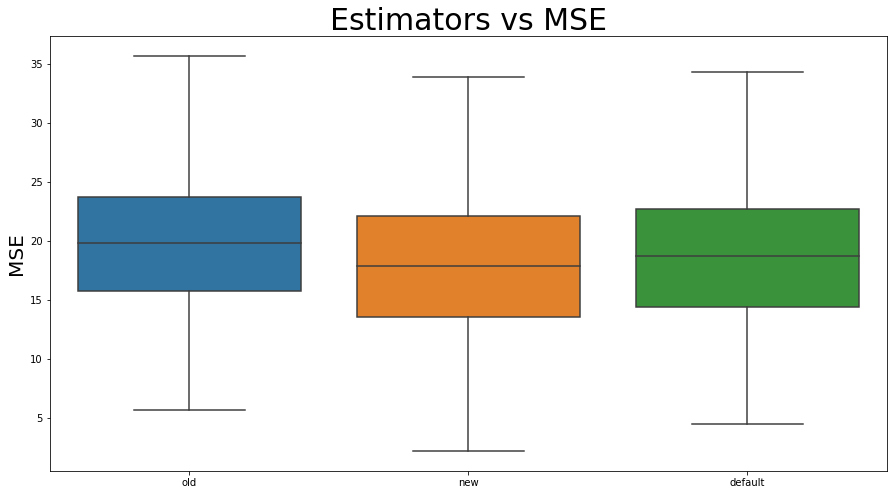

In [42]:
TabNet_params = TabNet_res.best_params

models_TabNet = {}
models_TabNet['old'] = TabNetRegressor(n_d = 32,
                                    n_a = 32,
                                    n_steps = 7,
                                    gamma = 1.5,
                                    n_independent = 20,
                                    verbose = False,
                                    device_name = 'cuda')
models_TabNet['new'] = TabNetRegressor(**TabNet_params,
                                       n_a = TabNet_params['n_d'],
                                       verbose = False, 
                                       device_name = 'cuda')

models_TabNet['default'] = TabNetRegressor(verbose = False,
                                           device_name = 'cuda')

print(models_TabNet)
results_TabNet = train_and_test_regressor(models_TabNet, XW_train, YW_train, XW_test, YW_test, max_epochs = 100)
plot_model_comparison(results_TabNet)

In [38]:
optuna.visualization.plot_param_importances(TabNet_res)

In [40]:
optuna.visualization.plot_contour(TabNet_res)

# Debugging

Fitting KNN
Fitting RF
Fitting GB
Fitting XGB
[15:19:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting TabNet

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 359.33225
Best weights from best epoch are automatically used!
Calculating bootstrap score for KNN
Calculating bootstrap score for RF
Calculating bootstrap score for GB
Calculating bootstrap score for XGB
Calculating bootstrap score for TabNet


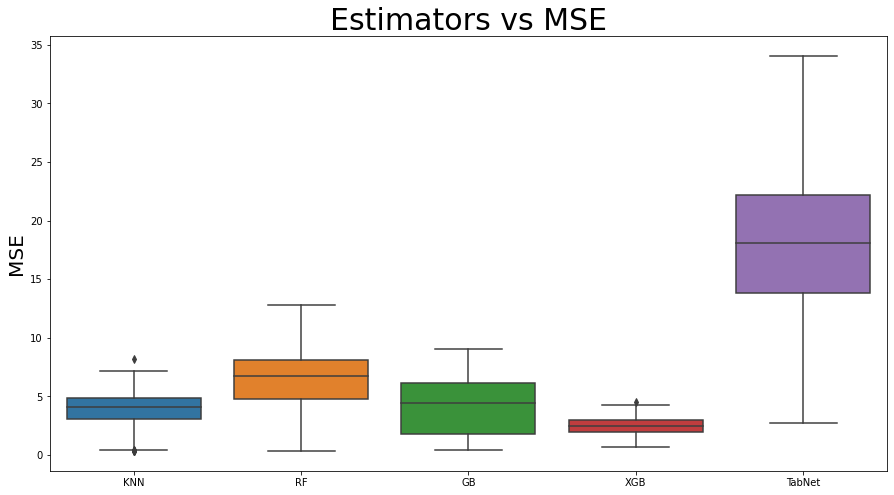

In [86]:
models = ['KNN', 'RF', 'GB', 'XGB', 'TabNet']

models_d = create_models_dict(models)

tuned_results = train_and_test_regressor(models_d, XW_train, YW_train, XW_test, YW_test)

plot_model_comparison(tuned_results)

[16:19:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 7.652456533356582
GB model 11.978170490764201
[16:19:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 85.67093351905685
GB model 67.74644926737481
[16:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 1.871245347868278
GB model 48.14135844210374
[16:19:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 2.3040662820980895
GB model 2.5558378882546395
[16:19:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 1.6383731338990246
GB model 2.1933960069613687

 XGB score 19.827414963255766
GB score 26.52304241909175
{'GB': Gradi

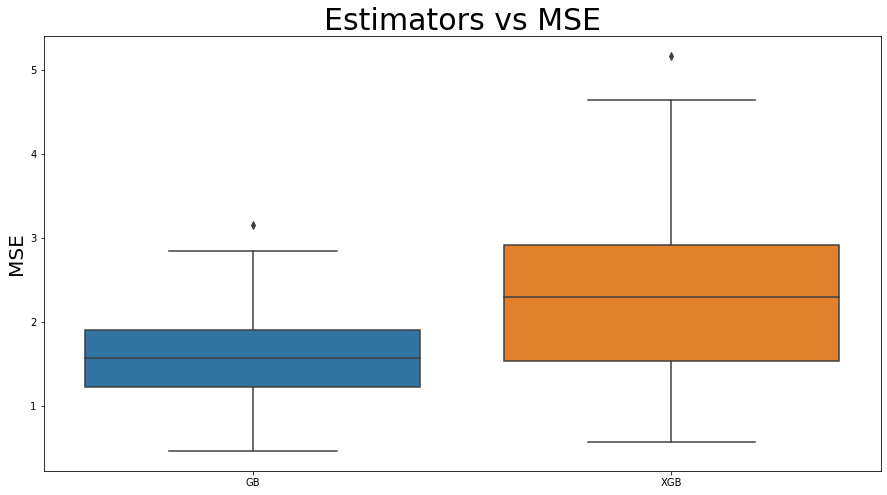

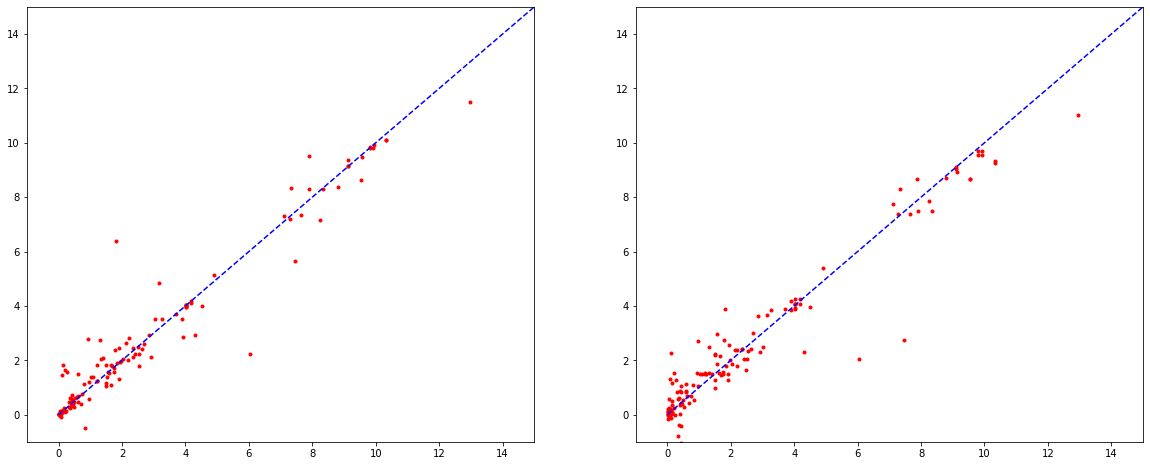

GB MSE: 2.699773000606855
XGB MSE: 5.888925800005179


In [ ]:
nfolds = 5
#kf = KFold(nfolds, shuffle = True, random_state=7)
kf = KFold(nfolds, shuffle = False)
score_XGB = 0
score_GB = 0

with open(path + f'/GB' + '_optimal_parameters', 'r') as fp:
    GB_params = json.load(fp)
with open(path + f'/XGB' + '_optimal_parameters', 'r') as fp:
    XGB_params = json.load(fp)

for train, test in kf.split(XW_train):
    #print(XW_train.iloc[test, :])
    #print(YW_train.iloc[test])
    #break

    model_XGB = xgboost.XGBRegressor(**XGB_params, n_estimators = 500, n_jobs = -1)
    model_GB = GradientBoostingRegressor(**GB_params, n_estimators = 500)
    
    model_XGB.fit(XW_train.iloc[train, :], YW_train.iloc[train])
    model_GB.fit(XW_train.iloc[train, :], YW_train.iloc[train])
    
    score_XGB += mean_squared_error(YW_train.iloc[test], model_XGB.predict(XW_train.iloc[test, :]),
                                squared = True)
    score_GB += mean_squared_error(YW_train.iloc[test], model_GB.predict(XW_train.iloc[test, :]),
                                squared = True)
    print('\n', 'XGB model:', mean_squared_error(YW_train.iloc[test], model_XGB.predict(XW_train.iloc[test, :]),
                                squared = True))
    print('GB model', mean_squared_error(YW_train.iloc[test], model_GB.predict(XW_train.iloc[test, :]),
                                squared = True))
score_XGB /= nfolds
score_GB /= nfolds

print(f"\n XGB score {score_XGB}")
print(f"GB score {score_GB}")

models = {
    'GB' : model_GB,
    'XGB' : model_XGB
}
print(models)
rrr = train_and_test_regressor(models,
                               XW_train,
                               YW_train,
                               XW_test.sample(frac = 1, random_state = 777),
                               YW_test.sample(frac = 1, random_state = 777))
plot_model_comparison(rrr)

fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(YW_test, model_GB.predict(XW_test), 'r.')
ax[1].plot(YW_test, model_XGB.predict(XW_test), 'r.')
for i in ax:
    i.plot([0, 170], [0, 170], color = 'b', ls = '--')
    i.set_xlim(-1, 15)
    i.set_ylim(-1, 15)
plt.show()


print(f'GB MSE: {mean_squared_error(YW_test, model_GB.predict(XW_test))}')
print(f'XGB MSE: {mean_squared_error(YW_test, model_XGB.predict(XW_test))}')


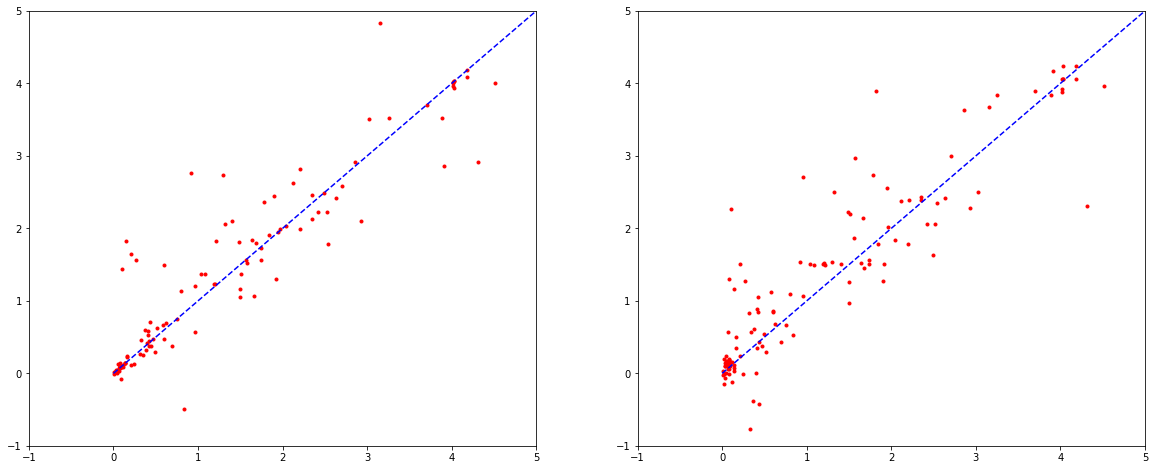

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(YW_test, model_GB.predict(XW_test), 'r.')
ax[1].plot(YW_test, model_XGB.predict(XW_test), 'r.')
for i in ax:
    i.plot([0, 170], [0, 170], color = 'b', ls = '--')
    i.set_xlim(-1, 5)
    i.set_ylim(-1, 5)
plt.show()

In [ ]:
XW_train.shape

(743, 50)